In [156]:
# import libraries
import pandas as pd
import numpy as np
import emoji
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# For BERTopic
import os
import random
import numpy as np
import torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

from hdbscan import HDBSCAN
from umap import UMAP

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=20,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)


In [158]:
# Load the datasets
threads_df = pd.read_csv("Data/threads_reviews.csv")     
twitter_df = pd.read_csv("Data/twitter_reviews.csv") 

### Looking at Threads dataset

In [160]:
# First 5 Threads
print(threads_df.head())

        source                                 review_description  rating  \
0  Google Play  Meh. Not the greatest experience on a Chromebo...       2   
1  Google Play  Pretty good for a first launch!! Its easy to u...       3   
2  Google Play  For a brand new app, it's very well optimized....       3   
3  Google Play  Great app with a lot of potential! However, th...       3   
4  Google Play  The app is good, but it needs a lot of functio...       3   

           review_date  
0  2023-07-08 14:18:24  
1  2023-07-19 20:52:48  
2  2023-07-06 23:03:11  
3  2023-07-10 00:53:25  
4  2023-07-06 16:57:43  


In [163]:
# Last 5 threads
print(threads_df.tail())

          source                                 review_description  rating  \
32905  App Store  This killed my dog. Mark zuckerburg strangled ...       1   
32906  App Store              Add Search and hashtag like Twitter !       1   
32907  App Store                                        bad twister       1   
32908  App Store                       Yet another trash from Meta.       1   
32909  App Store  Nothing special this app is just a copy of twi...       1   

               review_date  
32905  2023-07-06 01:23:55  
32906  2023-07-19 08:01:06  
32907  2023-07-17 06:39:13  
32908  2023-07-07 17:47:16  
32909  2023-07-07 07:01:43  


- threads dataset has few 'app_store' data points.
- to check how many 'app_store' and handle

### Looking at Twitter dataset

In [167]:
# First 5 Twitter
print(twitter_df.head())

   Unnamed: 0                             review_id  pseudo_author_id  \
0     1988084  f1584af1-3c91-4b7b-ade9-bd88c8d7a057      2.184470e+20   
1     1988085  3244b60a-8656-4fad-aaa6-7f199b6bf5bd      2.702280e+20   
2     1988086  f6aa48d3-e35a-454f-8eb2-b2605fbd5632      2.379510e+20   
3     1988087  00d82206-a895-432f-9761-baa3eb181749      1.530330e+20   
4     1988088  34a514ff-8f35-4e57-a667-18adfe416f25      1.743680e+20   

           author_name                                        review_text  \
0         Ay********an                                                 Ok   
1          Pr*******ai  App and website quality has consistently been ...   
2  St***************ch                          Great app; no complaints.   
3          A.*******ey                App crashes whenever I try to post.   
4        TA*********AT  Forced to download app cos I cant see tweets w...   

   review_rating  review_likes author_app_version review_timestamp  \
0              5            

In [168]:
# Last 5 twitter
print(twitter_df.tail())

       Unnamed: 0                             review_id  pseudo_author_id  \
34783     2022867  8eb3e09e-0269-4000-bf1d-bca068aab0d4      1.831740e+20   
34784     2022868  07147f9e-12e2-41e5-9909-9fd58833b9b1      4.070130e+20   
34785     2022869  2993c3c6-ae99-4b7a-922b-2f9ad4cc8fd1      6.310000e+20   
34786     2022870  4e199ee2-5d5a-4250-8d33-c616c9a425d3      2.912830e+20   
34787     2022871  3ef51c55-d534-45cb-847c-94a7f1fcc8a2      1.487260e+20   

         author_name                                        review_text  \
34783  Av*********an                                 This app is a cyst   
34784             **  見つける機能廃止の代わりのハイライトの通信がやたら時間かかる。タイムラインも読み込みに時間か...   
34785       In****r8                                        It's so bad   
34786   Ro********er  Horrible because Elon doesn't know how to do a...   
34787  Al*********ić                                Bro wachu mean "X"💀   

       review_rating  review_likes author_app_version review_timestamp  \
34783       

- the twitter dataset has many unwanted columns, should handle this
- it also has different language other tha english, should handle this

### Threads Info

In [171]:
# Info print for threads
print(threads_df.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB
None 



### Twitter Info

In [173]:
# Info print for twitter
print(twitter_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34788 entries, 0 to 34787
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          34788 non-null  int64  
 1   review_id           34788 non-null  object 
 2   pseudo_author_id    34788 non-null  float64
 3   author_name         34788 non-null  object 
 4   review_text         34785 non-null  object 
 5   review_rating       34788 non-null  int64  
 6   review_likes        34788 non-null  int64  
 7   author_app_version  27874 non-null  object 
 8   review_timestamp    34788 non-null  object 
 9   sentiment_true      932 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 2.7+ MB
None


In [174]:
# Columns for confirmation
print("Threads columns:", threads_df.columns.tolist())
print("Twitter columns:", twitter_df.columns.tolist())

Threads columns: ['source', 'review_description', 'rating', 'review_date']
Twitter columns: ['Unnamed: 0', 'review_id', 'pseudo_author_id', 'author_name', 'review_text', 'review_rating', 'review_likes', 'author_app_version', 'review_timestamp', 'sentiment_true']


- We see Twitter has unwanted columns not required for our project

#### Missing values - Threads

In [182]:
# Missing Values of Threads
print("\nMissing values (Threads):\n", threads_df.isnull().sum())



Missing values (Threads):
 source                0
review_description    0
rating                0
review_date           0
dtype: int64


#### Missing Values - Twitter

In [185]:
# Missing Values of Twitter
print("\nMissing values (Twitter):\n", twitter_df.isnull().sum())


Missing values (Twitter):
 Unnamed: 0                0
review_id                 0
pseudo_author_id          0
author_name               0
review_text               3
review_rating             0
review_likes              0
author_app_version     6914
review_timestamp          0
sentiment_true        33856
dtype: int64


- Twitter has missing values in 2 columns - should handle this

## Data cleaning for threads for now

In [189]:
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd

# ===========================================================
# 1. DUPLICATE DETECTION (RAW TEXT)
# ===========================================================

print("\n===== RAW DUPLICATE CHECK =====")
df = threads_df.copy()
dups_raw = df[df.duplicated(subset=["review_description"], keep=False)]
dups_raw_idx = dups_raw.reset_index()[["index", "review_description"]]

print("Total RAW duplicate rows:", len(dups_raw_idx))
print("\n--- SAMPLE RAW DUPLICATES ---")
print(dups_raw_idx.head(10))


# ===========================================================
# 2. LONG-REVIEW DUPLICATE REMOVAL
# ===========================================================

def is_long_review(text, min_words=15):
    return len(str(text).split()) >= min_words

df["is_long"] = df["review_description"].apply(is_long_review)

df_long = df[df["is_long"] == True].copy()
df_short = df[df["is_long"] == False].copy()

print("\n===== LONG REVIEW STATS =====")
print("Long reviews:", df_long.shape[0])
print("Short reviews:", df_short.shape[0])

dup_long_mask = df_long.duplicated(subset=["review_description"], keep=False)
df_long_dups = df_long[dup_long_mask]

print("\n===== LONG DUPLICATES FOUND =====")
print("Total long duplicate rows:", df_long_dups.shape[0])

dup_groups_long = (
    df_long_dups.reset_index()
                .groupby("review_description")["index"]
                .apply(list)
                .reset_index(name="row_numbers")
)

print("Distinct long duplicated texts:", len(dup_groups_long))
print("\n--- SAMPLE LONG DUPLICATE GROUPS ---")
print(dup_groups_long.head(10))

before_long = df_long.shape[0]
df_long_clean = df_long.drop_duplicates(subset=["review_description"], keep="first")
after_long = df_long_clean.shape[0]

print("\n===== LONG DUPLICATE REMOVAL =====")
print("Before:", before_long)
print("After :", after_long)
print("Removed:", before_long - after_long)

df = pd.concat([df_long_clean, df_short], ignore_index=True)
df.drop(columns=["is_long"], inplace=True)

print("\n===== AFTER LONG-DEDUPE: df.shape =====")
print(df.shape)

# ===========================================================
# 3. BRAND NORMALIZATION MAP
# ===========================================================

brand_map = {
    # Twitter / X
    r"\btwitter\b": "twitter",
    r"\btwt\b": "twitter",
    r"\btwit\b": "twitter",
    r"\btwwitter\b": "twitter",
    r"\btwiter\b": "twitter",
    r"\bx\b": "twitter",

    # Threads
    r"\bthreads\b": "threads",
    r"\bthread\b": "threads",
    r"\btread\b": "threads",
    r"\btreads\b": "threads",
    r"\bthreds\b": "threads",

    # Instagram
    r"\binstagram\b": "instagram",
    r"\binsta\b": "instagram",
    r"\binstgram\b": "instagram",
    r"\binstragram\b": "instagram",

    # Facebook + Meta
    r"\bfacebook\b": "facebook",
    r"\bfacebok\b": "facebook",
    r"\bfb\b": "facebook",
    r"\bmeta\b": "facebook",
}

def normalize_brands(text):
    text = str(text).lower()
    for pattern, repl in brand_map.items():
        text = re.sub(pattern, repl, text)
    return text


# ===========================================================
# 4. CLEANING PIPELINE (COMBINED)
# ===========================================================

stop_words = set(stopwords.words("english"))
negations = {"no", "not", "nor", "dont", "can't", "cannot", "never"}
stop_words = stop_words - negations

lemmatizer = WordNetLemmatizer()

# Custom stopwords - INCLUDING normalized brand names
custom_stopwords = set([
    "app", "apps", "application", "applications",
    "thread", "threads", "instagram", "twitter", 
    "facebook", "experience", "im", "account"
])

def clean_text(text):
    # Step 1: Normalize brands FIRST (before any other processing)
    text = normalize_brands(text)
    
    # Step 2: Basic cleaning
    text = str(text)
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)  # Remove special chars (added space)
    text = re.sub(r"\s+", " ", text).strip()    # Normalize whitespace
    
    # Step 3: Tokenization and stopword removal
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in custom_stopwords]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)


# Apply cleaning
df["review_cleaned"] = df["review_description"].apply(clean_text)


print("\n===== CLEANING CHECK =====")
for i in range(5):
    print("\nOriginal:", df.loc[i, "review_description"])
    print("Cleaned :", df.loc[i, "review_cleaned"])


# ===========================================================
# 5. REMOVE EMPTY CLEANED ROWS
# ===========================================================

before = df.shape[0]
df = df[df["review_cleaned"].str.strip() != ""]
after = df.shape[0]

print("\n===== EMPTY CLEANED TEXT REMOVAL =====")
print("Before:", before)
print("After:", after)
print("Removed:", before - after)


#==============================================
# 5.5 LANGUAGE DETECTION & FILTERING 
#=============================================

from langdetect import detect, LangDetectException, DetectorFactory
DetectorFactory.seed = 42
# ==============================================
# MINIMAL LANGUAGE DETECTION & FILTERING
# ==============================================

from langdetect import detect, LangDetectException

REMOVE_LANGS = {"vi","tr","sw","sq","so","pt","lv","lt","id","hr","et","es"}

def detect_language(text):
    try:
        text_str = str(text).strip()
        if len(text_str) < 10:
            return 'unknown'
        return detect(text_str)
    except LangDetectException:
        return 'unknown'
    except:
        return 'unknown'

# Detect languages
df["detected_lang"] = df["review_cleaned"].apply(detect_language)

print("\n===== LANGUAGE DISTRIBUTION =====")
print(df["detected_lang"].value_counts())


# -----------------------------------------------------
# REMOVE ONLY SPECIFIED LANGUAGES
# keep English + unknown + any other safe languages
# -----------------------------------------------------
before = df.shape[0]

df = df[~df["detected_lang"].isin(REMOVE_LANGS)].copy()
df = df.reset_index(drop=True)

print(f"\nRemoved {before - df.shape[0]} rows from unwanted languages.")
print("\n===== FINAL DATASET SHAPE =====")
print(df.shape)




===== RAW DUPLICATE CHECK =====
Total RAW duplicate rows: 7124

--- SAMPLE RAW DUPLICATES ---
   index                                 review_description
0     23  It's a good start but they have to add some th...
1    105  It's a great start! I do feel like when adding...
2    222  The user experience so far so good, clean and ...
3   3773  It's a good start but they have to add some th...
4   4516  It's a great start! I do feel like when adding...
5   4604  The user experience so far so good, clean and ...
6   5915                               Not working properly
7   5938                               Not working properly
8   5939                               Not working properly
9   6050                               Not working properly

===== LONG REVIEW STATS =====
Long reviews: 8301
Short reviews: 24609

===== LONG DUPLICATES FOUND =====
Total long duplicate rows: 6
Distinct long duplicated texts: 3

--- SAMPLE LONG DUPLICATE GROUPS ---
                                  revi

In [190]:
# Apply cleaning
threads_clean  =  df.copy()
threads_clean["review_cleaned"] = threads_clean["review_description"].apply(clean_text)


print("\n--- CLEANING CHECK: original vs cleaned ---")
for i in range(3):
    print("\nOriginal:", threads_clean.loc[i, "review_description"])
    print("Cleaned :", threads_clean.loc[i, "review_cleaned"])



--- CLEANING CHECK: original vs cleaned ---

Original: Meh. Not the greatest experience on a Chromebook. Seems to be customized for phones only. Opens in a little screen that you can't expand or resize - for reasons that are a complete mystery to me. Judging from the fact that every other app I know of is resizeable, this seems like it was a conscious choice by the developers . Why you'd do something like this is beyond understanding and suggests a control freak approach. Not a great way to make a first impression.
Cleaned : meh not greatest chromebook seems customized phone open little screen expand resize reason complete mystery judging fact every know resizeable seems like conscious choice developer something like beyond understanding suggests control freak approach not great way make first impression

Original: Pretty good for a first launch!! Its easy to use and self-explanatory and I'd say the algorithm is good as well. It has great *potential* but a few things need improvement:

## Data Cleaning for twitter

In [192]:

# ===========================================================
# 1. DUPLICATE DETECTION (RAW TEXT)
# ===========================================================

print("\n===== RAW DUPLICATE CHECK =====")
df = twitter_df.copy()
dups_raw = df[df.duplicated(subset=["review_text"], keep=False)]
dups_raw_idx = dups_raw.reset_index()[["index", "review_text"]]

print("Total RAW duplicate rows:", len(dups_raw_idx))
print("\n--- SAMPLE RAW DUPLICATES ---")
print(dups_raw_idx.head(10))


# ===========================================================
# 2. LONG-REVIEW DUPLICATE REMOVAL
# ===========================================================

def is_long_review(text, min_words=15):
    return len(str(text).split()) >= min_words

df["is_long"] = df["review_text"].apply(is_long_review)

df_long = df[df["is_long"] == True].copy()
df_short = df[df["is_long"] == False].copy()

print("\n===== LONG REVIEW STATS =====")
print("Long reviews:", df_long.shape[0])
print("Short reviews:", df_short.shape[0])

dup_long_mask = df_long.duplicated(subset=["review_text"], keep=False)
df_long_dups = df_long[dup_long_mask]

print("\n===== LONG DUPLICATES FOUND =====")
print("Total long duplicate rows:", df_long_dups.shape[0])

dup_groups_long = (
    df_long_dups.reset_index()
                .groupby("review_text")["index"]
                .apply(list)
                .reset_index(name="row_numbers")
)

print("Distinct long duplicated texts:", len(dup_groups_long))
print("\n--- SAMPLE LONG DUPLICATE GROUPS ---")
print(dup_groups_long.head(10))

before_long = df_long.shape[0]
df_long_clean = df_long.drop_duplicates(subset=["review_text"], keep="first")
after_long = df_long_clean.shape[0]

print("\n===== LONG DUPLICATE REMOVAL =====")
print("Before:", before_long)
print("After :", after_long)
print("Removed:", before_long - after_long)

df = pd.concat([df_long_clean, df_short], ignore_index=True)
df.drop(columns=["is_long"], inplace=True)

print("\n===== AFTER LONG-DEDUPE: df.shape =====")
print(df.shape)


# ===========================================================
# 3. BRAND NORMALIZATION MAP
# ===========================================================

brand_map = {
    # Twitter / X
    r"\btwitter\b": "twitter",
    r"\btwt\b": "twitter",
    r"\btwit\b": "twitter",
    r"\btwwitter\b": "twitter",
    r"\btwiter\b": "twitter",
    r"\bx\b": "twitter",

    # Threads
    r"\bthreads\b": "threads",
    r"\bthread\b": "threads",
    r"\btread\b": "threads",
    r"\btreads\b": "threads",
    r"\bthreds\b": "threads",

    # Instagram
    r"\binstagram\b": "instagram",
    r"\binsta\b": "instagram",
    r"\binstgram\b": "instagram",
    r"\binstragram\b": "instagram",

    # Facebook + Meta
    r"\bfacebook\b": "facebook",
    r"\bfacebok\b": "facebook",
    r"\bfb\b": "facebook",
    r"\bmeta\b": "facebook",
}

def normalize_brands(text):
    text = str(text).lower()
    for pattern, repl in brand_map.items():
        text = re.sub(pattern, repl, text)
    return text


# ===========================================================
# 4. CLEANING PIPELINE (COMBINED)
# ===========================================================

stop_words = set(stopwords.words("english"))
negations = {"no", "not", "nor", "dont", "can't", "cannot", "never"}
stop_words = stop_words - negations

lemmatizer = WordNetLemmatizer()

# Custom stopwords - INCLUDING normalized brand names
custom_stopwords = set([
    "app", "apps", "application", "applications",
    "twitter", "im", "account"
])

def clean_text(text):
    # Step 1: Normalize brands FIRST (before any other processing)
    text = normalize_brands(text)
    
    # Step 2: Basic cleaning
    text = str(text)
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)  # Remove special chars (added space)
    text = re.sub(r"\s+", " ", text).strip()    # Normalize whitespace
    
    # Step 3: Tokenization and stopword removal
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in custom_stopwords]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# Apply cleaning
df["review_cleaned"] = df["review_text"].apply(clean_text)

print("\n===== CLEANING CHECK =====")
for i in range(5):
    print("\nOriginal:", df.loc[i, "review_text"])
    print("Cleaned :", df.loc[i, "review_cleaned"])


# ===========================================================
# 5. REMOVE EMPTY CLEANED ROWS
# ===========================================================

before = df.shape[0]
df = df[df["review_cleaned"].str.strip() != ""]
after = df.shape[0]

print("\n===== EMPTY CLEANED TEXT REMOVAL =====")
print("Before:", before)
print("After:", after)
print("Removed:", before - after)

# ==============================================
# MINIMAL LANGUAGE DETECTION & FILTERING
# ==============================================

from langdetect import detect, LangDetectException, DetectorFactory
DetectorFactory.seed = 42

REMOVE_LANGS = {"vi","tr","tl","sw","sq","so","sl","pl","pt","lv","lt","id","hr","es","ca","cy","de","fi","hu"}

def detect_language(text):
    try:
        text_str = str(text).strip()
        if len(text_str) < 10:
            return 'unknown'
        return detect(text_str)
    except LangDetectException:
        return 'unknown'
    except:
        return 'unknown'

# Detect languages
df["detected_lang"] = df["review_cleaned"].apply(detect_language)

print("\n===== LANGUAGE DISTRIBUTION =====")
print(df["detected_lang"].value_counts())

# -----------------------------------------------------
# REMOVE ONLY SPECIFIED LANGUAGES
# keep English + unknown + any other safe languages
# -----------------------------------------------------
before = df.shape[0]

df = df[~df["detected_lang"].isin(REMOVE_LANGS)].copy()
df = df.reset_index(drop=True)

print(f"\nRemoved {before - df.shape[0]} rows from unwanted languages.")
print("\n===== FINAL DATASET SHAPE =====")
print(df.shape)


===== RAW DUPLICATE CHECK =====
Total RAW duplicate rows: 5490

--- SAMPLE RAW DUPLICATES ---
   index      review_text
0      0               Ok
1      7             Nice
2     11         Good app
3     14             Good
4     17        Great app
5     19             Good
6     24        Nice Apps
7     25               Ok
8     26         Terrible
9     27  Good experience

===== LONG REVIEW STATS =====
Long reviews: 8616
Short reviews: 26172

===== LONG DUPLICATES FOUND =====
Total long duplicate rows: 0
Distinct long duplicated texts: 0

--- SAMPLE LONG DUPLICATE GROUPS ---
Empty DataFrame
Columns: [review_text, row_numbers]
Index: []

===== LONG DUPLICATE REMOVAL =====
Before: 8616
After : 8616
Removed: 0

===== AFTER LONG-DEDUPE: df.shape =====
(34788, 10)

===== CLEANING CHECK =====

Original: Bahut hi ghatiya app hai aapki id dubara nhi milti hai or dusra account bhi nhi banta
Cleaned : bahut hi ghatiya hai aapki id dubara nhi milti hai dusra bhi nhi banta

Original: A cessp

In [193]:
# Apply cleaning
twitter_clean = df.copy()

print("\n--- CLEANING CHECK: original vs cleaned ---")
for i in range(3):
    print("\nOriginal:", twitter_clean.loc[i, "review_text"])
    print("Cleaned :", twitter_clean.loc[i, "review_cleaned"])


--- CLEANING CHECK: original vs cleaned ---

Original: A cesspool of bigotry, rascism, homophobia, transphobia, misogyny and fascism, all lead by the greediest narcissist of the all.
Cleaned : cesspool bigotry rascism homophobia transphobia misogyny fascism lead greediest narcissist

Original: It is good to see there are a lot of people that believe the same things I do. The government and deep state are out of control and we the people are powerless against this bloated over reaching and corrupt system that is now in place. The FBI is working for the Democratic Party with little regard for the rule of law. The mainstream media is the epitome of corruption with not one real journalist seeking the real truth. The current administration gaslights the American people with no consequence
Cleaned : good see lot people believe thing government deep state control people powerless bloated reaching corrupt system place fbi working democratic party little regard rule law mainstream medium epito

## Threads frequent Words

In [195]:
import nltk
from nltk.probability import FreqDist

# Make sure you have NLTK punkt tokenizer
nltk.download("punkt")

# Combine all reviews (or you can do per cluster)
all_words = " ".join(threads_clean["review_cleaned"]).split()  # or nltk.word_tokenize(text)
freq_dist = FreqDist(all_words)

# Top 20 words overall
print("Top 20 words overall:")
for word, freq in freq_dist.most_common(20):
    print(f"{word}: {freq}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\racha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top 20 words overall:
good: 4242
not: 3388
like: 3040
nice: 2229
better: 1778
post: 1763
no: 1670
people: 1577
see: 1538
need: 1448
follow: 1360
use: 1358
great: 1234
feature: 1202
please: 1145
want: 1084
new: 1042
best: 1024
one: 1014
time: 977


## Twitter Frequent words

In [197]:
import nltk
from nltk.probability import FreqDist

# Make sure you have NLTK punkt tokenizer
nltk.download("punkt")

# Combine all reviews (or you can do per cluster)
all_words = " ".join(twitter_clean["review_cleaned"]).split()  # or nltk.word_tokenize(text)
freq_dist = FreqDist(all_words)

# Top 20 words overall
print("Top 20 words overall:")
for word, freq in freq_dist.most_common(20):
    print(f"{word}: {freq}")


Top 20 words overall:
elon: 3885
not: 3122
good: 2839
like: 2131
musk: 1907
tweet: 1871
new: 1715
change: 1565
no: 1485
back: 1402
name: 1370
better: 1297
update: 1248
great: 1185
even: 1142
best: 1129
since: 1102
worse: 1068
social: 1061
get: 1058


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\racha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## SENTIMENT ANALYSIS : USING VADER + KNN FOR THREADS

By applying KMeans clustering to the compound sentiment scores, we could segment reviews into three clusters. The centroids of these clusters inform the thresholds for classifying sentiment, allowing for more objective labeling than manual cutoff values.

In [199]:

# ----------- LOAD DATA --------------
df = threads_clean.copy()     
# ------------------------------------


# ---------- VADER SCORES -----------
analyzer = SentimentIntensityAnalyzer()
df["compound"] = df["review_cleaned"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
compound_array = df["compound"].values.reshape(-1,1)
# ------------------------------------

# ----------- KMEANS 3 CLUSTERS -----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
clusters = kmeans.fit_predict(compound_array)
df["cluster"] = clusters

# map centroids -> pos/neu/neg
centroids = kmeans.cluster_centers_.flatten()
order = np.argsort(centroids)
label_map = {order[0]: "negative", order[1]: "neutral", order[2]: "positive"}

df["sentiment"] = df["cluster"].map(label_map)
# ------------------------------------

print(df[["review_description","review_cleaned","compound","sentiment"]].head())
df_threads = df.copy()

                                  review_description  \
0  Meh. Not the greatest experience on a Chromebo...   
1  Pretty good for a first launch!! Its easy to u...   
2  For a brand new app, it's very well optimized....   
3  Great app with a lot of potential! However, th...   
4  The app is good, but it needs a lot of functio...   

                                      review_cleaned  compound sentiment  
0  meh not greatest chromebook seems customized p...   -0.4479  negative  
1  pretty good first launch easy use self explana...    0.9893  positive  
2  brand new well optimized however missing quite...    0.8960  positive  
3  great lot potential however lot need fixed exa...    0.1280   neutral  
4  good need lot functionality example searching ...    0.8176  positive  


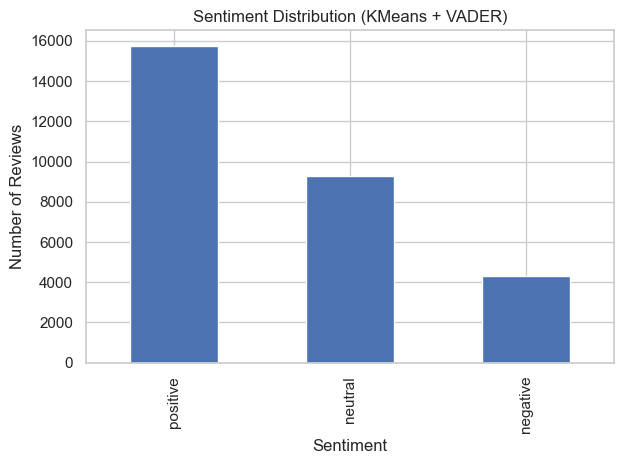

In [200]:
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="bar")

plt.title("Sentiment Distribution (KMeans + VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


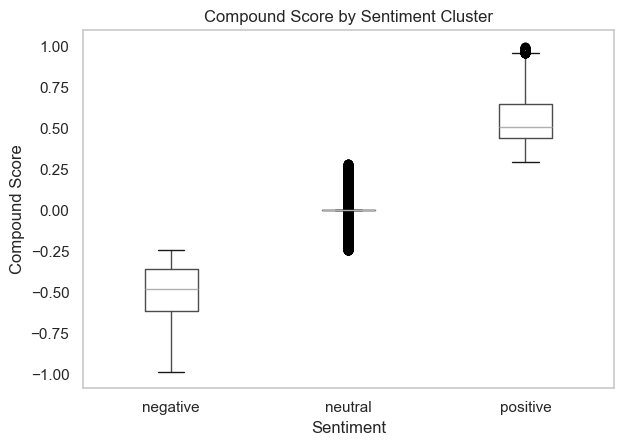

In [201]:
df.boxplot(column="compound", by="sentiment", grid=False)

plt.title("Compound Score by Sentiment Cluster")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Compound Score")
plt.tight_layout()
plt.show()


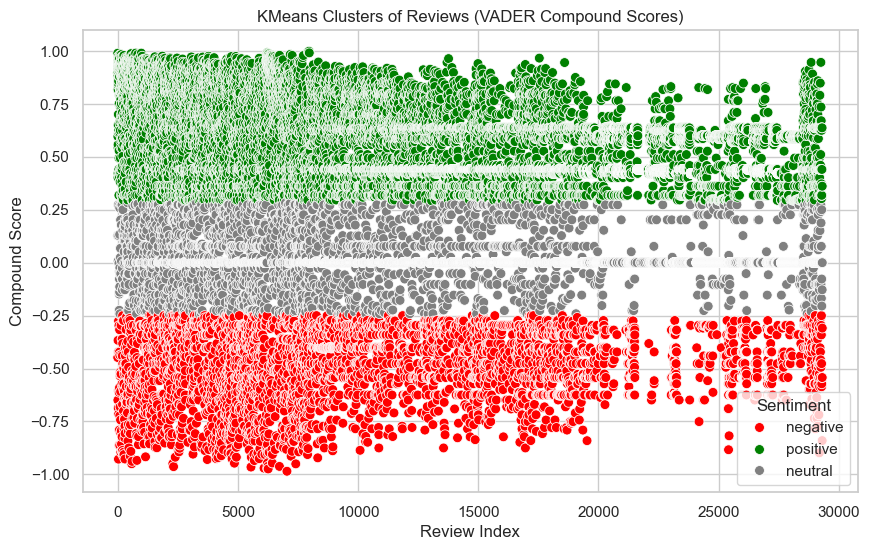

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot the clusters along the compound score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=range(len(df)), 
    y="compound", 
    hue="sentiment", 
    palette={"negative":"red", "neutral":"gray", "positive":"green"},
    data=df,
    s=50
)
plt.title("KMeans Clusters of Reviews (VADER Compound Scores)")
plt.xlabel("Review Index")
plt.ylabel("Compound Score")
plt.legend(title="Sentiment")
plt.show()


The KNN clustering makes a custom threshold for us without us needing to have a hard coded threshold for different sentiments.The reviews seem to be perfectly clustered with respect to their respective scores.

Top words in negative cluster: [('not', 1035), ('no', 854), ('bad', 478), ('post', 451), ('people', 362), ('worst', 325), ('like', 323), ('see', 321), ('time', 321), ('follow', 299)]
Top words in positive cluster: [('good', 3846), ('like', 2386), ('nice', 2176), ('better', 1593), ('great', 1176), ('not', 1135), ('best', 981), ('love', 924), ('people', 899), ('please', 892)]
Top words in neutral cluster: [('not', 1218), ('copy', 467), ('post', 456), ('need', 411), ('see', 390), ('use', 379), ('no', 376), ('follow', 352), ('like', 331), ('want', 327)]


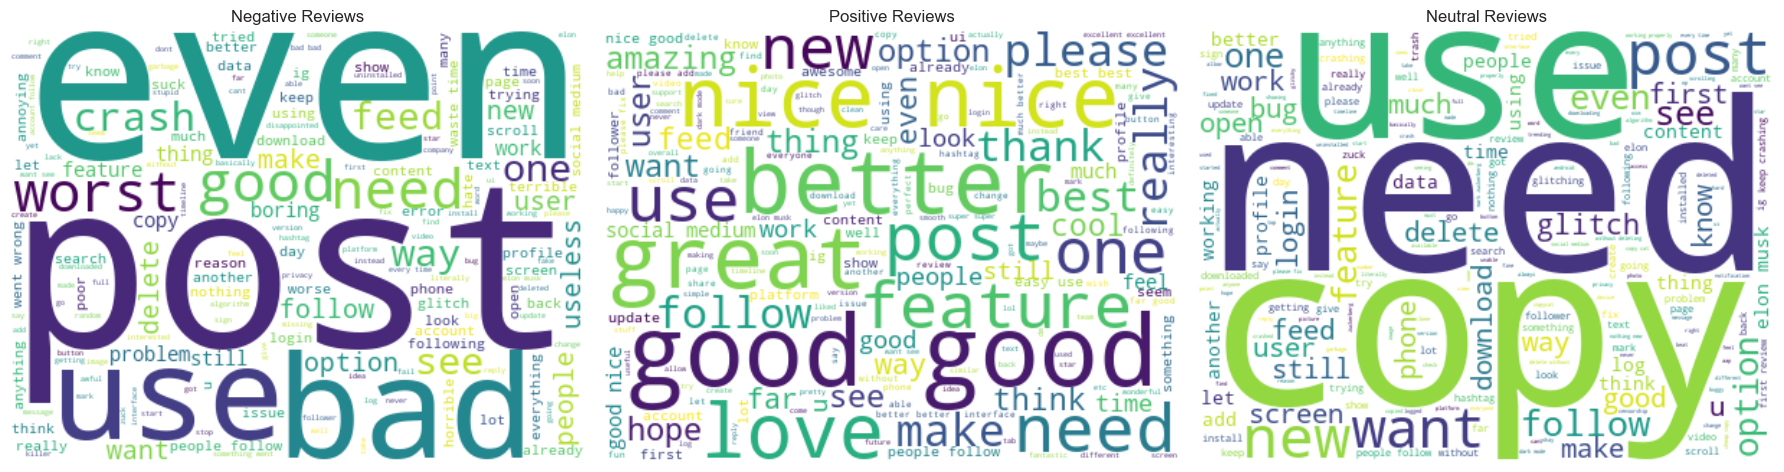

In [204]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a function to get top words
def get_top_words(text_series, n=10):
    words = " ".join(text_series).split()
    counter = Counter(words)
    return counter.most_common(n)

# Plot word clouds for each sentiment cluster
sentiments = df["sentiment"].unique()
plt.figure(figsize=(18,6))

for i, sentiment in enumerate(sentiments, 1):
    text = df[df["sentiment"] == sentiment]["review_cleaned"]
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=300, background_color="white").generate(" ".join(text))
    
    # Plot
    plt.subplot(1, len(sentiments), i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{sentiment.capitalize()} Reviews")
    
    # Print top 10 words in console
    print(f"Top words in {sentiment} cluster:", get_top_words(text))

plt.tight_layout()
plt.show()

threads_pos = df[df["sentiment"] == "positive"]
threads_neu = df[df["sentiment"] == "neutral"]
threads_neg = df[df["sentiment"] == "negative"]


- The Negative word cloud clearly shows us few problems or sentiments like bad, crash, uselss etc
- Where as the positive word cloud shows us few workds like great, love, better, nice etc as the important features.
- Lastly the neutral word cloud shows general opinions inclusing follow, download, content, copy etc

## SENTIMENT ANALYSIS : USING VADER + KNN FOR TWITTER

By applying KMeans clustering to the compound sentiment scores, we could segment reviews into three clusters. The centroids of these clusters inform the thresholds for classifying sentiment, allowing for more objective labeling than manual cutoff values.

In [207]:

# ----------- LOAD DATA --------------
df = twitter_clean.copy()     
# ------------------------------------


# ---------- VADER SCORES -----------
analyzer = SentimentIntensityAnalyzer()
df["compound"] = df["review_cleaned"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
compound_array = df["compound"].values.reshape(-1,1)
# ------------------------------------

# ----------- KMEANS 3 CLUSTERS -----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
clusters = kmeans.fit_predict(compound_array)
df["cluster"] = clusters

# map centroids -> pos/neu/neg
centroids = kmeans.cluster_centers_.flatten()
order = np.argsort(centroids)
label_map = {order[0]: "negative", order[1]: "neutral", order[2]: "positive"}

df["sentiment"] = df["cluster"].map(label_map)
# ------------------------------------

print(df[["review_text","review_cleaned","compound","sentiment"]].head())
df_twitter = df.copy()

                                         review_text  \
0  A cesspool of bigotry, rascism, homophobia, tr...   
1  It is good to see there are a lot of people th...   
2  I am removing this app because I abuse Manoj M...   
3  Twitter is nice but my account often got locke...   
4  It's better actually. Just improve the video w...   

                                      review_cleaned  compound sentiment  
0  cesspool bigotry rascism homophobia transphobi...   -0.5859  negative  
1  good see lot people believe thing government d...    0.5106  positive  
2  removing abuse manoj muntasir tweet happened p...    0.8885  positive  
3  nice often got locked lot violation even know ...   -0.0772   neutral  
4  better actually improve video watching experie...    0.7003  positive  


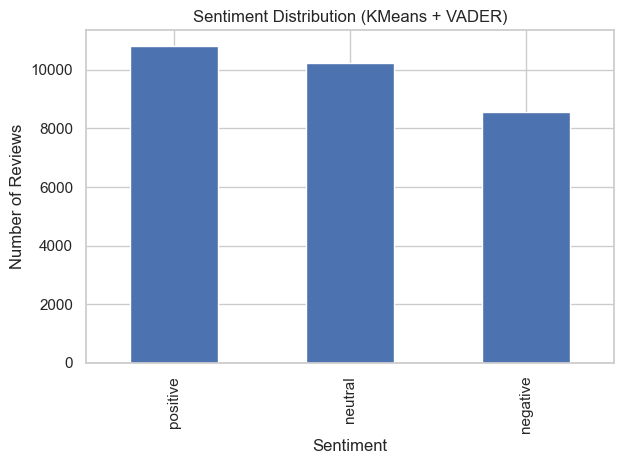

In [208]:
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="bar")

plt.title("Sentiment Distribution (KMeans + VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


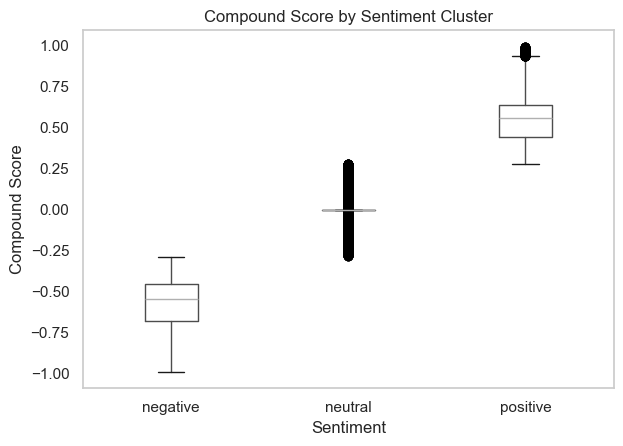

In [209]:
df.boxplot(column="compound", by="sentiment", grid=False)

plt.title("Compound Score by Sentiment Cluster")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Compound Score")
plt.tight_layout()
plt.show()


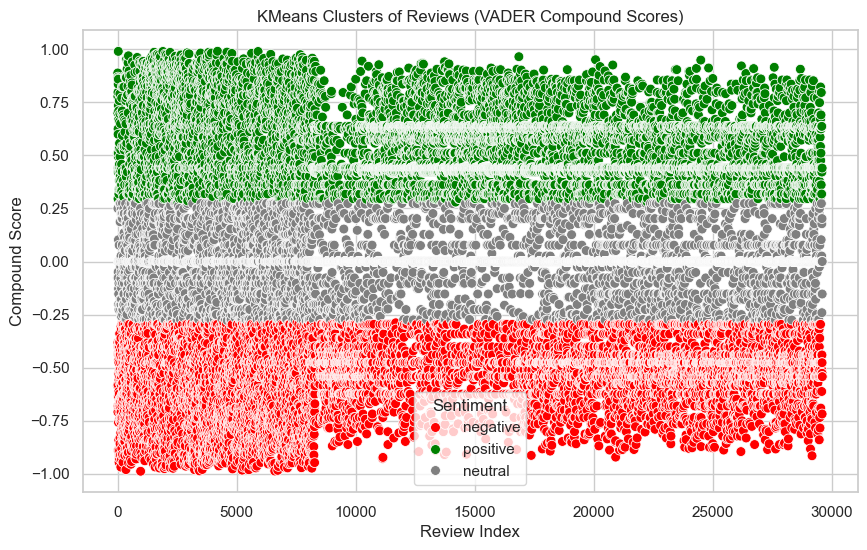

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot the clusters along the compound score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=range(len(df)), 
    y="compound", 
    hue="sentiment", 
    palette={"negative":"red", "neutral":"gray", "positive":"green"},
    data=df,
    s=50
)
plt.title("KMeans Clusters of Reviews (VADER Compound Scores)")
plt.xlabel("Review Index")
plt.ylabel("Compound Score")
plt.legend(title="Sentiment")
plt.show()

twitter_pos = df[df["sentiment"] == "positive"]
twitter_neu = df[df["sentiment"] == "neutral"]
twitter_neg = df[df["sentiment"] == "negative"]



Top words in negative cluster: [('elon', 1477), ('not', 1175), ('no', 963), ('worse', 870), ('bad', 865), ('new', 753), ('musk', 752), ('tweet', 746), ('ruined', 695), ('worst', 604)]
Top words in positive cluster: [('good', 2173), ('like', 1213), ('elon', 1103), ('best', 1043), ('great', 1015), ('better', 986), ('not', 800), ('love', 781), ('nice', 738), ('social', 563)]
Top words in neutral cluster: [('elon', 1305), ('not', 1147), ('tweet', 667), ('back', 654), ('musk', 644), ('change', 568), ('like', 464), ('new', 447), ('name', 440), ('bird', 416)]


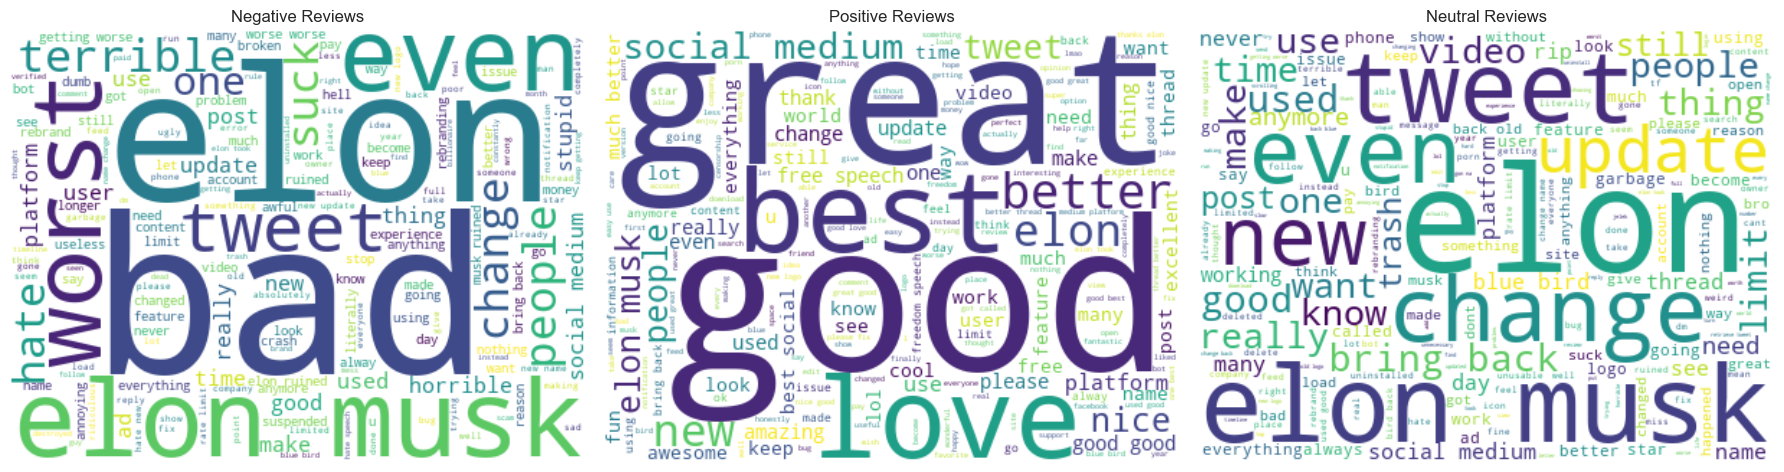

In [211]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a function to get top words
def get_top_words(text_series, n=10):
    words = " ".join(text_series).split()
    counter = Counter(words)
    return counter.most_common(n)

# Plot word clouds for each sentiment cluster
sentiments = df["sentiment"].unique()
plt.figure(figsize=(18,6))

for i, sentiment in enumerate(sentiments, 1):
    text = df[df["sentiment"] == sentiment]["review_cleaned"]
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=300, background_color="white").generate(" ".join(text))
    
    # Plot
    plt.subplot(1, len(sentiments), i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{sentiment.capitalize()} Reviews")
    
    # Print top 10 words in console
    print(f"Top words in {sentiment} cluster:", get_top_words(text))

plt.tight_layout()
plt.show()


## Data Cleaning Pipeline 2 (for topic modelling) 

In [74]:
# Data Cleaning 2
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

negations = {"no", "not", "nor", "dont", "can't", "cannot", "never"}
stop_words = stop_words - negations

# App-specific words to remove
custom_stopwords_tm = set([
    "app", "apps", "application", "applications",
    "experience", "account", 
])

# ============================
#  Cleaning Function
# ============================
def clean_text_for_tm(text):
    # text = str(text).lower()
    # text = emoji.replace_emoji(text, replace="")
    # text = re.sub(r"http\S+|www\S+", "", text)
    # text = re.sub(r"[^a-zA-Z\s]", " ", text)  # keep only letters
    
    tokens = simple_preprocess(text, deacc=True)

    # # remove stopwords
    # tokens = [t for t in tokens if t not in stop_words]
    # tokens = [t for t in tokens if t not in custom_stopwords_tm]

    return tokens

# ============================
#  Bigram Builder
# ============================
def create_bigrams(texts):
    bigram = Phrases(texts, min_count=10, threshold=10)
    bigram_mod = Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

# ============================
# Prepare Dataset for Topic Modeling
# ============================
def prepare_tm_texts(df):
    docs = df["review_cleaned"].apply(clean_text_for_tm).tolist()
    docs_bigrams = create_bigrams(docs)
    return docs_bigrams



In [75]:

# ----------- LOAD DATA --------------
df = threads_clean.copy()     
# ------------------------------------


# ---------- VADER SCORES -----------
analyzer = SentimentIntensityAnalyzer()
df["compound"] = df["review_cleaned"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
compound_array = df["compound"].values.reshape(-1,1)
# ------------------------------------

# ----------- KMEANS 3 CLUSTERS -----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
clusters = kmeans.fit_predict(compound_array)
df["cluster"] = clusters

# map centroids -> pos/neu/neg
centroids = kmeans.cluster_centers_.flatten()
order = np.argsort(centroids)
label_map = {order[0]: "negative", order[1]: "neutral", order[2]: "positive"}

df["sentiment"] = df["cluster"].map(label_map)
# ------------------------------------

print(df[["review_description","review_cleaned","compound","sentiment"]].head())


                                  review_description  \
0  Meh. Not the greatest experience on a Chromebo...   
1  Pretty good for a first launch!! Its easy to u...   
2  For a brand new app, it's very well optimized....   
3  Great app with a lot of potential! However, th...   
4  The app is good, but it needs a lot of functio...   

                                      review_cleaned  compound sentiment  
0  meh not greatest chromebook seems customized p...   -0.4479  negative  
1  pretty good first launch easy use self explana...    0.9893  positive  
2  brand new well optimized however missing quite...    0.8960  positive  
3  great lot potential however lot need fixed exa...    0.1280   neutral  
4  good need lot functionality example searching ...    0.8176  positive  


## Topic Modelling 1 with sentiment labels (pos, neu, neg)

In [76]:


from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel


def train_lda_model(docs_bigrams, num_topics=5):

    dictionary = Dictionary(docs_bigrams)
    dictionary.filter_extremes(no_below=10, no_above=0.5)

    corpus = [dictionary.doc2bow(doc) for doc in docs_bigrams]

    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=2000,
        passes=10,
        alpha='auto'
    )

    coherence_model = CoherenceModel(
        model=lda_model,
        texts=docs_bigrams,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_score = coherence_model.get_coherence()

    return lda_model, corpus, dictionary, coherence_score



def run_lda(docs_df):
    docs_bigrams = prepare_tm_texts(docs_df)

    topic_range = range(3, 7)
    coherence_scores = {}

    for k in topic_range:
        lda_model, corpus, dictionary, coherence = train_lda_model(docs_bigrams, num_topics=k)
        coherence_scores[k] = coherence
        print(f"k={k} Coherence={coherence:.4f}")

    best_k = max(coherence_scores, key=coherence_scores.get)
    print("\nBest number of topics =", best_k)

    final_lda, corpus, dictionary, coherence = train_lda_model(docs_bigrams, num_topics=best_k)

    print("Final Coherence Score:", coherence)

    topics = final_lda.show_topics(num_topics=-1, num_words=15, formatted=False)

    for topic_id, words in topics:
        print(f"TOPIC {topic_id+1}:")
        top_terms = [w for w, weight in words]
        print(", ".join(top_terms))
        print()

    return final_lda    # 


print("\n===== POSITIVE TOPICS =====")
def run_lda_block(df_input):
    print("\n===== RUNNING LDA BLOCK =====")
    return run_lda(df_input)

# print("\n===== THREADS NEUTRAL TOPICS =====")
# lda_neu = run_lda(threads_neu)

# print("\n===== THREADS NEGATIVE TOPICS =====")
# lda_neg = run_lda(threads_neg)



===== POSITIVE TOPICS =====


So the final insights for LDA topic modelling and topic for different sentiments could be categorised as:
 **Positive Sentiment Analysis** with a coherence score of **k=5 Coherence=0.5372**


**1. Enthusiastic Praise** — *love, best, amazing, awesome, perfect*  
Pure fan reactions. Users are thrilled with Threads and use highly emotional language.

**2. Comparative Wins** — *better, great, zuck, elon, first_review*  
People celebrating Threads as superior to Twitter/X, often referencing the Zuckerberg–Musk rivalry.

**3. Cautious Interest** — *cool, post, follow, not_bad, try*  
Curious early adopters exploring features without full commitment yet.

**4. Quality Approval** — *nice, excellent, superb, beautiful, recommend*  
Focused appreciation for design, smoothness, and overall execution.

**5. Wishful Feedback** — *need, please, feature, add, hope*  
Happy users who still want improvements like better DMs or customization options.

**Insight:** Even positive users want more features, suggesting Threads launched as a solid MVP but not a complete product.

---

**Neutral Sentiment Analysis** with coherence score for **k=6 Coherence=0.5328**


**1. Platform Wars** — *elon_musk, zuck, copy_cat, copied, censoring*  
Discussion about Threads vs. Twitter drama and copying accusations. Neither fully positive nor negative.

**2. Social Observations** — *post, people, follow, feed, comment*  
General commentary on how people use the app without strong opinions.

**3. Bug Reports** — *glitch, not_working, screen, bug, log*  
Matter-of-fact technical issue reporting without anger.

**4. Privacy Worries** — *delete, data, censorship, trash, privacy*  
Concerns about Meta’s data practices and account control.

**5. Hindi/Urdu Reviews** — *hai, aap, nhi, ki, bhai, kya*  
Non-English reviews showing Threads’ global reach, mostly from South Asia.

**6. Feature Requests** — *need, add, update, option, dm, button*  
Practical suggestions for improvements without complaints.

**Insight:** Neutral reviews are information-rich—revealing technical problems, privacy concerns, and feature gaps without emotional bias.

---

**Negative Sentiment Analysis** for the coherence score for **k=6 Coherence=0.4987**

**1. Complete Rejection** — *useless, hate, fake, stupid, pathetic*  
Harsh dismissals from users who see no value; often loyal to competitors.

**2. Performance Failures** — *crash, worse, terrible, waste_time, not_interested*  
Frustration with bugs, crashes, and poor user experience.

**3. Feed Problems** — *not, no, see, post, people, feed, content*  
Complaints about algorithm quality, content visibility, and following issues.

**4. Technical Disasters** — *problem, suck, error, glitch, screen, login*  
Users unable to use basic features due to persistent technical failures.

**5. Clone Backlash** — *worst, copy, ugly, copy_paste, trap, privacy*  
Criticism of Threads as an Instagram/Twitter clone with trust issues.

**6. Design Criticism** — *boring, poor, waste, horrible, disgusting, awful*  
Negative reactions to UI/UX and overall app quality.

**Insight:** Negative users have legitimate grievances—crashes, feed algorithm problems, and privacy fears—not just emotional reactions.



### Visulaizing the Topics in pos, neu, neg (LDA)

In [77]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Visualization helper
# ---------------------------------------------------------
def plot_lda_topic(words, weights, title):
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], weights[::-1], color='royalblue')
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# Function to visualize topics for a trained LDA model
# ---------------------------------------------------------
def visualize_lda_topics(lda_model, sentiment_label, num_words=12):
    print(f"\n--- VISUALIZING LDA TOPICS: {sentiment_label.upper()} ---")

    topics = lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False)

    for topic_id, topic in topics:
        words = [w for w, wt in topic]
        weights = [wt for w, wt in topic]

        title = f"{sentiment_label.upper()} - LDA Topic {topic_id+1}"
        plot_lda_topic(words, weights, title)

# ---------------------------------------------------------
# Call this after you finish training lda_pos, lda_neu, lda_neg
# ---------------------------------------------------------

def visualize_lda_block(lda_model, sentiment_label):
    visualize_lda_topics(lda_model, sentiment_label)

# visualize_lda_topics(lda_pos, "Positive")
# visualize_lda_topics(lda_neu, "Neutral")
# visualize_lda_topics(lda_neg, "Negative")





## Threads LDA analysis


===== THREADS POSITIVE TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.5947
k=4 Coherence=0.5151
k=5 Coherence=0.5550
k=6 Coherence=0.5102

Best number of topics = 3
Final Coherence Score: 0.5946562298971435
TOPIC 1:
like, amazing, not, cool, post, see, people, new, use, would, really, hope, follow, far, need

TOPIC 2:
good, nice, better, best, great, love, super, awesome, excellent, ok, far, perfect, one, aap, thanks

TOPIC 3:
wow, please, option, add, need, feature, like, thank, video, also, please_add, make, useful, post, dm


===== THREADS NEUTRAL TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.5837
k=4 Coherence=0.5228
k=5 Coherence=0.4980
k=6 Coherence=0.5066

Best number of topics = 3
Final Coherence Score: 0.5836796255223556
TOPIC 1:
copy, let, elon_musk, login, data, elon, op, zuck, hai, copied, mark, censorship, deleting, clone, privacy

TOPIC 2:
not, post, see, first, new, want, no, like, one, delete, follow, try, people, download, option

TOPIC 3:
u

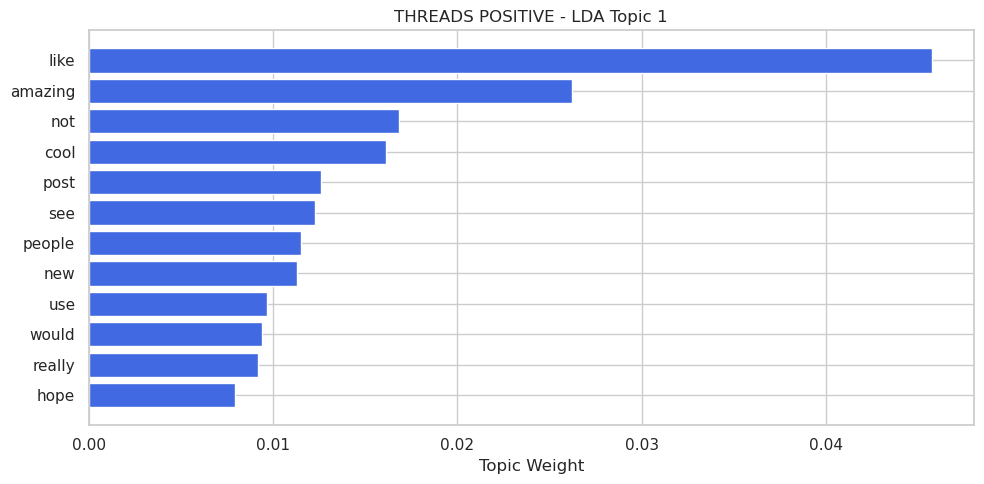

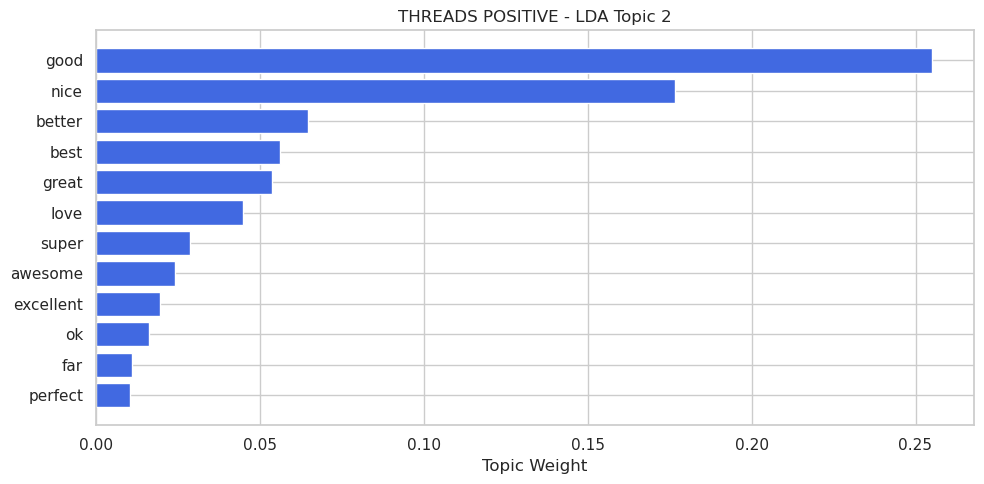

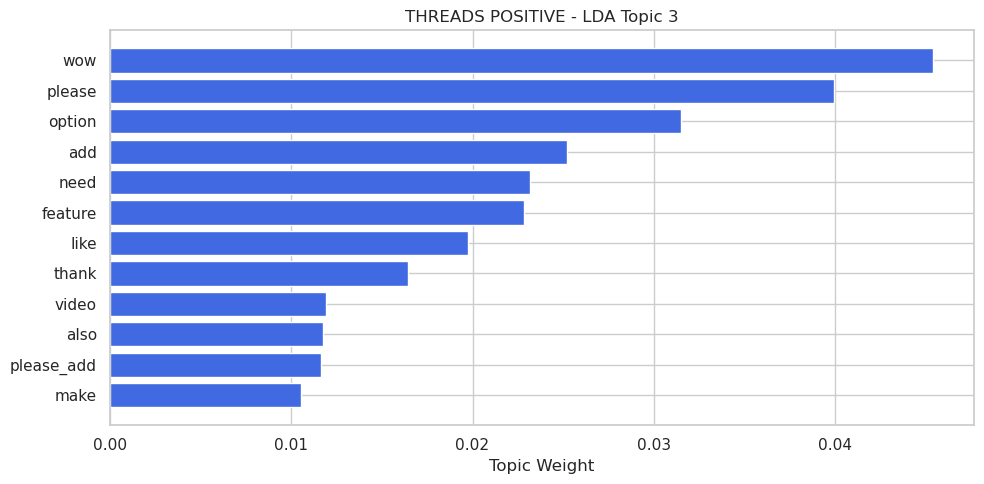


--- VISUALIZING LDA TOPICS: THREADS NEUTRAL ---


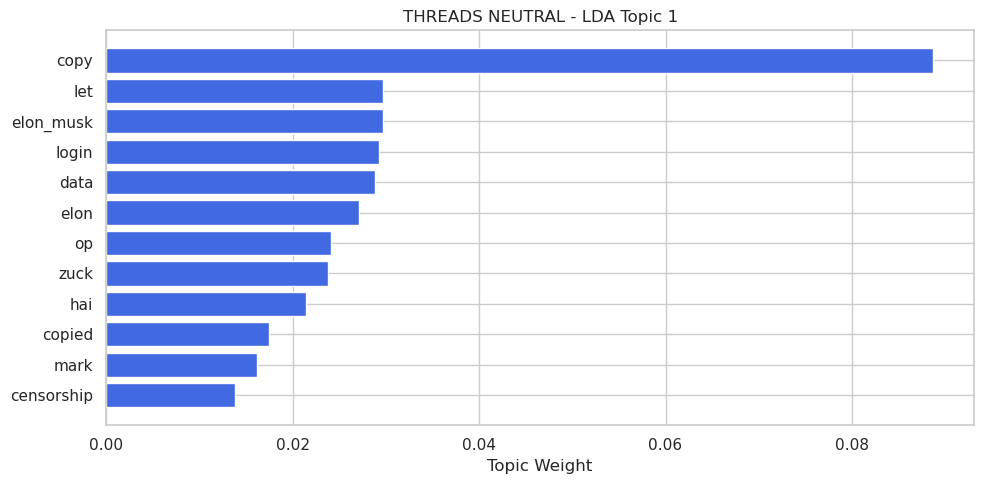

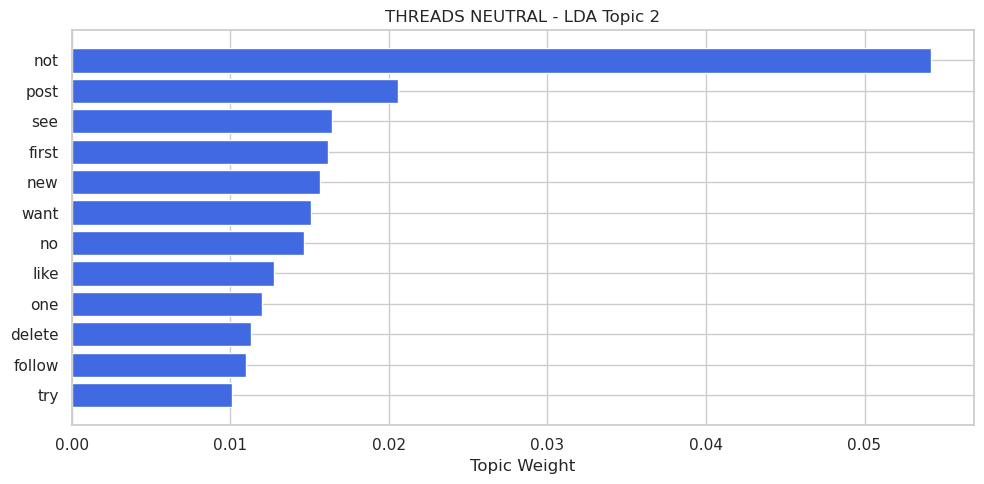

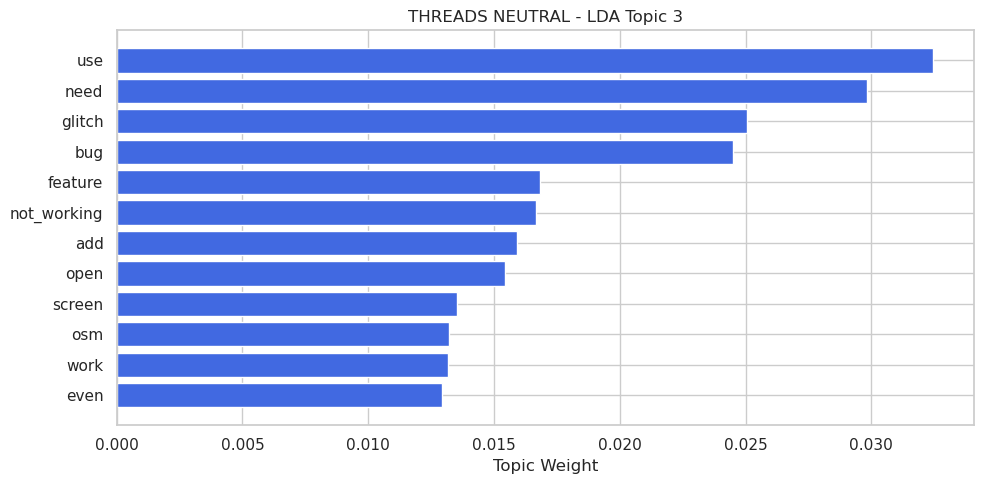


--- VISUALIZING LDA TOPICS: THREADS NEGATIVE ---


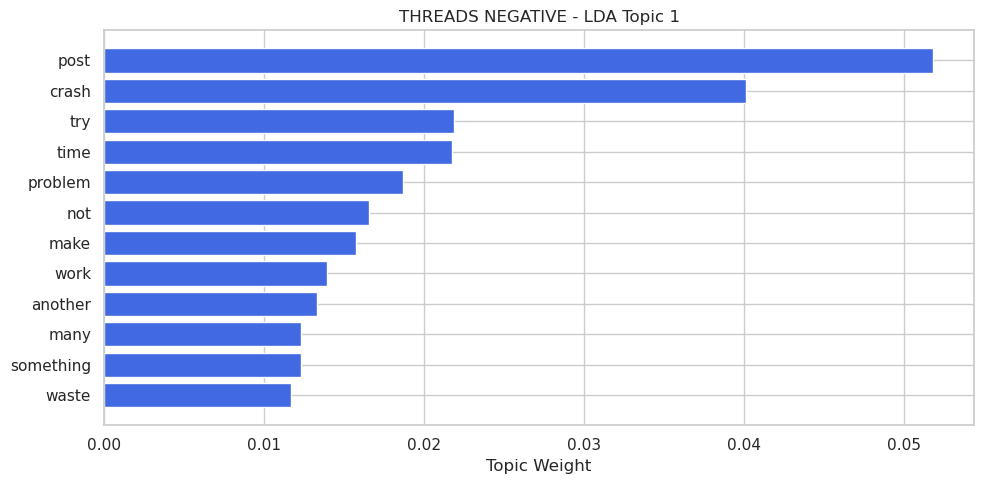

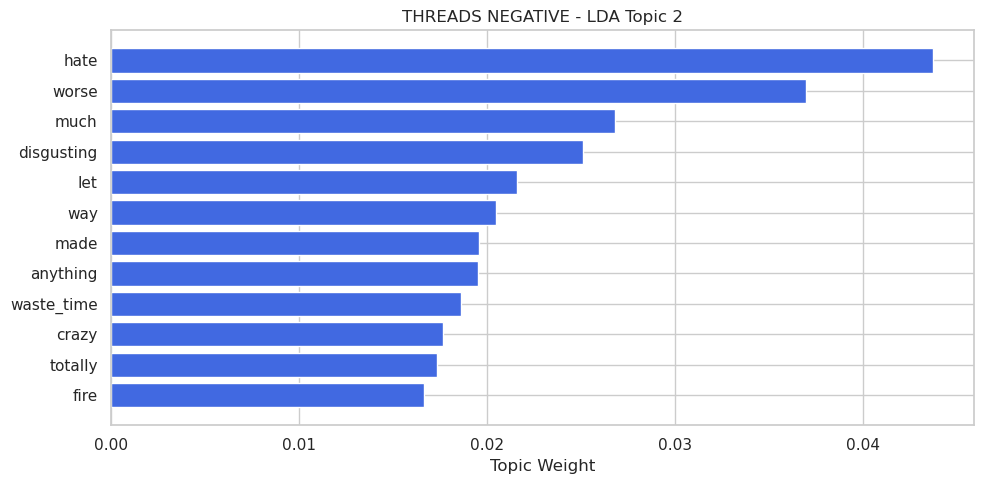

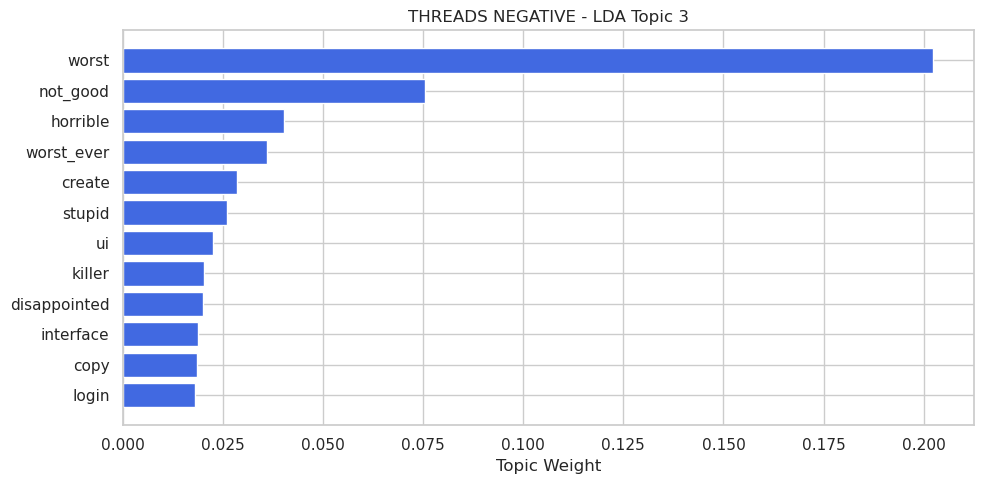

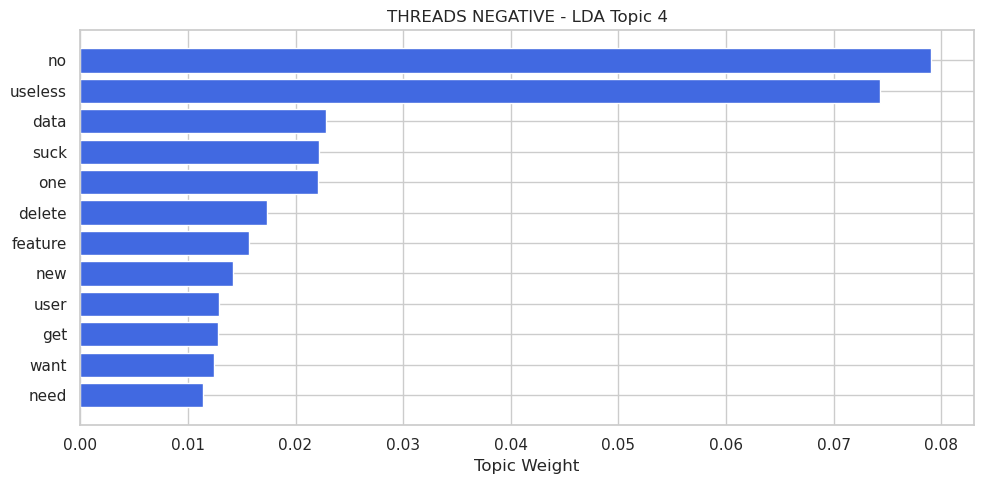

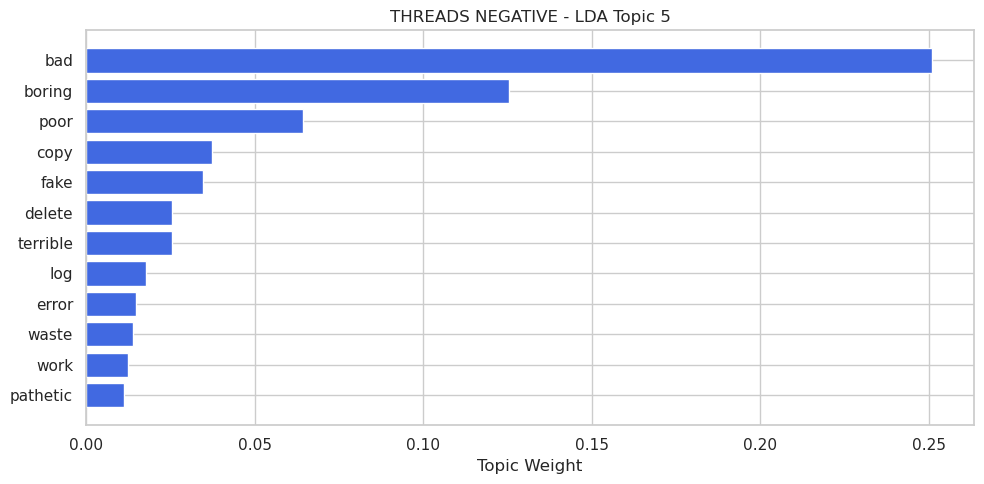

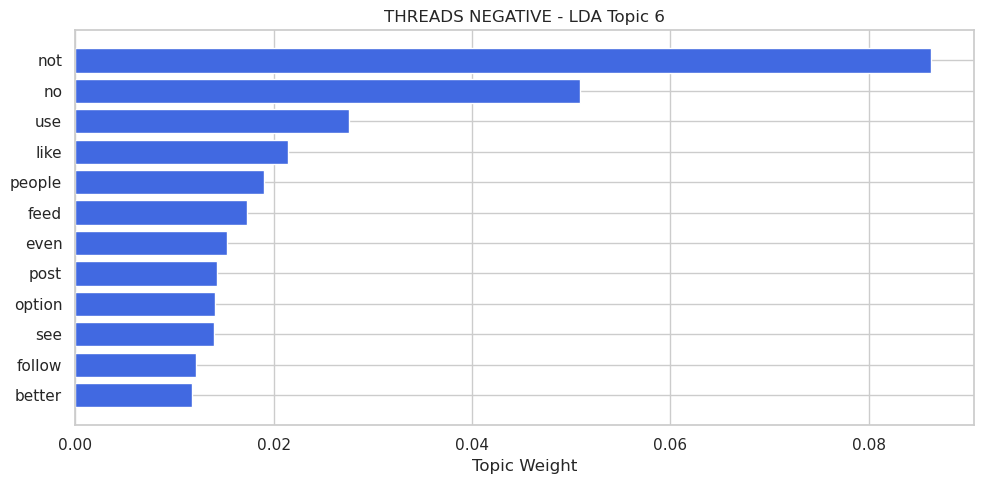

In [78]:


print("\n===== THREADS POSITIVE TOPICS =====")
lda_pos_threads = run_lda_block(threads_pos)
print("\n===== THREADS NEUTRAL TOPICS =====")
lda_neu_threads = run_lda_block(threads_neu)
print("\n===== THREADS NEGATIVE TOPICS =====")
lda_neg_threads = run_lda_block(threads_neg)

visualize_lda_block(lda_pos_threads, "Threads Positive")
visualize_lda_block(lda_neu_threads, "Threads Neutral")
visualize_lda_block(lda_neg_threads, "Threads Negative")


## Twitter LDA analysis


===== TWITTER POSITIVE TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.4794
k=4 Coherence=0.4443
k=5 Coherence=0.4420
k=6 Coherence=0.4499

Best number of topics = 3
Final Coherence Score: 0.4794293027506067
TOPIC 1:
love, tweet, excellent, best_social, please, medium, video, time, keep, see, lmao, new, super, even, post

TOPIC 2:
better, best, nice, awesome, free_speech, amazing, thread, cool, one, ok, much_better, thanks, perfect, facebook, better_thread

TOPIC 3:
good, great, like, elon, not, used, name, change, elon_musk, logo, new, back, really, platform, people


===== TWITTER NEUTRAL TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.4698
k=4 Coherence=0.4581
k=5 Coherence=0.4358
k=6 Coherence=0.4009

Best number of topics = 3
Final Coherence Score: 0.4698141535009441
TOPIC 1:
back, change, name, elon_musk, logo, bring_back, bird, want, old, blue_bird, musk, tf, give, changed, miss

TOPIC 2:
elon, not, new, like, really, update, good, go, thing, one, even, 

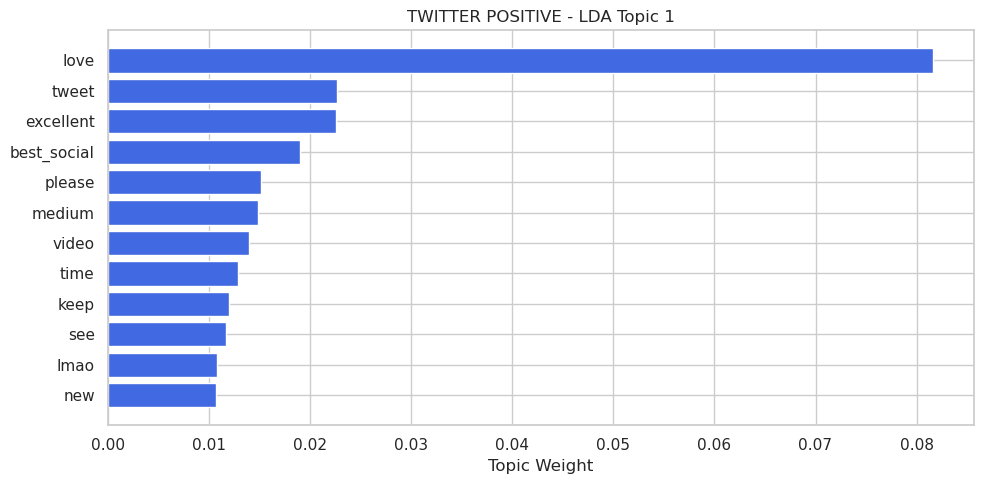

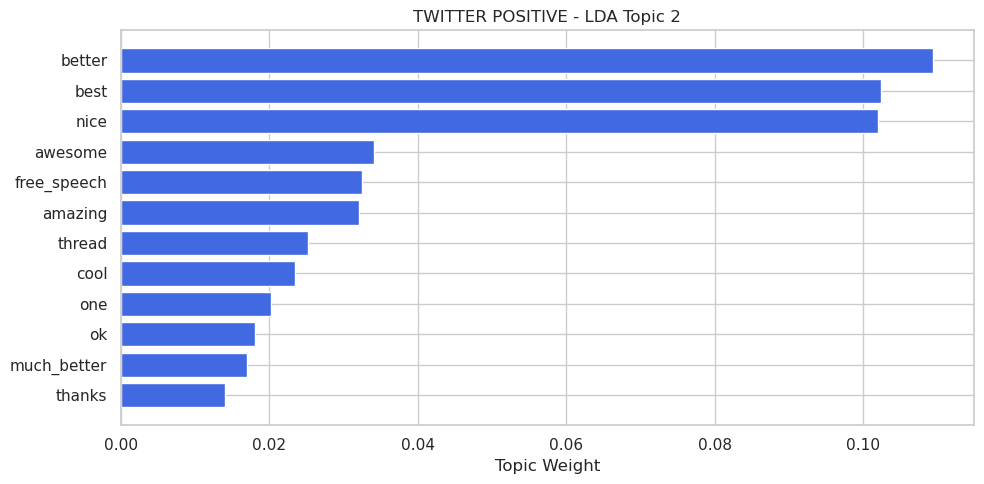

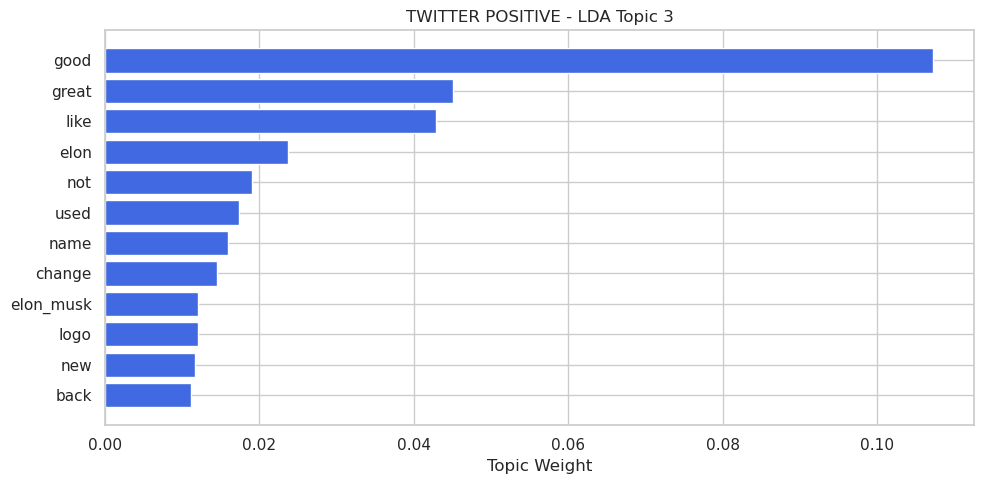


--- VISUALIZING LDA TOPICS: TWITTER NEUTRAL ---


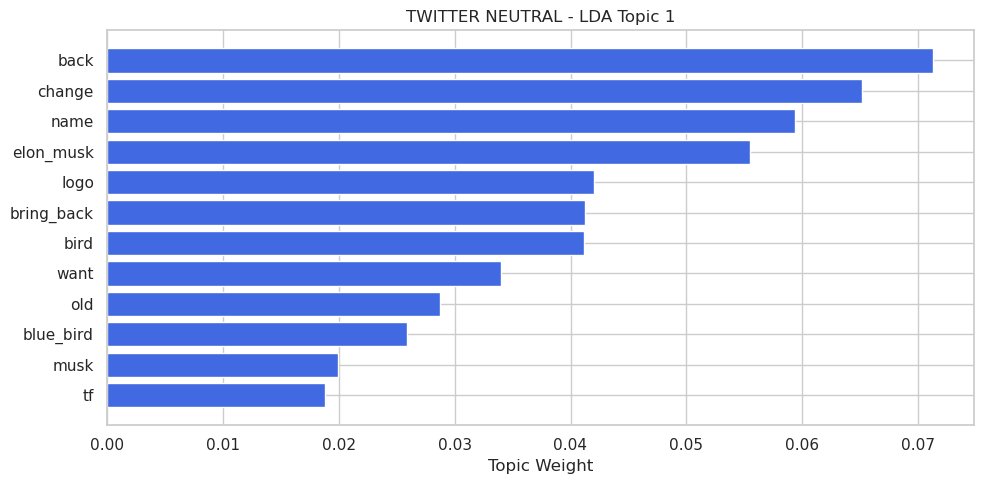

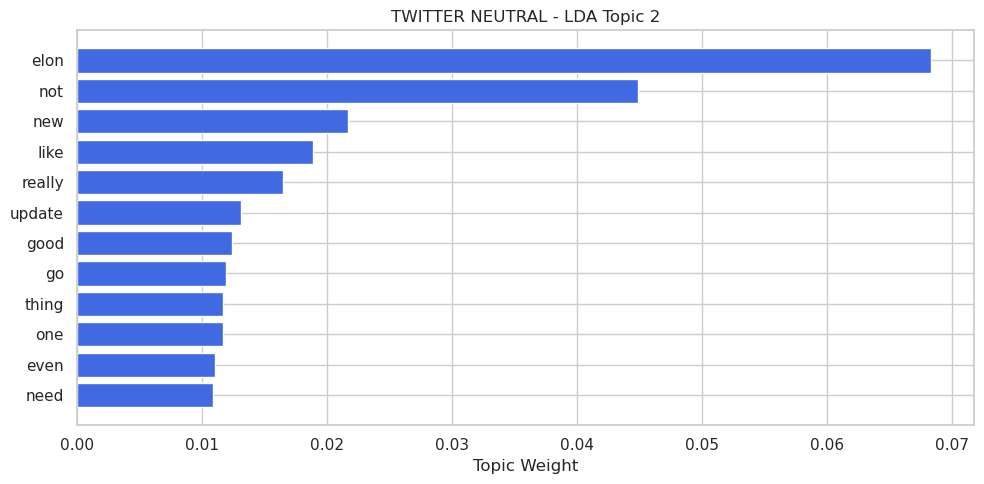

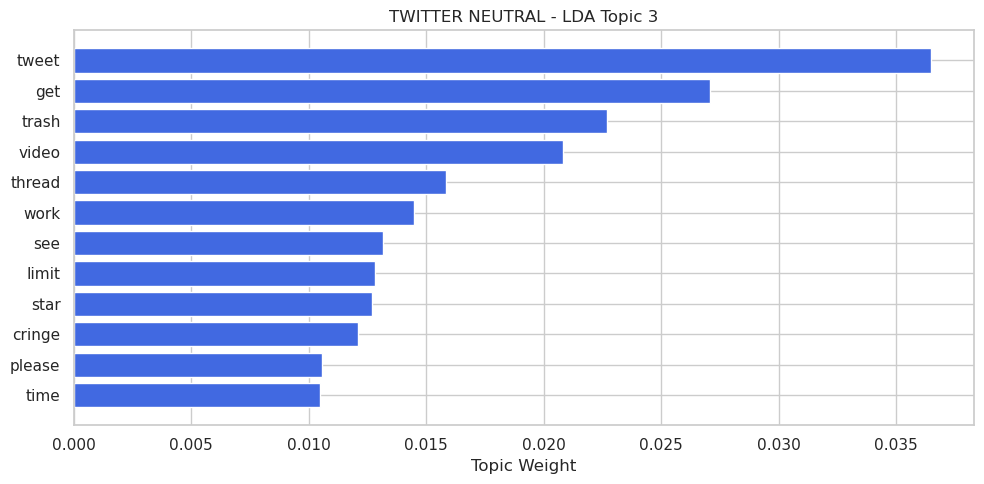


--- VISUALIZING LDA TOPICS: TWITTER NEGATIVE ---


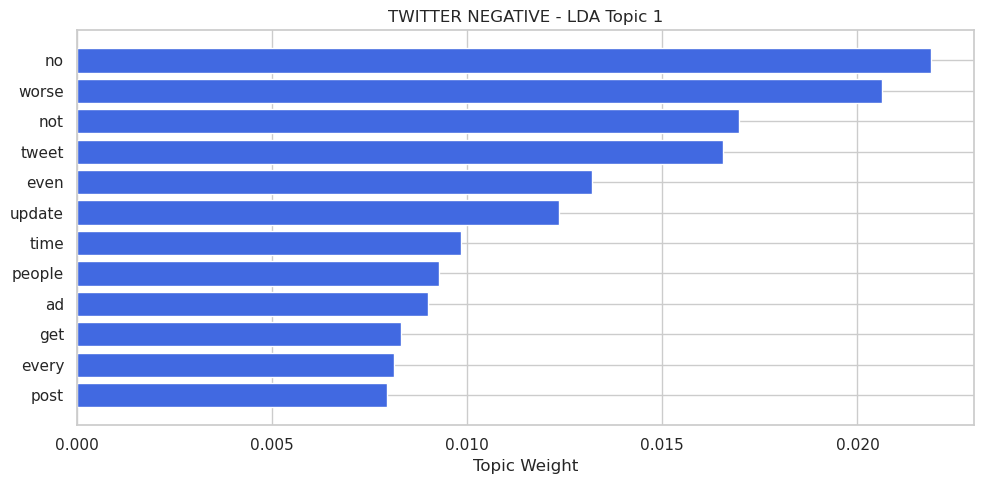

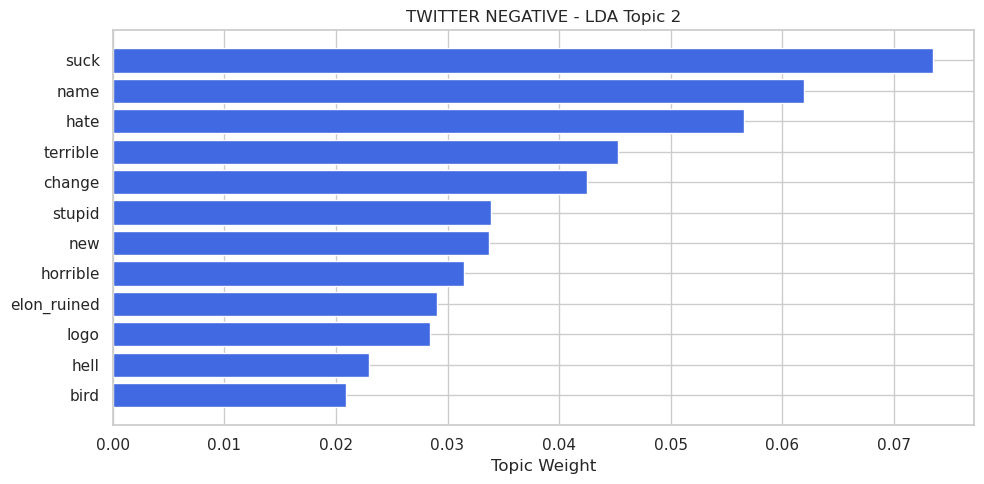

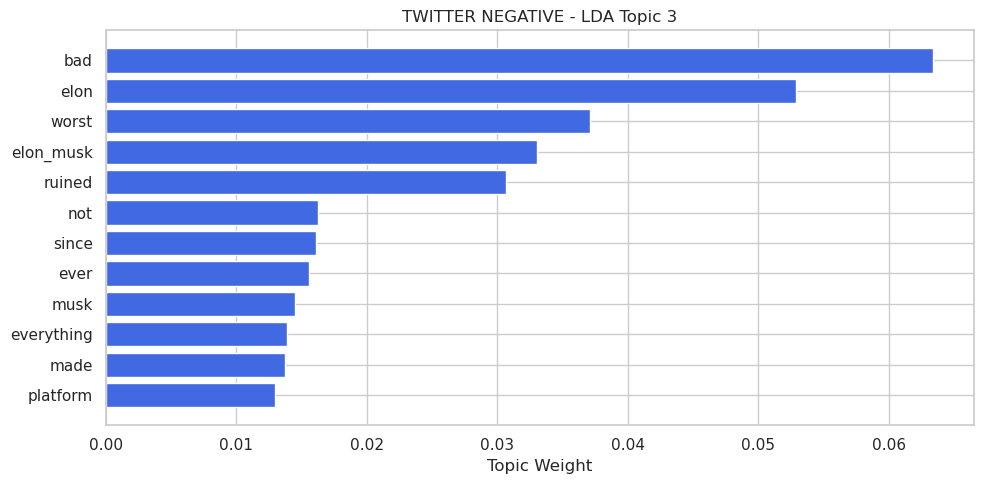

In [79]:
print("\n===== TWITTER POSITIVE TOPICS =====")
lda_pos_twitter = run_lda_block(twitter_pos)

print("\n===== TWITTER NEUTRAL TOPICS =====")
lda_neu_twitter = run_lda_block(twitter_neu)

print("\n===== TWITTER NEGATIVE TOPICS =====")
lda_neg_twitter = run_lda_block(twitter_neg)

visualize_lda_block(lda_pos_twitter, "Twitter Positive")
visualize_lda_block(lda_neu_twitter, "Twitter Neutral")
visualize_lda_block(lda_neg_twitter, "Twitter Negative")


### LDA does a pretty good job in capturing different insights of different topics in positive, negative and neutral sentiments with a great average coherence score of 0.50 efficiently 

## Topic Modelling 2 NMF (using sentiment - pos, neu, neg)

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

def run_nmf(docs_df):
    docs_bigrams = prepare_tm_texts(docs_df)
    docs_text = [" ".join(doc) for doc in docs_bigrams]

    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95,
        min_df=10,
        ngram_range=(1, 1),
    )

    tfidf = tfidf_vectorizer.fit_transform(docs_text)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    dictionary = Dictionary(docs_bigrams)
    dictionary.filter_extremes(no_below=10, no_above=0.5)

    topic_range = range(3, 10)
    coherence_scores = {}

    for k in topic_range:
        nmf_model = NMF(
            n_components=k,
            random_state=42,
            init="nndsvda",
            max_iter=2000
        )
        
        W = nmf_model.fit_transform(tfidf)
        H = nmf_model.components_

        top_words = []
        for topic in H:
            idxs = topic.argsort()[-20:]
            top_words.append([feature_names[i] for i in idxs])

        coherence_model = CoherenceModel(
            topics=top_words,
            texts=docs_bigrams,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence = coherence_model.get_coherence()
        coherence_scores[k] = coherence
        print(f"k={k} Coherence={coherence:.4f}")

    best_k = max(coherence_scores, key=coherence_scores.get)
    print("\nBest number of NMF topics =", best_k)

    final_nmf = NMF(
        n_components=best_k,
        random_state=42,
        init="nndsvda",
        max_iter=400
    )

    W_final = final_nmf.fit_transform(tfidf)
    H_final = final_nmf.components_

    print("\n--- FINAL NMF TOPIC WORDS ---\n")
    for idx, topic in enumerate(H_final):
        indices = topic.argsort()[-15:]
        words = [feature_names[i] for i in indices]
        print(f"TOPIC {idx+1}: {', '.join(words)}")

    return final_nmf, feature_names



def run_nmf_block(df_input):
    print("\n===== RUNNING NMF BLOCK =====")
    return run_nmf(df_input)
# nmf_pos, pos_feats = run_nmf(threads_pos)

# print("\n===== NMF THREADS NEUTRAL =====")
# nmf_neu, neu_feats = run_nmf(threads_neu)

# print("\n===== NMF THREADS NEGATIVE =====")
# nmf_neg, neg_feats = run_nmf(threads_neg)




So the final insights for **NMF topic modelling** and topics for different sentiments could be categorised as:

---

**Positive Sentiment Analysis** with a coherence score of **k=6 Coherence=0.5355**


**1. General Impressions & Usability** — *look, work, new, pretty, think, feature, use, need, job*  
Users’ general impressions about the app and how they use basic features.

**2. UI Appreciation & Feature Praise** — *thanks, interface, download, ui, platform, wow, nice*  
Focused appreciation for the interface, design, and available features.

**3. Comparison With Twitter / Elon Musk** — *hope, tweeter, could, elon, elon_musk, feature, better*  
Mentions of Twitter, Elon Musk, and perceived improvements or differences.

**4. Social Platform Comparison / Alternatives** — *copy, alternative, social, world, platform, best*  
Observations about Threads as an alternative to other social platforms.

**5. New App Potential & Improvements** — *look, think, job, start, alternative, really, great*  
Users noting potential improvements and new opportunities in the app.

**6. Excitement & Enthusiasm** — *awesome, cool, super, wow, love, amazing*  
Strong positive emotions and excitement towards the app and its features.

**Insight:** Positive users appreciate the app’s interface and features, but they also notice potential improvements and compare Threads with other platforms.

---

**Neutral Sentiment Analysis** with a coherence score of **k=5 Coherence=0.5237**

**1. Commentary on Elon/Zuckerberg Rivalry** — *trash, absolute, elon_musk, mark, zuck, copy*  
Neutral discussions mentioning key figures and platform comparisons without strong opinions.

**2. Install / Login / Delete Actions** — *download, delete, login, opening, even, work*  
Technical actions users perform while using the app, reported neutrally.

**3. Basic App Usage & Navigation** — *follow, login, want, post, new, use*  
Descriptive mentions of navigating and using the platform.

**4. Cloning / Similarity Observations** — *zuck, clone, copy_cat, idea, copy_paste*  
Observations about similarities with other platforms.

**5. Neutral Mentions of Bugs / Glitches** — *scroll, glitching, bug, not_working, fix*  
Reports of minor technical issues without emotional tone.

**Insight:** Neutral users provide informative feedback, revealing technical behaviors, minor issues, and observations about platform similarities.

---

**Negative Sentiment Analysis** with a coherence score of **k=8 Coherence=0.4115**

**1. Poor Performance & UI Issues** — *poor, glitch, interface, copy, bad*  
Complaints about app performance, glitches, and UI issues.

**2. Privacy Concerns & App Worthlessness** — *social, privacy, waste_time, worst, copy*  
Critiques focused on privacy concerns and perceived lack of value.

**3. Strong Negative Criticism / Frustration** — *pathetic, stupid, useless, totally, waste_time*  
Frustrated users expressing strong negative sentiment about the app.

**4. Missing Features & Privacy Options** — *data, free_speech, privacy, no option*  
Negative mentions of missing features or privacy-related limitations.

**5. Low-Quality Copying / Bad Design** — *copying, cheap, interface, not_good*  
Criticism of design, copying behavior, and low-quality implementation.

**6. Unoriginal / Boring App Version** — *nothing_new, poor, boring, version*  
Negative reactions to unoriginal or boring aspects of the app.

**7. Negative Feed/User Experience** — *user, feed, delete, want, not*  
Complaints about feed, content visibility, and overall user experience.

**8. Crashes & Reliability Problems** — *problem, crash, everytime, upload, open*  
Frustration regarding app crashes and reliability issues.

**Insight:** Negative users have legitimate grievances—bugs, crashes, privacy concerns, and weak user experience—not just complaints.


### Visulaizing the Topics in pos, neu, neg (NMF)

In [81]:
import matplotlib.pyplot as plt

def plot_topic(words, weights, title):
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], weights[::-1], color='royalblue')
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

def visualize_nmf_topics(nmf_model, feature_names, sentiment_label):
    print(f"\n--- VISUALIZING NMF TOPICS: {sentiment_label.upper()} ---")
    
    H = nmf_model.components_

    for idx, topic in enumerate(H):
        top_idx = topic.argsort()[-15:][::-1]
        words = [feature_names[i] for i in top_idx]
        weights = [topic[i] for i in top_idx]

        title = f"{sentiment_label.upper()} - NMF Topic {idx+1}"
        plot_topic(words, weights, title)

def visualize_nmf_block(nmf_model, feature_names, sentiment_label):
    visualize_nmf_topics(nmf_model, feature_names, sentiment_label)


# visualize_nmf_topics(nmf_pos, pos_feats, "Positive")
# visualize_nmf_topics(nmf_neu, neu_feats, "Neutral")
# visualize_nmf_topics(nmf_neg, neg_feats, "Negative")


## NMF Threads Analysis


===== NMF THREADS POSITIVE =====

===== RUNNING NMF BLOCK =====
k=3 Coherence=0.4715
k=4 Coherence=0.5146
k=5 Coherence=0.5268
k=6 Coherence=0.5413
k=7 Coherence=0.5376
k=8 Coherence=0.4974
k=9 Coherence=0.4885

Best number of NMF topics = 6

--- FINAL NMF TOPIC WORDS ---

TOPIC 1: option, work, new, think, pretty, use, feature, job, aap, need, like, really, one, far, good
TOPIC 2: add, interface, download, ui, see, platform, feature, new, work, really, one, like, wow, aap, nice
TOPIC 3: hope, tweeter, could, not, make, would, still, elon_musk, elon, feature, think, like, far, way, better
TOPIC 4: copy, alternative, new, social, think, use, feature, far, world, aap, platform, like, social_medium, one, best
TOPIC 5: work, think, one, would, not, job, new, start, alternative, really, need, feature, far, like, great
TOPIC 6: not, need, post, would, much, super, cool, new, feature, wow, far, really, like, amazing, love

===== NMF THREADS NEUTRAL =====

===== RUNNING NMF BLOCK =====
k=3 Co

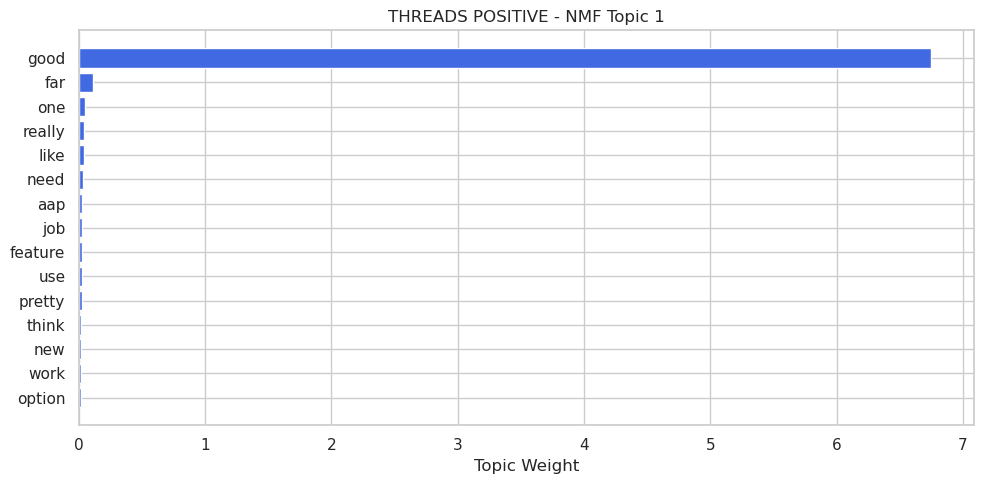

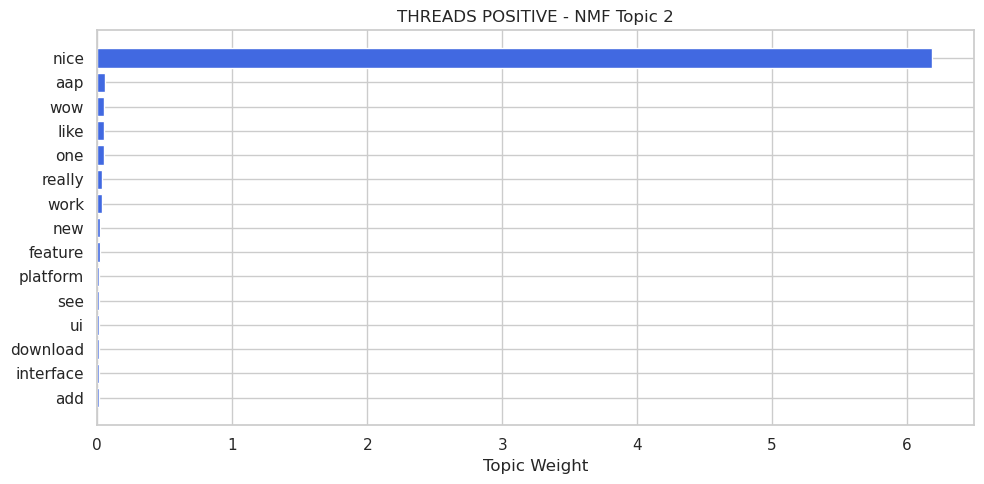

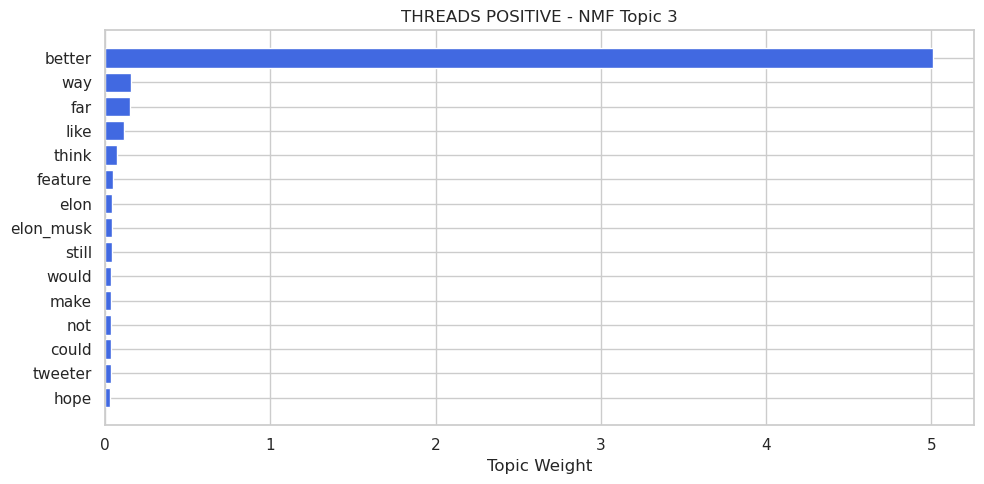

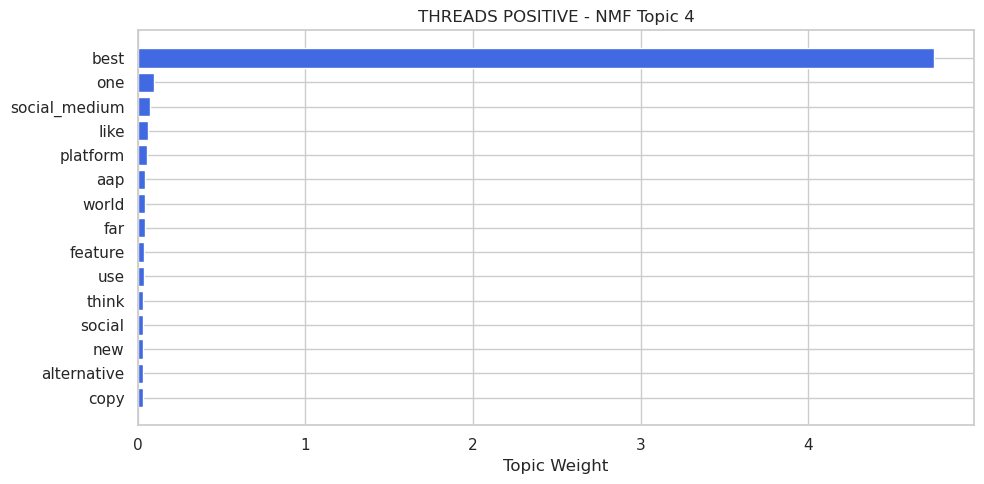

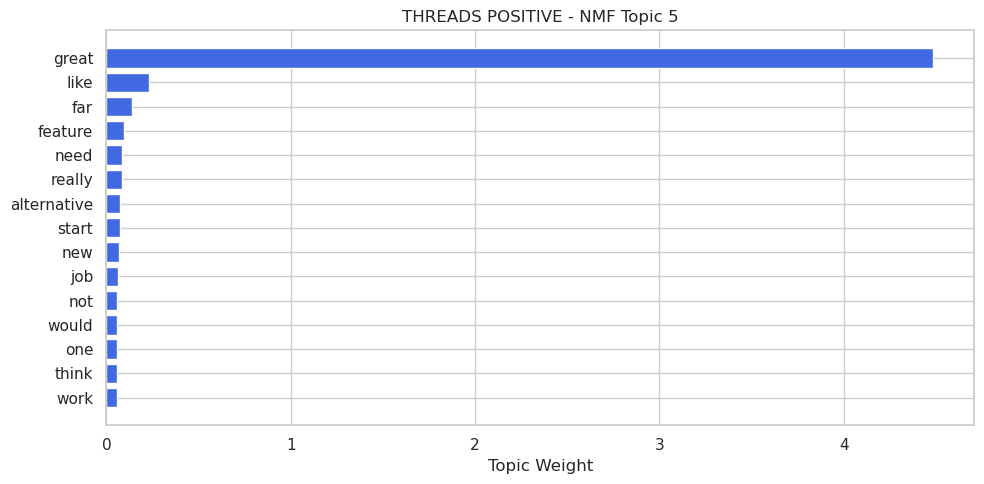

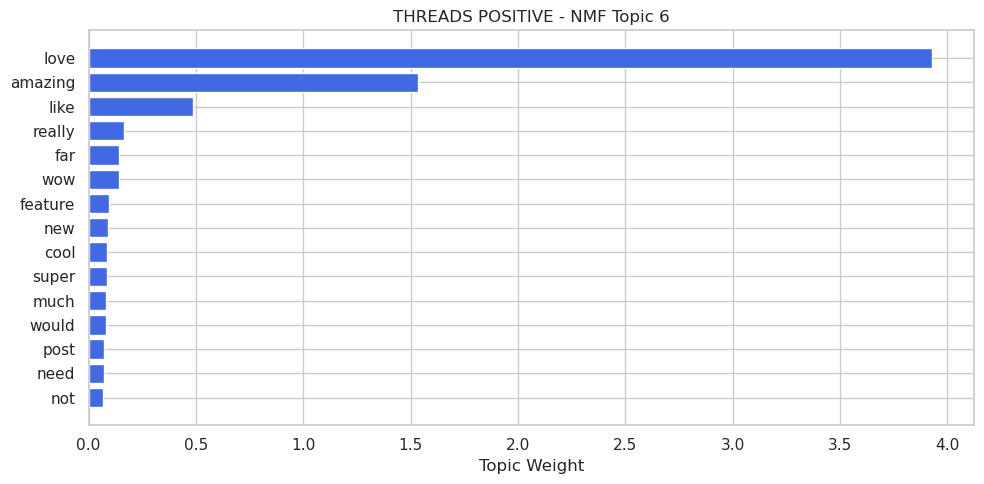


--- VISUALIZING NMF TOPICS: THREADS NEUTRAL ---


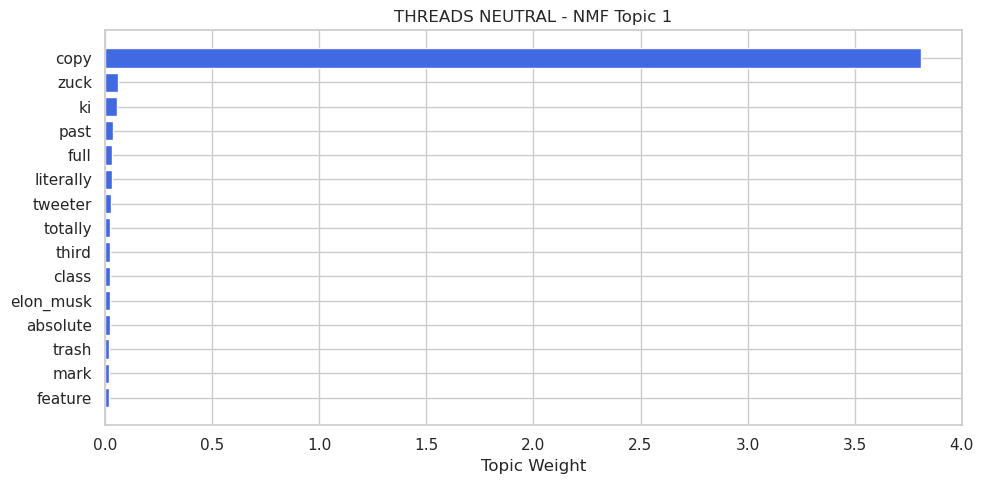

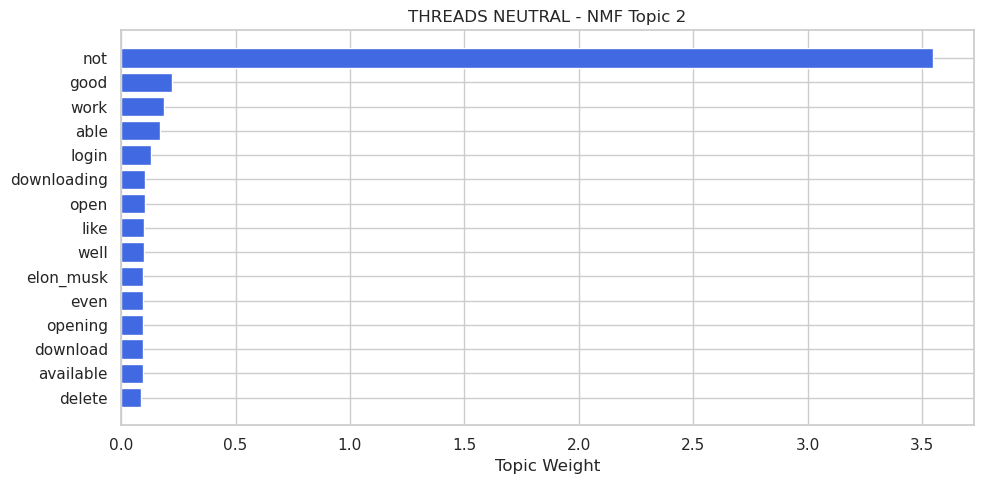

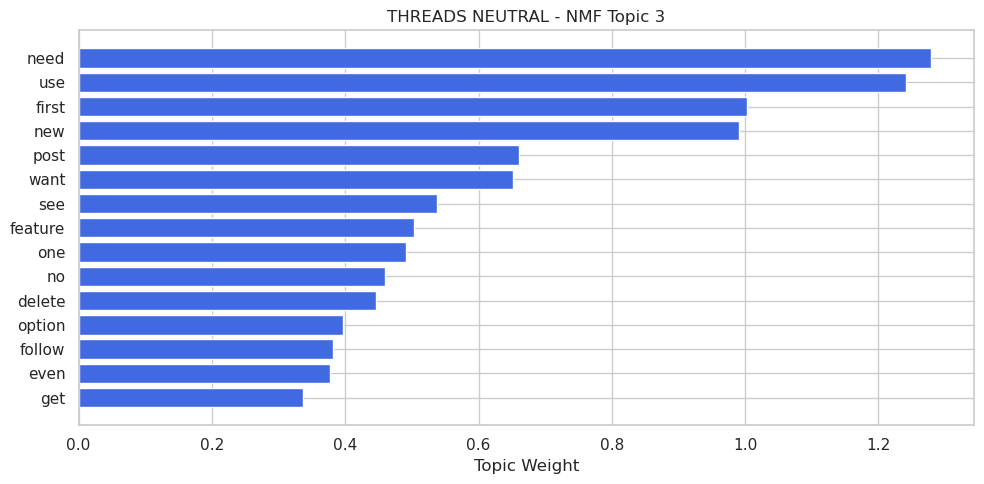

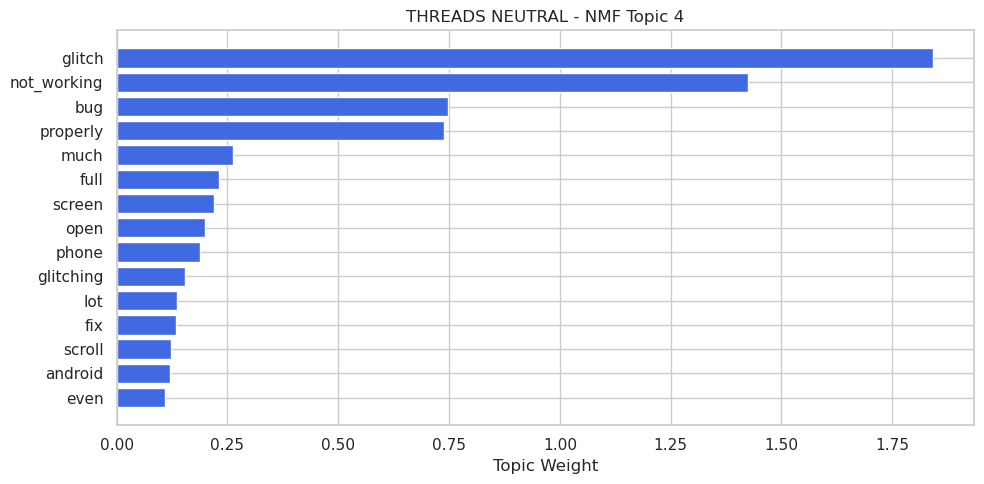


--- VISUALIZING NMF TOPICS: THREADS NEGATIVE ---


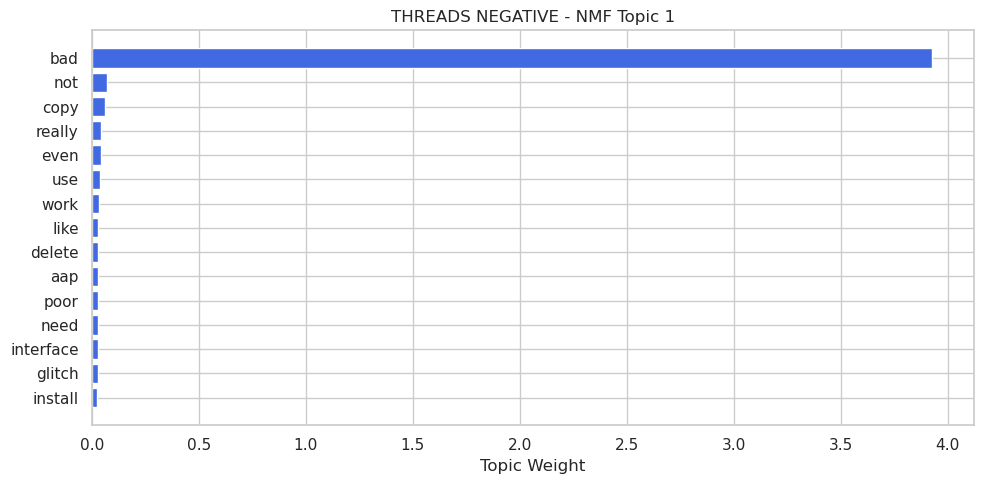

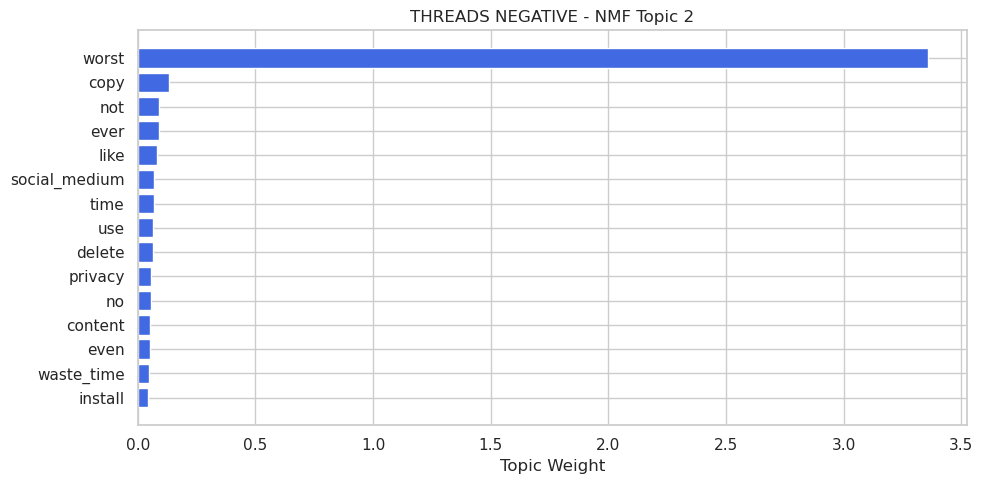

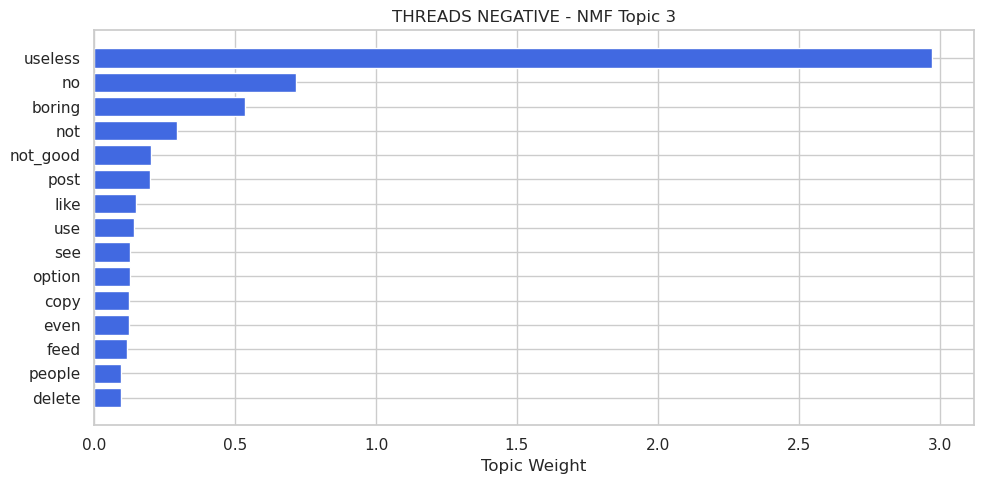

In [82]:
print("\n===== NMF THREADS POSITIVE =====")
nmf_pos, pos_feats = run_nmf_block(threads_pos)

print("\n===== NMF THREADS NEUTRAL =====")
nmf_neu, neu_feats = run_nmf_block(threads_neu)

print("\n===== NMF THREADS NEGATIVE =====")
nmf_neg, neg_feats = run_nmf_block(threads_neg)

visualize_nmf_block(nmf_pos, pos_feats, "Threads Positive")
visualize_nmf_block(nmf_neu, neu_feats, "Threads Neutral")
visualize_nmf_block(nmf_neg, neg_feats, "Threads Negative")


## Twitter NMF Analysis


===== NMF TWITTER POSITIVE =====

===== RUNNING NMF BLOCK =====
k=3 Coherence=0.4199
k=4 Coherence=0.4367
k=5 Coherence=0.4573
k=6 Coherence=0.4487
k=7 Coherence=0.4323
k=8 Coherence=0.4409
k=9 Coherence=0.4353

Best number of NMF topics = 5

--- FINAL NMF TOPIC WORDS ---

TOPIC 1: thing, not, information, news, pretty, work, one, social_medium, far, really, elon, platform, like, used, good
TOPIC 2: people, thread, super, easy_use, aap, like, elon, update, name, platform, really, logo, experience, one, nice
TOPIC 3: awesome, new, like, free_speech, update, not, elon_musk, better, news, elon, platform, used, work, experience, great
TOPIC 4: still, experience, ever, better, name, free_speech, news, like, elon, thread, world, platform, one, elon_musk, best
TOPIC 5: thread, name, platform, much, used, excellent, not, elon_musk, free_speech, really, new, better, like, elon, love

===== NMF TWITTER NEUTRAL =====

===== RUNNING NMF BLOCK =====
k=3 Coherence=0.3880
k=4 Coherence=0.4540
k=5 Co

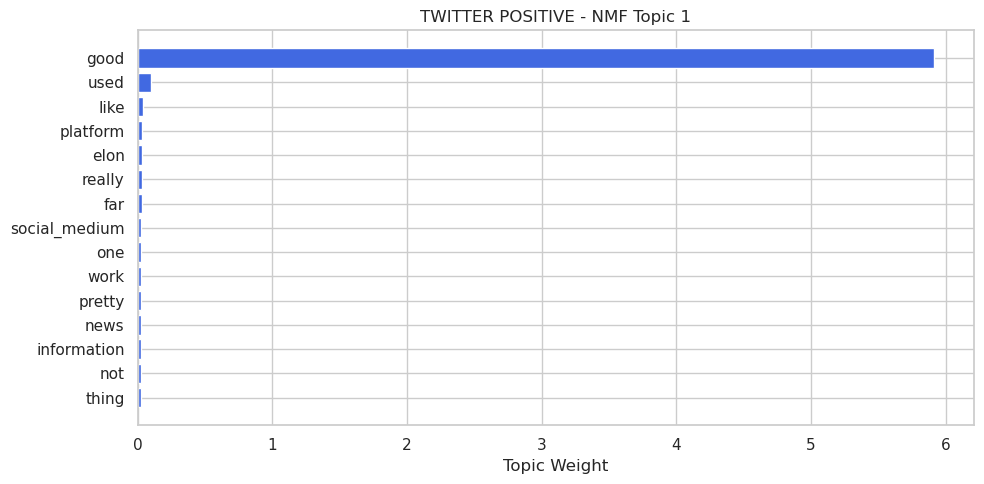

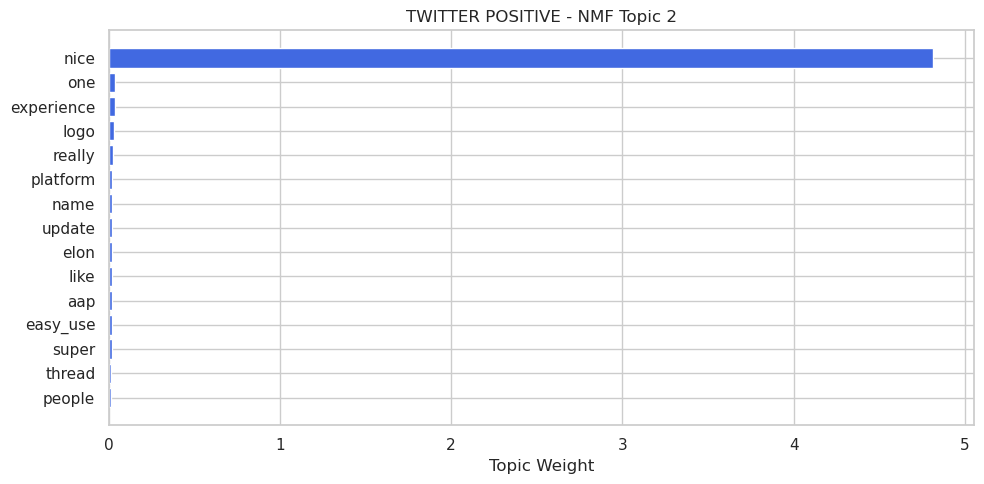

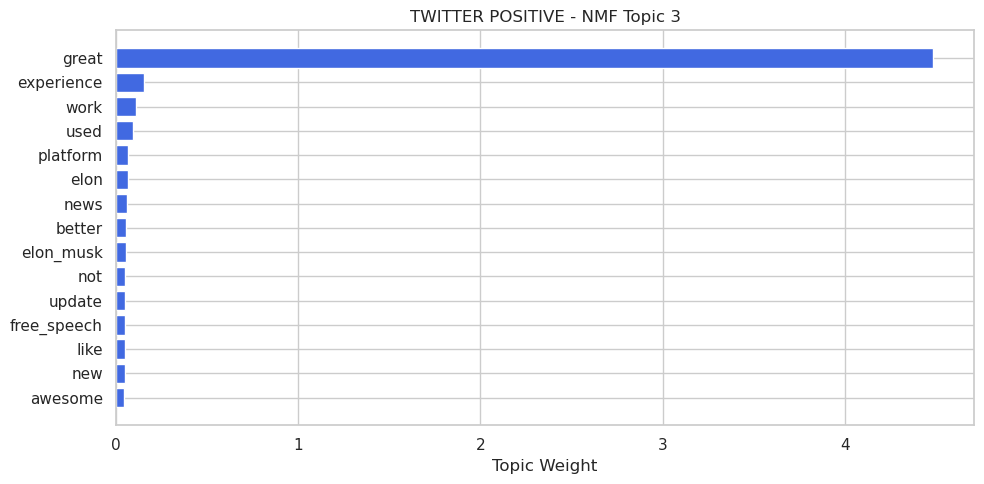

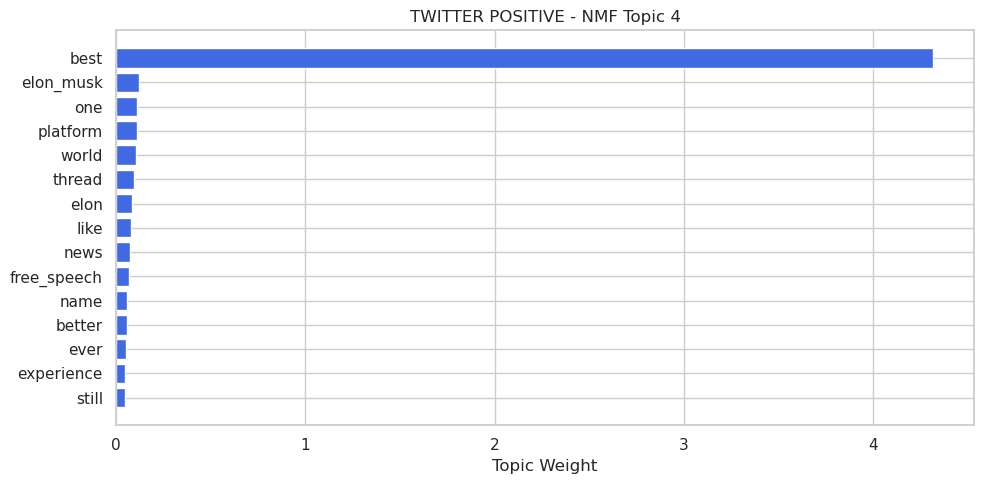

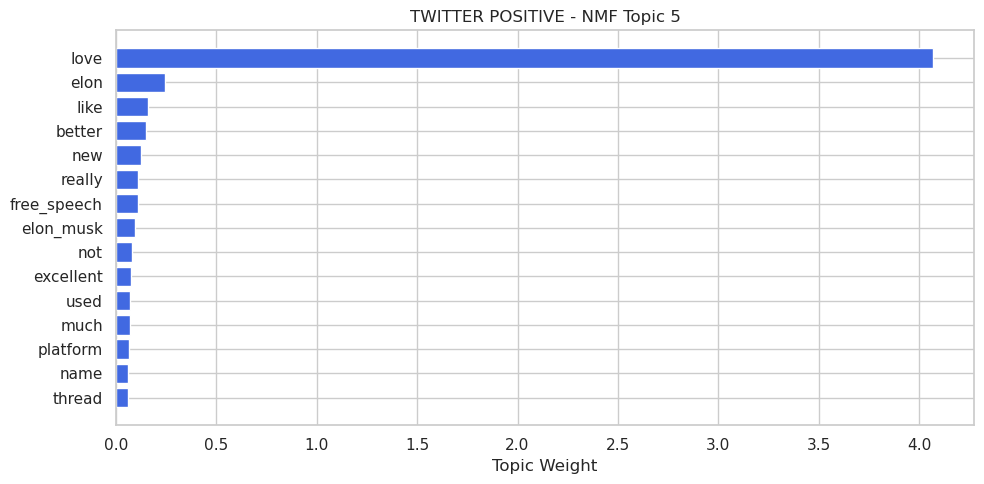


--- VISUALIZING NMF TOPICS: TWITTER NEUTRAL ---


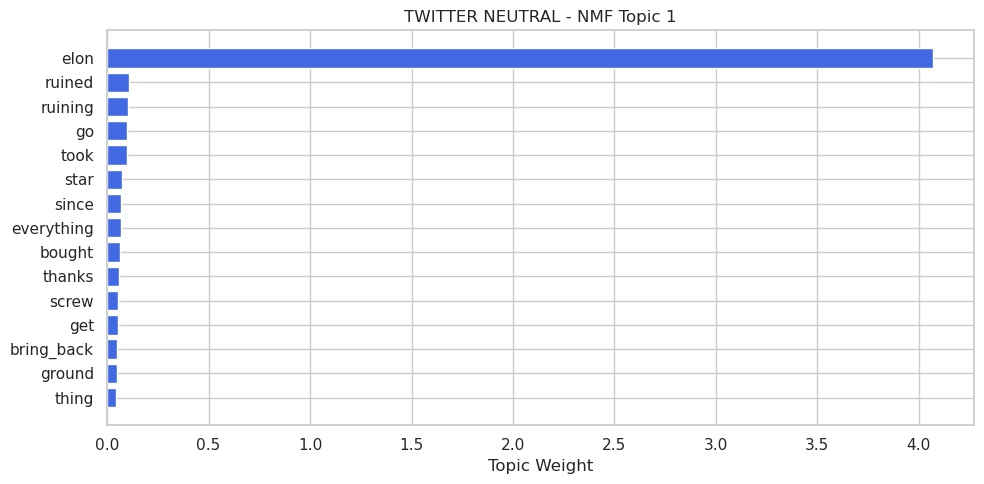

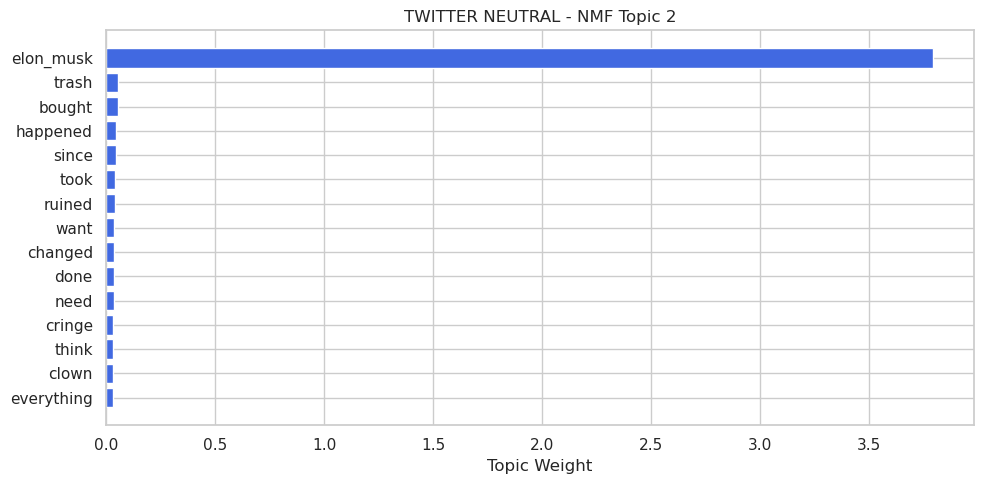

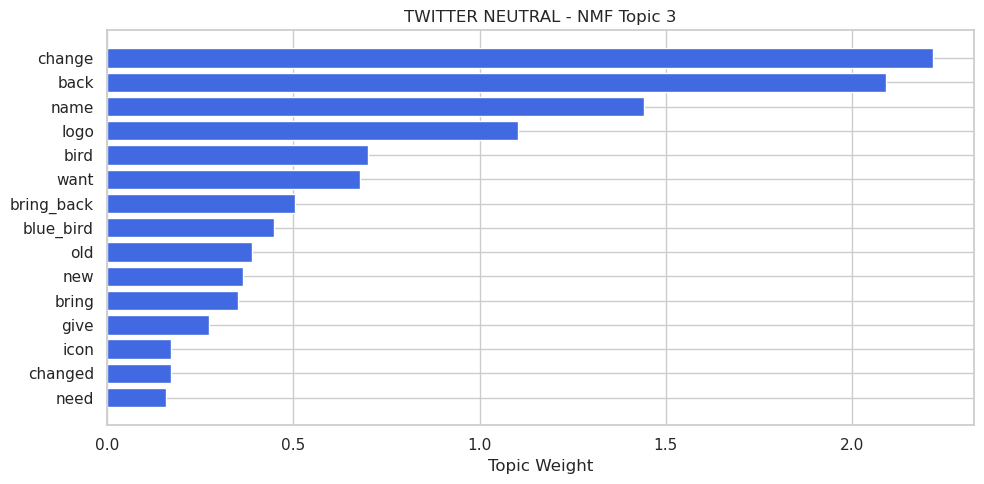

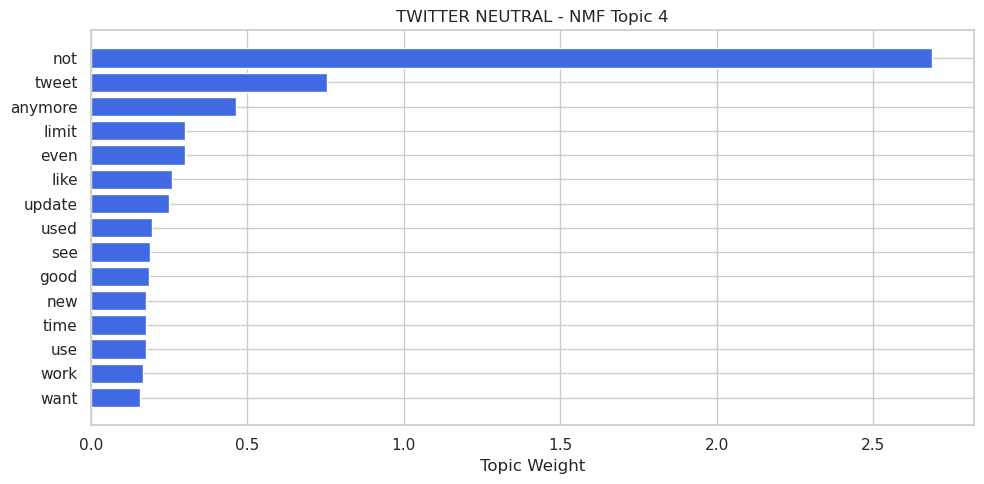


--- VISUALIZING NMF TOPICS: TWITTER NEGATIVE ---


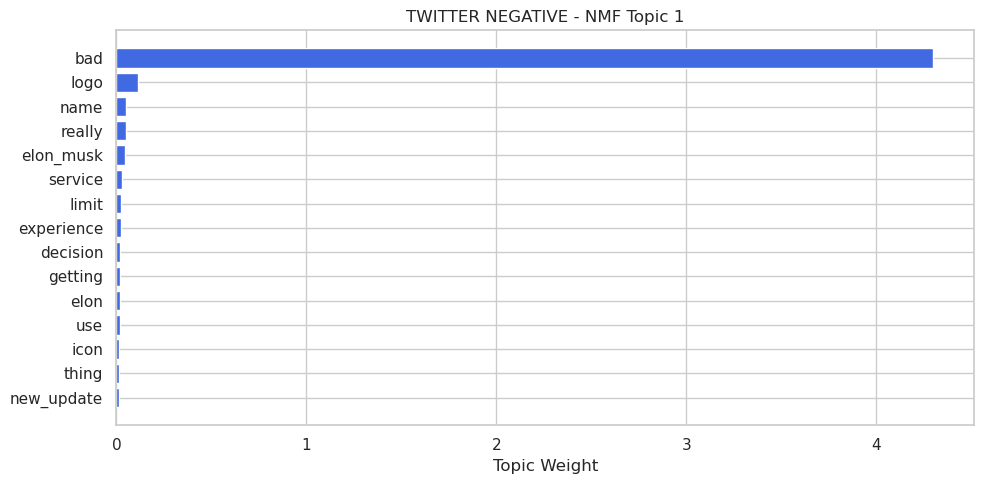

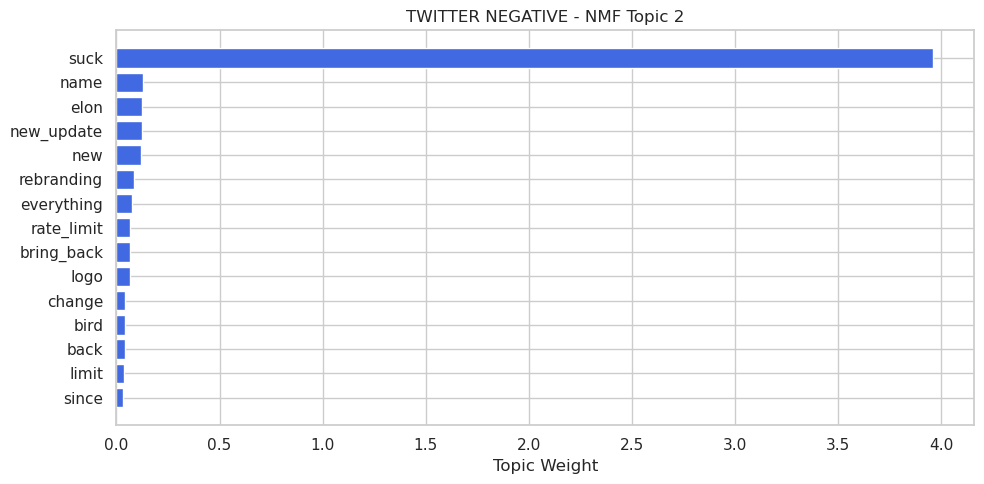

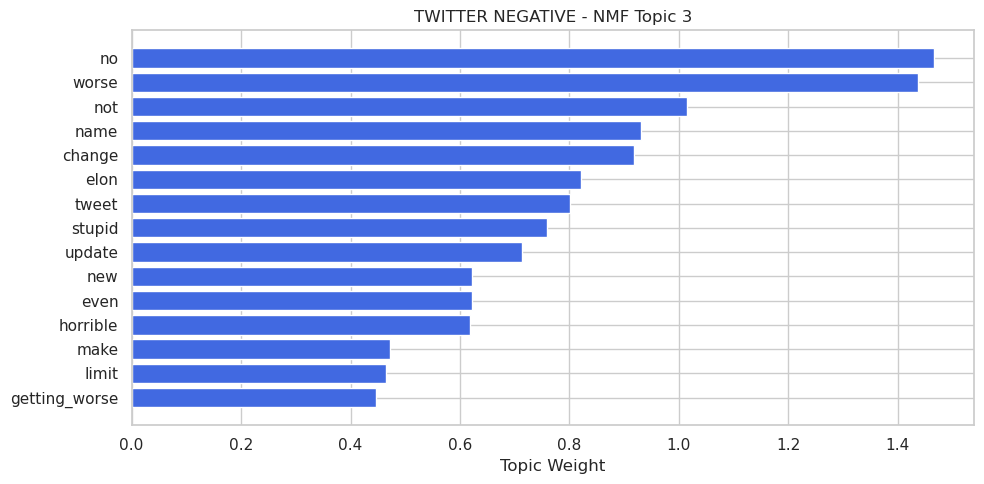

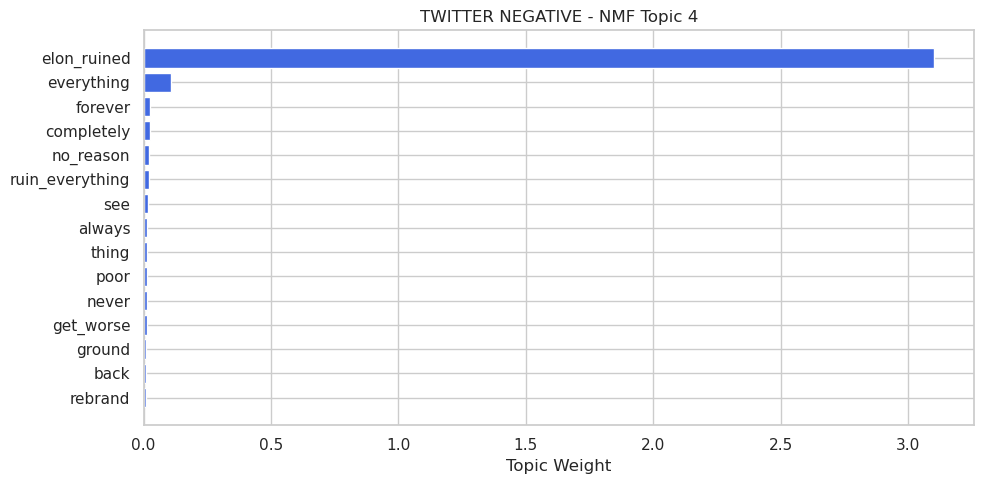

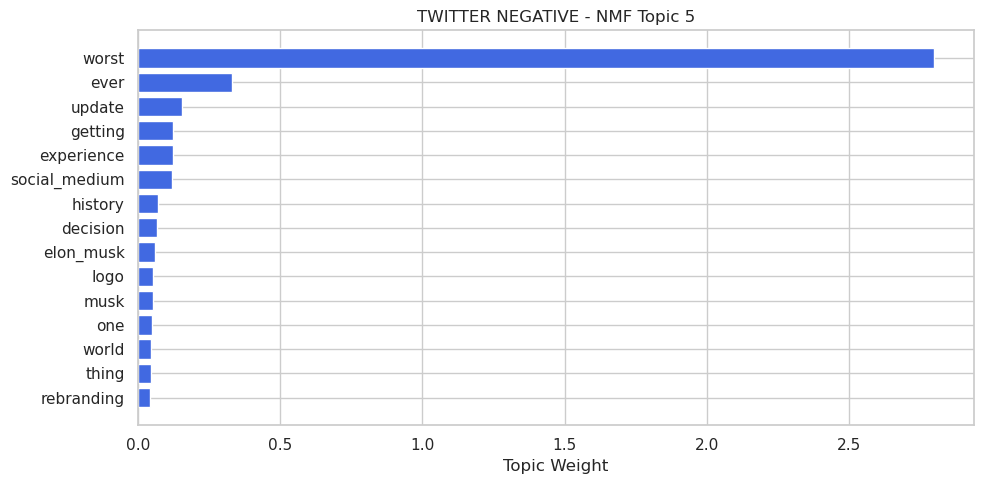

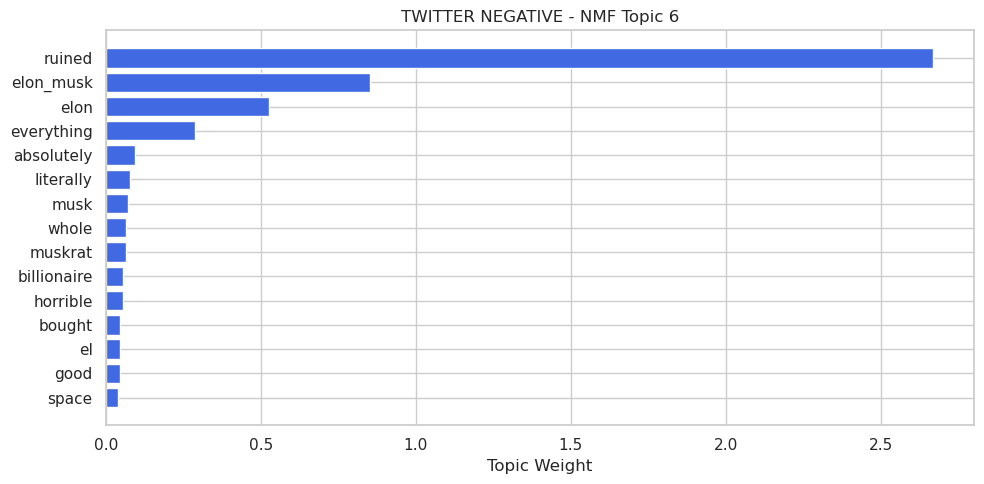

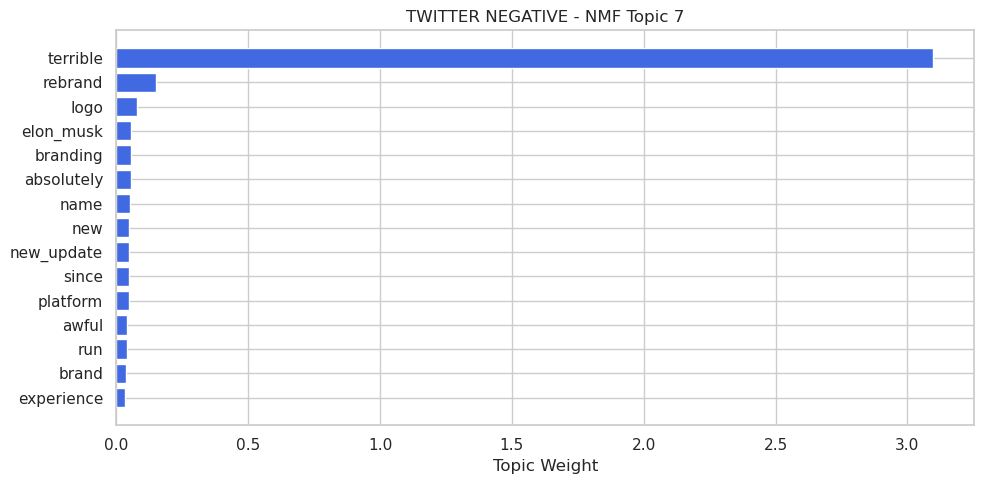

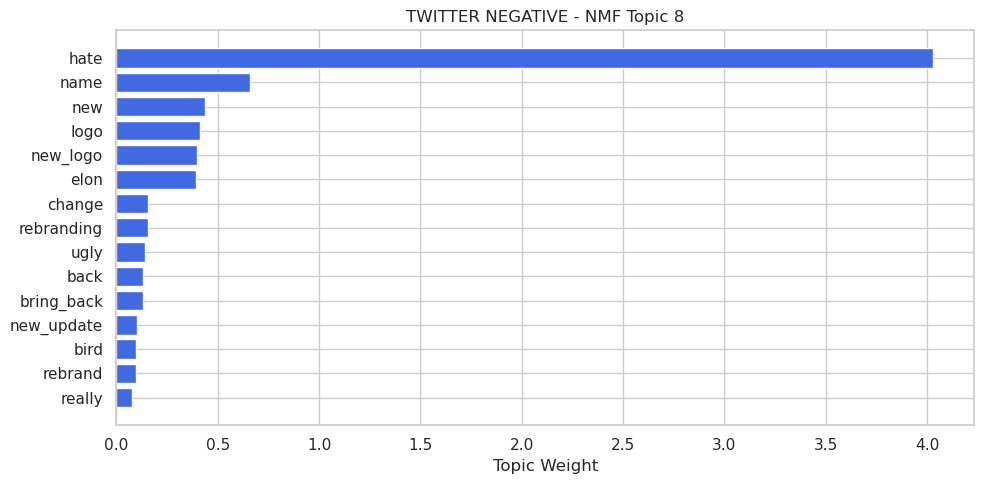

In [83]:
print("\n===== NMF TWITTER POSITIVE =====")
nmf_pos_tw, pos_feats_tw = run_nmf_block(twitter_pos)

print("\n===== NMF TWITTER NEUTRAL =====")
nmf_neu_tw, neu_feats_tw = run_nmf_block(twitter_neu)

print("\n===== NMF TWITTER NEGATIVE =====")
nmf_neg_tw, neg_feats_tw = run_nmf_block(twitter_neg)

visualize_nmf_block(nmf_pos_tw, pos_feats_tw, "Twitter Positive")
visualize_nmf_block(nmf_neu_tw, neu_feats_tw, "Twitter Neutral")
visualize_nmf_block(nmf_neg_tw, neg_feats_tw, "Twitter Negative")


### Though NMF and LDA find similar insights from the sentiments, the negative coherence score for NMF is too low making it on an average less effective than LDA . But overall it gives a good decomposition of the topics from the document.

## BERTopic  - remove this later

In [84]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
'''
# Sentiment splits
positive_df = df[df["sentiment"] == "positive"].copy()
neutral_df  = df[df["sentiment"] == "neutral"].copy()
negative_df = df[df["sentiment"] == "negative"].copy()

positive_texts = positive_df["review_description"].tolist()
neutral_texts  = neutral_df["review_description"].tolist()
negative_texts = negative_df["review_description"].tolist()

print("Counts:", len(positive_texts), len(neutral_texts), len(negative_texts))

# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def run_bertopic(texts, min_topic_size=20):
    embeddings = embedding_model.encode(texts, show_progress_bar=True)
    model = BERTopic(
        language="english",
        umap_model=None,
        min_topic_size=min_topic_size,
        top_n_words=15,
        calculate_probabilities=True,
        verbose=True
    )
    topics, probs = model.fit_transform(texts, embeddings)
    return model, topics, probs, embeddings

print("Running BERTopic on positive reviews...")
pos_model, pos_topics5, pos_probs5, pos_embeddings = run_bertopic(positive_texts, min_topic_size=20)

print("Running BERTopic on neutral reviews...")
neu_model, neu_topics5, neu_probs5, neu_embeddings = run_bertopic(neutral_texts, min_topic_size=20)

print("Running BERTopic on negative reviews...")
neg_model, neg_topics5, neg_probs5, neg_embeddings = run_bertopic(negative_texts, min_topic_size=20)

positive_df["topic5"] = pos_topics5
neutral_df["topic5"]  = neu_topics5
negative_df["topic5"] = neg_topics5
'''

'\n# Sentiment splits\npositive_df = df[df["sentiment"] == "positive"].copy()\nneutral_df  = df[df["sentiment"] == "neutral"].copy()\nnegative_df = df[df["sentiment"] == "negative"].copy()\n\npositive_texts = positive_df["review_description"].tolist()\nneutral_texts  = neutral_df["review_description"].tolist()\nnegative_texts = negative_df["review_description"].tolist()\n\nprint("Counts:", len(positive_texts), len(neutral_texts), len(negative_texts))\n\n# Embedding model\nembedding_model = SentenceTransformer("all-MiniLM-L6-v2")\n\ndef run_bertopic(texts, min_topic_size=20):\n    embeddings = embedding_model.encode(texts, show_progress_bar=True)\n    model = BERTopic(\n        language="english",\n        umap_model=None,\n        min_topic_size=min_topic_size,\n        top_n_words=15,\n        calculate_probabilities=True,\n        verbose=True\n    )\n    topics, probs = model.fit_transform(texts, embeddings)\n    return model, topics, probs, embeddings\n\nprint("Running BERTopic on 

In [85]:
# pos_model, pos_topics, pos_probs, pos_emb = run_bertopic(positive_texts)
# neu_model, neu_topics, neu_probs, neu_emb = run_bertopic(neutral_texts)
# neg_model, neg_topics, neg_probs, neg_emb = run_bertopic(negative_texts)
'''
def reduce_to_5(model, texts, embeddings):
    reduced_model = model.reduce_topics(texts, nr_topics=5)
    new_topics, new_probs = reduced_model.transform(texts, embeddings)
    return reduced_model, new_topics, new_probs

pos_model5, pos_topics5, pos_probs5 = reduce_to_5(pos_model, positive_texts, pos_embeddings)
neu_model5, neu_topics5, neu_probs5 = reduce_to_5(neu_model, neutral_texts, neu_embeddings)
neg_model5, neg_topics5, neg_probs5 = reduce_to_5(neg_model, negative_texts, neg_embeddings)
'''

'\ndef reduce_to_5(model, texts, embeddings):\n    reduced_model = model.reduce_topics(texts, nr_topics=5)\n    new_topics, new_probs = reduced_model.transform(texts, embeddings)\n    return reduced_model, new_topics, new_probs\n\npos_model5, pos_topics5, pos_probs5 = reduce_to_5(pos_model, positive_texts, pos_embeddings)\nneu_model5, neu_topics5, neu_probs5 = reduce_to_5(neu_model, neutral_texts, neu_embeddings)\nneg_model5, neg_topics5, neg_probs5 = reduce_to_5(neg_model, negative_texts, neg_embeddings)\n'

In [86]:
import matplotlib.pyplot as plt
'''
def plot_topic(words, weights, title):
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], weights[::-1], color="royalblue")
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

'''

'\ndef plot_topic(words, weights, title):\n    plt.figure(figsize=(10, 5))\n    plt.barh(words[::-1], weights[::-1], color="royalblue")\n    plt.title(title)\n    plt.xlabel("Topic Weight")\n    plt.tight_layout()\n    plt.show()\n\n'

In [87]:
'''
def inspect_topics(model, df_sent, group_name):
    print(f"===== BERTOPIC SUMMARY ({group_name.upper()}) — 5 TOPICS =====")

    topic_info = model.get_topic_info()
    print(topic_info)

    print(f"\n--- TOP WORDS ({group_name}) ---")
    for tid in topic_info["Topic"]:
        if tid == -1:
            continue
        print(f"\nTopic {tid}:")
        print(model.get_topic(tid))

    # Topic distribution barplot
    plt.figure(figsize=(8,4))
    sns.barplot(x="Topic", y="Count", data=topic_info[topic_info["Topic"] != -1])
    plt.title(f"Topic Distribution ({group_name.capitalize()} Reviews)")
    plt.tight_layout()
    plt.show()

    for tid in topic_info["Topic"]:
        if tid == -1:
            continue

        words_scores = model.get_topic(tid)
        words = [w for (w, score) in words_scores]
        weights = [score for (w, score) in words_scores]

        plot_topic(words, weights, title=f"{group_name.upper()} - BERTopic {tid}")

    print(f"\n--- REPRESENTATIVE EXAMPLES ({group_name}) ---")
    repr_docs = model.get_representative_docs()
    for tid, docs in repr_docs.items():
        if tid == -1:
            continue
        print(f"\nTopic {tid} Examples:")
        for d in docs[:3]:
            print("-", d[:200], "...")
'''

'\ndef inspect_topics(model, df_sent, group_name):\n    print(f"===== BERTOPIC SUMMARY ({group_name.upper()}) — 5 TOPICS =====")\n\n    topic_info = model.get_topic_info()\n    print(topic_info)\n\n    print(f"\n--- TOP WORDS ({group_name}) ---")\n    for tid in topic_info["Topic"]:\n        if tid == -1:\n            continue\n        print(f"\nTopic {tid}:")\n        print(model.get_topic(tid))\n\n    # Topic distribution barplot\n    plt.figure(figsize=(8,4))\n    sns.barplot(x="Topic", y="Count", data=topic_info[topic_info["Topic"] != -1])\n    plt.title(f"Topic Distribution ({group_name.capitalize()} Reviews)")\n    plt.tight_layout()\n    plt.show()\n\n    for tid in topic_info["Topic"]:\n        if tid == -1:\n            continue\n\n        words_scores = model.get_topic(tid)\n        words = [w for (w, score) in words_scores]\n        weights = [score for (w, score) in words_scores]\n\n        plot_topic(words, weights, title=f"{group_name.upper()} - BERTopic {tid}")\n\n    pr

In [88]:
'''
inspect_topics(pos_model5, positive_df, "positive")
inspect_topics(neu_model5, neutral_df, "neutral")
inspect_topics(neg_model5, negative_df, "negative")
'''

'\ninspect_topics(pos_model5, positive_df, "positive")\ninspect_topics(neu_model5, neutral_df, "neutral")\ninspect_topics(neg_model5, negative_df, "negative")\n'

In [89]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
'''
def get_bertopic_top_words(model, top_n=15):
    topic_words = []
    for topic_num in model.get_topics().keys():
        if topic_num == -1:  # skip outlier topic
            continue
        words_probs = model.get_topic(topic_num)
        words = [w for w, _ in words_probs[:top_n]]
        topic_words.append(words)
    return topic_words

def tokenize_texts(texts):
    return [text.split() for text in texts]

def compute_bertopic_coherence(model, texts, top_n=15):
    tokenized_texts = tokenize_texts(texts)
    topic_word_lists = get_bertopic_top_words(model, top_n=top_n)
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    cm = CoherenceModel(
        topics=topic_word_lists,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return cm.get_coherence()

# Compute coherence for each sentiment
pos_coherence = compute_bertopic_coherence(pos_model, positive_texts)
neu_coherence = compute_bertopic_coherence(neu_model, neutral_texts)
neg_coherence = compute_bertopic_coherence(neg_model, negative_texts)

print("Positive BERTopic Coherence:", pos_coherence)
print("Neutral BERTopic Coherence:", neu_coherence)
print("Negative BERTopic Coherence:", neg_coherence)
'''

'\ndef get_bertopic_top_words(model, top_n=15):\n    topic_words = []\n    for topic_num in model.get_topics().keys():\n        if topic_num == -1:  # skip outlier topic\n            continue\n        words_probs = model.get_topic(topic_num)\n        words = [w for w, _ in words_probs[:top_n]]\n        topic_words.append(words)\n    return topic_words\n\ndef tokenize_texts(texts):\n    return [text.split() for text in texts]\n\ndef compute_bertopic_coherence(model, texts, top_n=15):\n    tokenized_texts = tokenize_texts(texts)\n    topic_word_lists = get_bertopic_top_words(model, top_n=top_n)\n    dictionary = Dictionary(tokenized_texts)\n    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]\n    cm = CoherenceModel(\n        topics=topic_word_lists,\n        texts=tokenized_texts,\n        dictionary=dictionary,\n        coherence=\'c_v\'\n    )\n    return cm.get_coherence()\n\n# Compute coherence for each sentiment\npos_coherence = compute_bertopic_coherence(pos_model,

BERTopic Analysis for Threads Reviews

---

Positive Sentiment Analysis
**Coherence Score:** 0.5980  


---

Neutral Sentiment Analysis
**Coherence Score:** 0.4907


---

Negative Sentiment Analysis
**Coherence Score:** 0.411


BERTopic does an impressive job in positive sentiment but performs pretty poorly in negative sentiment, hence we are not going to analyse each topic in the sentiments.

## FINAL VERDIT : LDA Performs the best among all the unsupervised models and provides the best coherence score and a good division of topics among the sentiments

## BERTopic

In [213]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# -----------------------------
# Embedding model (shared)
# -----------------------------
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# -----------------------------
# Plotting helper
# -----------------------------
def plot_topic(words, weights, title):
    plt.figure(figsize=(10,5))
    plt.barh(words[::-1], weights[::-1], color="royalblue")
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

# -----------------------------
# BERTopic pipeline
# -----------------------------
def run_bertopic_pipeline(df, sentiment_col="sentiment", review_col="review_description",
                          sentiment_value=None, min_topic_size=20, reduce_to=5):
    """
    Run BERTopic for a given sentiment subset of a DataFrame.
    Returns the fitted model, topics, probabilities, embeddings, and coherence score.
    """
    # Filter data
    subset = df[df[sentiment_col] == sentiment_value].copy()
    
    # Remove NaN values and convert to string
    subset = subset[subset[review_col].notna()].copy()  
    subset[review_col] = subset[review_col].astype(str)  
    texts = subset[review_col].tolist()

    texts = [t for t in texts if t.strip() != ""]
    
    # Compute embeddings
    embeddings = embedding_model.encode(texts, show_progress_bar=True)
    
    # Fit BERTopic
    model = BERTopic(
        language="english",
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=min_topic_size,
        top_n_words=15,
        calculate_probabilities=True,
        verbose=False
    )
    
    topics, probs = model.fit_transform(texts, embeddings)
    
    # Reduce topics
    if reduce_to is not None:
        model = model.reduce_topics(texts, nr_topics=reduce_to)
        topics, probs = model.transform(texts, embeddings)
    
    # Inspect topics
    inspect_topics(model, texts, sentiment_value.capitalize())
    
    # Compute coherence
    coherence = compute_bertopic_coherence(model, texts)
    
    print(f"{sentiment_value.capitalize()} BERTopic Coherence:", coherence)
    
    return model, topics, probs, embeddings, coherence

# -----------------------------
# Inspect topics helper
# -----------------------------
def inspect_topics(model, texts, group_name):
    print(f"\n===== BERTOPIC SUMMARY ({group_name.upper()}) — 5 TOPICS =====")
    topic_info = model.get_topic_info()
    print(topic_info)

    # Topic distribution barplot
    plt.figure(figsize=(8,4))
    sns.barplot(x="Topic", y="Count", data=topic_info[topic_info["Topic"] != -1])
    plt.title(f"Topic Distribution ({group_name.capitalize()} Reviews)")
    plt.tight_layout()
    plt.show()

    # Plot top words per topic
    for tid in topic_info["Topic"]:
        if tid == -1:
            continue
        words_scores = model.get_topic(tid)
        words = [w for w, score in words_scores]
        weights = [score for w, score in words_scores]
        plot_topic(words, weights, title=f"{group_name.upper()} - BERTopic {tid}")

    # Representative examples
    print(f"\n--- REPRESENTATIVE EXAMPLES ({group_name}) ---")
    repr_docs = model.get_representative_docs()
    for tid, docs in repr_docs.items():
        if tid == -1:
            continue
        print(f"\nTopic {tid} Examples:")
        for d in docs[:3]:
            print("-", d[:200], "...")

# -----------------------------
# Coherence computation
# -----------------------------
def get_bertopic_top_words(model, top_n=15):
    topic_words = []
    for topic_num in model.get_topics().keys():
        if topic_num == -1:
            continue
        words_probs = model.get_topic(topic_num)
        words = [w for w, _ in words_probs[:top_n]]
        topic_words.append(words)
    return topic_words

def tokenize_texts(texts):
    return [text.split() for text in texts]

def compute_bertopic_coherence(model, texts, top_n=15):
    tokenized_texts = tokenize_texts(texts)
    topic_word_lists = get_bertopic_top_words(model, top_n=top_n)
    dictionary = Dictionary(tokenized_texts)
    cm = CoherenceModel(
        topics=topic_word_lists,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return cm.get_coherence()


### Threads BERTopic Analysis

Batches:   0%|          | 0/492 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (POSITIVE) — 5 TOPICS =====
   Topic  Count                             Name  \
0     -1   3689                -1_to_the_and_app   
1      0   6924                 0_app_to_the_and   
2      1   5004            1_good_nice_very_best   
3      2     93    2_mark_zuck_zuckerberg_thanks   
4      3     29  3_copy_original_copycat_copying   

                                      Representation  \
0  [to, the, and, app, it, is, this, of, twitter,...   
1  [app, to, the, and, is, it, twitter, this, but...   
2  [good, nice, very, best, super, wow, amazing, ...   
3  [mark, zuck, zuckerberg, thanks, you, good, gr...   
4  [copy, original, copycat, copying, is, copyrig...   

                                 Representative_Docs  
0  [The app is good but it need some functions th...  
1  [Threads was fun for the first two weeks. Afte...  
2           [Good, It's good 👍nice☺️☺️, Nice good 👍]  
3  [Good mark Zuckerberg we love you, So good app...  
4  [Nice copy, Good cop

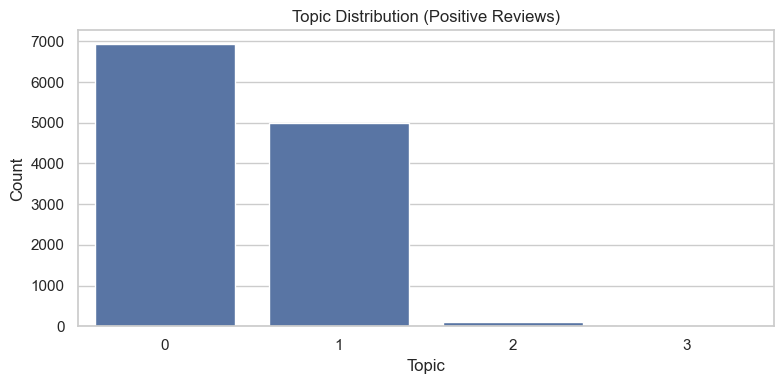

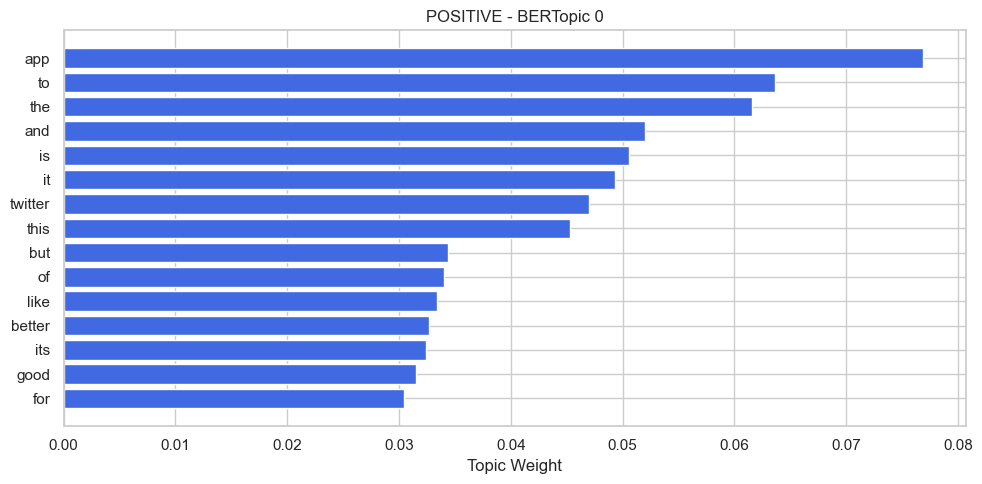

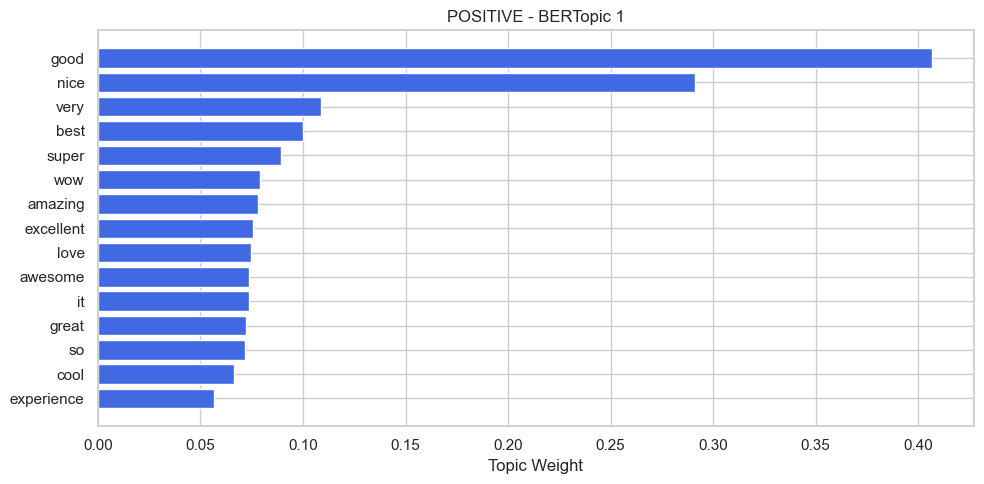

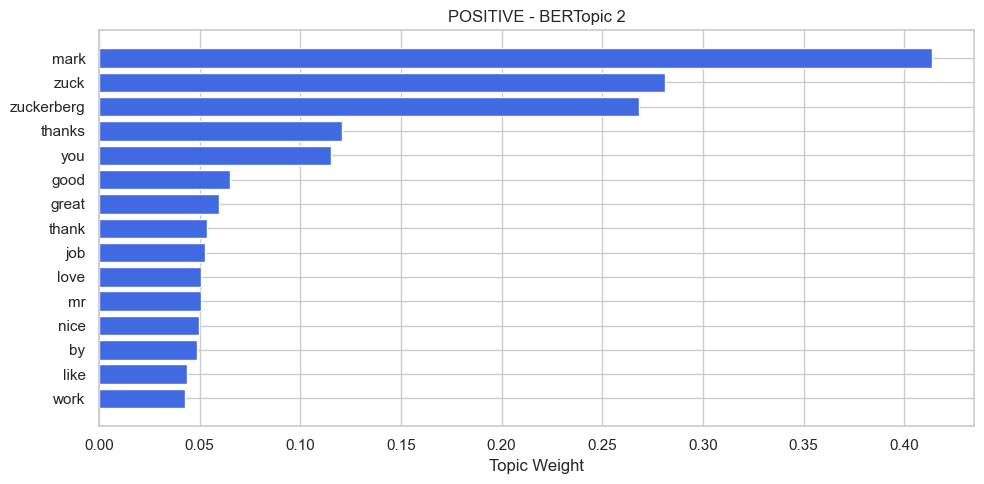

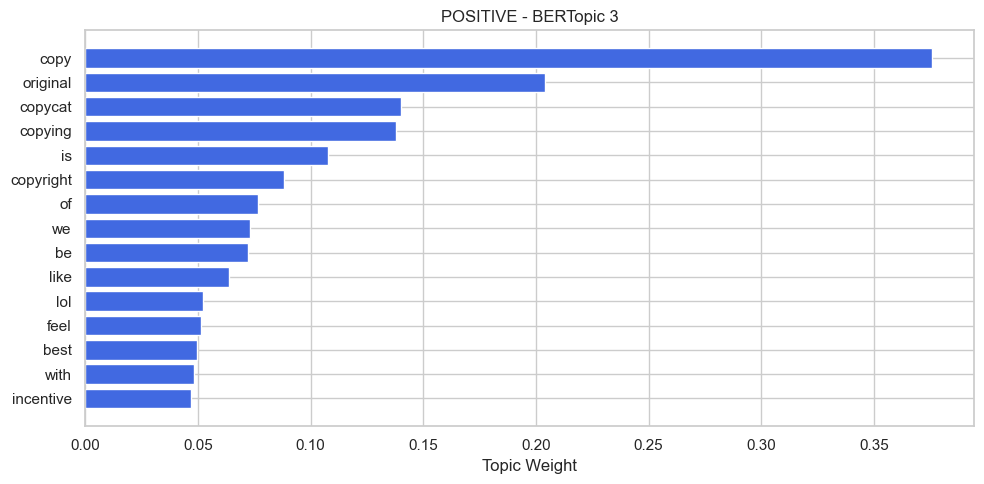


--- REPRESENTATIVE EXAMPLES (Positive) ---

Topic 0 Examples:
- Threads was fun for the first two weeks. After that it just became boring. It’s missing a lot of very basic features like drafts, bookmarking threads, ability to edit threads, and so much more. If the ...
- This app was one of the more random apps that I ever meet, literally is a copy of Twitter but I think it can be fun use an alternative version of twitter just we need give a little bit of time to the  ...
- The app is nice. I like the replacement twitter. Its good for old twitter users and for those who never have to ever experience that app and its users which is amazing in so many more ways than one. I ...

Topic 1 Examples:
- Good ...
- It's good 👍nice☺️☺️ ...
- Nice good 👍 ...

Topic 2 Examples:
- Good mark Zuckerberg we love you ...
- So good app🥰🥰🥰 Love you Mark Zuckerberg❤️❤️❤️🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰 ...
- THANK YOU @mark Zuckerberg❤️ ...

Topic 3 Examples:
- Nice copy ...
- Good copy ...
- Copy is copy anyway , origina

Batches:   0%|          | 0/291 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (NEUTRAL) — 5 TOPICS =====
   Topic  Count                            Name  \
0     -1   2954                -1_the_to_it_and   
1      0   2278  0_twitter_to_instagram_account   
2      1   2139               1_app_the_it_this   
3      2   1810        2_elon_first_review_musk   
4      3    104                3_osm_nyc_dm_dms   

                                      Representation  \
0  [the, to, it, and, app, is, twitter, of, this,...   
1  [twitter, to, instagram, account, the, of, and...   
2  [app, the, it, this, to, is, and, not, its, ca...   
3  [elon, first, review, musk, zuck, mark, to, ha...   
4  [osm, nyc, dm, dms, add, osam, we, need, can, ...   

                                 Representative_Docs  
0  [So at the moment I have two issues with the a...  
1  [It's Instagram not Twitter, Twitter 2007 is w...  
2  [The app install and i set it up just fine but...  
3  [Elon Musk 😂, The first one to review 😂, This ...  
4                             

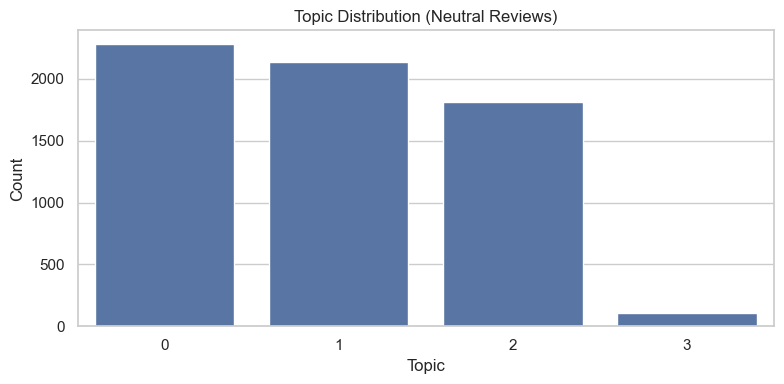

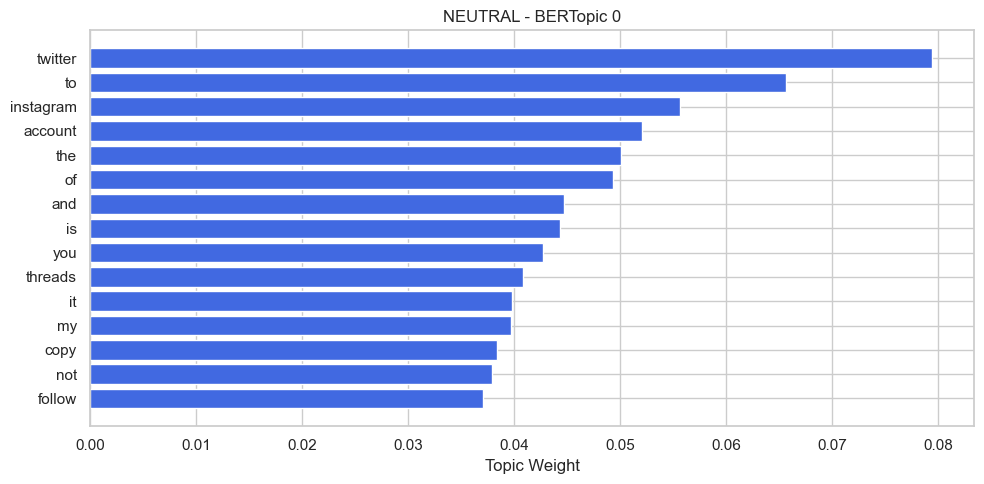

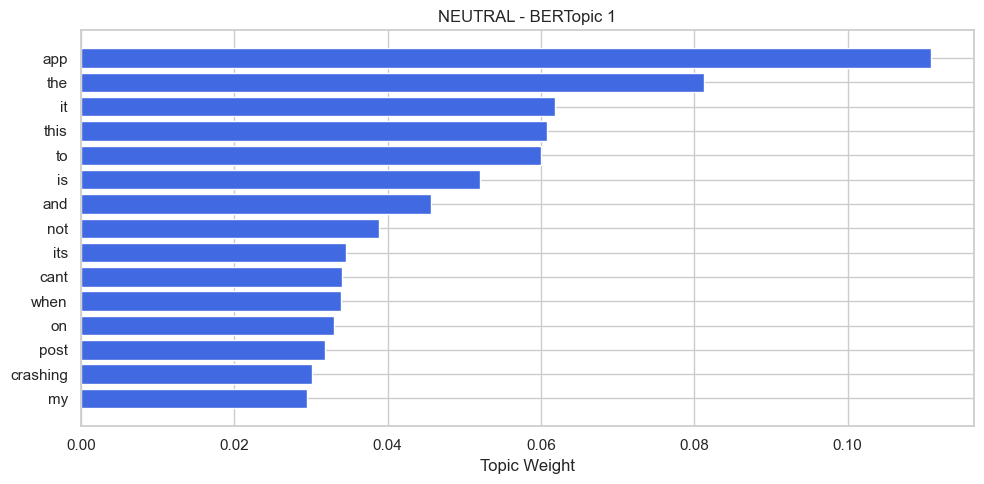

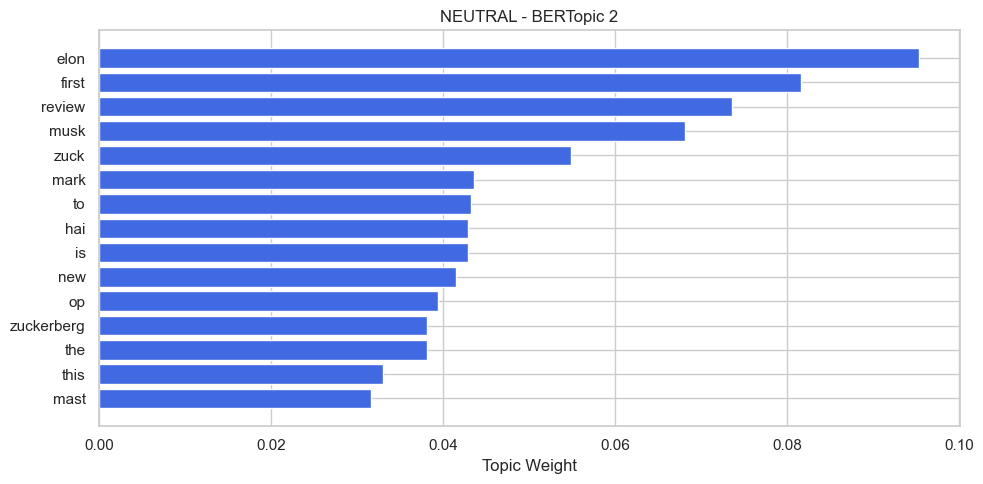

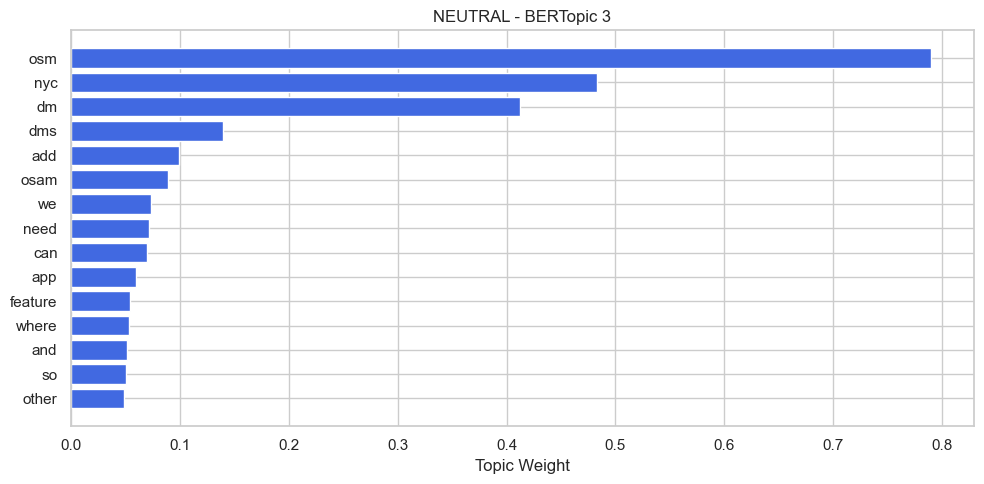


--- REPRESENTATIVE EXAMPLES (Neutral) ---

Topic 0 Examples:
- It's Instagram not Twitter ...
- Twitter 2007 is what you get with this app. I want to know how to completely delete my threads account without deleting my Instagram. ...
- The feed is nothing but suggested people and threads with maybe 1% of who you actually follow (much like Facebook but without an option for following only). Take a note from Twitter and make a Timelin ...

Topic 1 Examples:
- The app install and i set it up just fine but when i start scrolling the words and contents glitch so when i keep scrolling the words leaves stamps/trails of it self so i really cant understand or see ...
- While the app is a good one,I can't post media on it,anytime I try to post pictures and videos,the app just closes... It's frustrating!! ...
- this may be a bug. 
i just downloaded the app an hour ago, posted one text status. now every time i refresh the app to make a post it closes the app entirely, it's whenever i press the bu

Batches:   0%|          | 0/135 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (NEGATIVE) — 5 TOPICS =====
   Topic  Count                   Name  \
0     -1   1076       -1_the_to_and_it   
1      0   1321        0_to_the_and_of   
2      1   1156        1_app_the_to_it   
3      2    658  2_bad_boring_not_good   
4      3     81    3_elon_musk_zuck_is   

                                      Representation  \
0  [the, to, and, it, app, is, this, of, twitter,...   
1  [to, the, and, of, twitter, is, you, it, this,...   
2  [app, the, to, it, and, is, post, crashes, thi...   
3  [bad, boring, not, good, useless, very, experi...   
4  [elon, musk, zuck, is, zuckerberg, hate, fight...   

                                 Representative_Docs  
0  [Trash, if you are looking to see a Twitter ki...  
1  [I only put 5 stars so you could see don’t dow...  
2  [It's an alright app, simplistic. But it crash...  
3  [Very bad experience, Very bad experience 🤮🤮🤮🤮...  
4  [This is the real fight between Zuck and Elon ...  


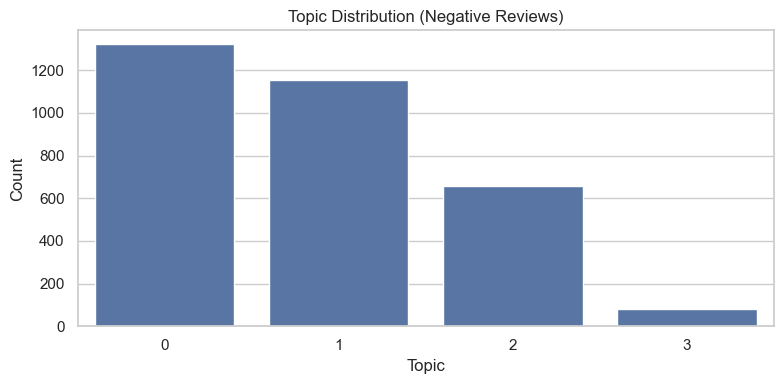

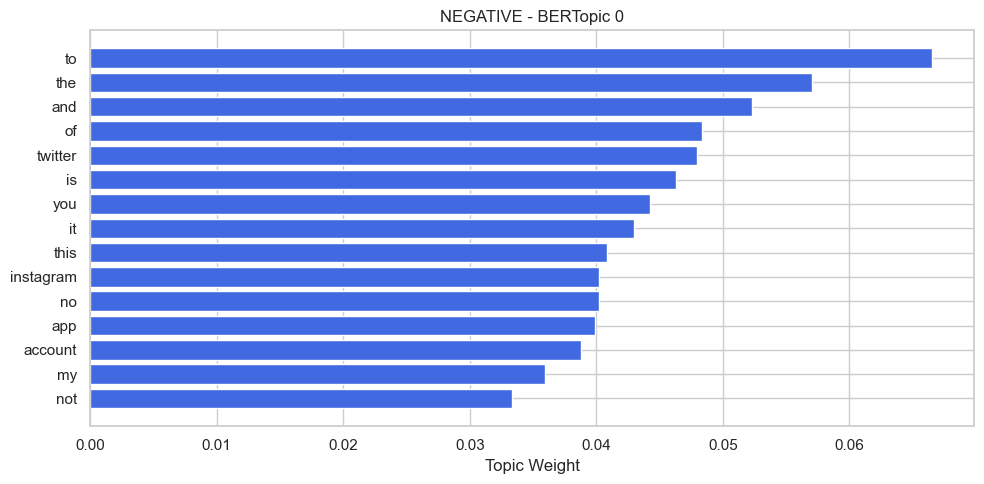

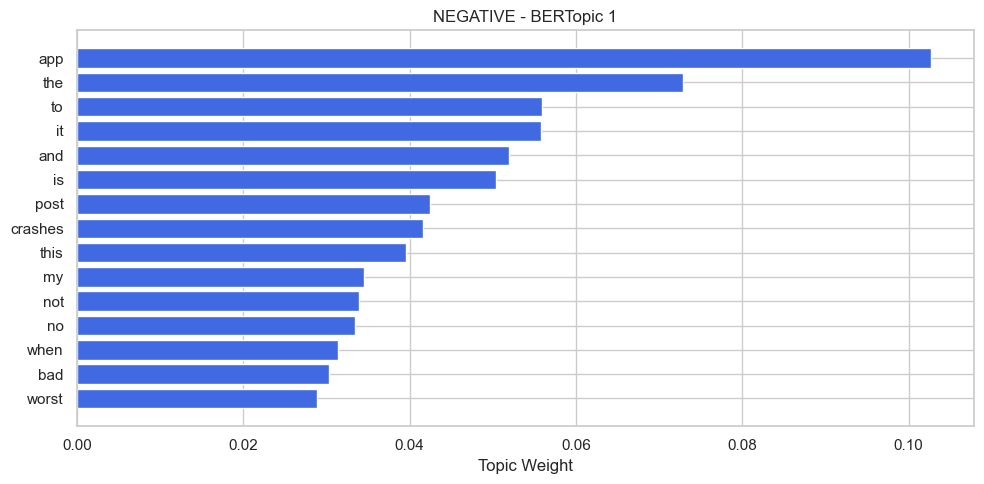

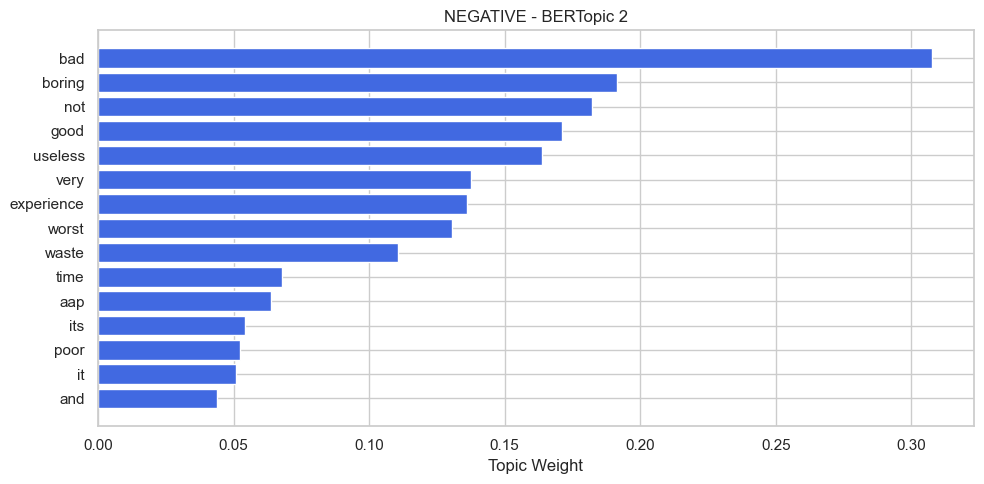

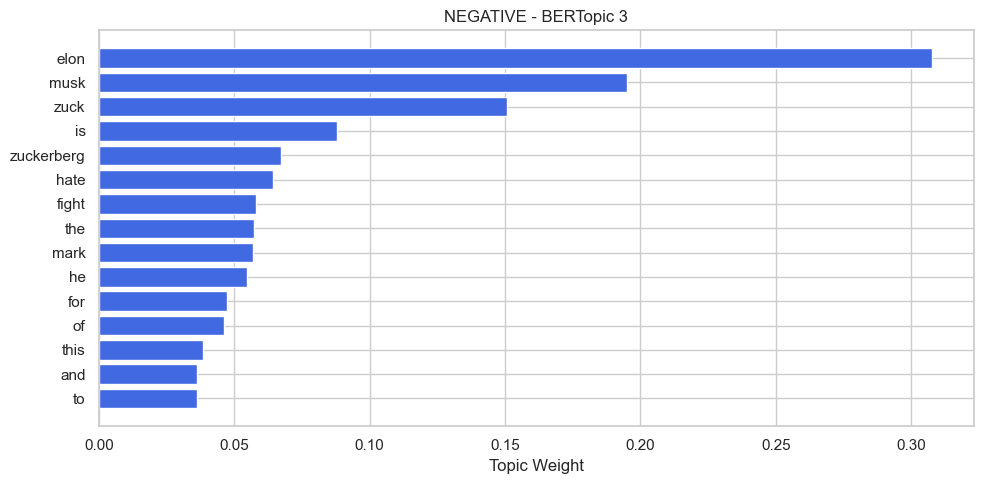


--- REPRESENTATIVE EXAMPLES (Negative) ---

Topic 0 Examples:
- I only put 5 stars so you could see don’t download this app because once you try to delete it it will delete your instagram too so there’s no way of getting rid of this app and if you try to deactivat ...
- I have Twitter, and hate Musk, so I thought I would give this a try. No way to sign-up. Just tells me to log in with my Instagram account. Never had one, never been on Instagram, and I have no interes ...
- There are no settings for you to control the experience. 

I made the mistake of refreshing my homepage and now I’m seeing accounts from the entire world — I can’t even find the people I follow anymor ...

Topic 1 Examples:
- It's an alright app, simplistic. But it crashes and close it self when I try and write something to post. I have to write the message in my phones notes app and copy and paste it over and post it befo ...
- Bad app not to try it 🤮 ...
- It is a bad app ...

Topic 2 Examples:
- Very bad experien

In [215]:
threads_pos_model, threads_pos_topics, threads_pos_probs, threads_pos_emb, threads_pos_coh = \
    run_bertopic_pipeline(df_threads, sentiment_value="positive")

threads_neu_model, threads_neu_topics, threads_neu_probs, threads_neu_emb, threads_neu_coh = \
    run_bertopic_pipeline(df_threads, sentiment_value="neutral")

threads_neg_model, threads_neg_topics, threads_neg_probs, threads_neg_emb, threads_neg_coh = \
    run_bertopic_pipeline(df_threads, sentiment_value="negative")


### Twitter BERTopic Analysis

Batches:   0%|          | 0/338 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (POSITIVE) — 5 TOPICS =====
   Topic  Count                      Name  \
0     -1   2598          -1_the_to_and_it   
1      0   4531           0_app_the_to_it   
2      1   3213    1_good_nice_very_great   
3      2    383  2_speech_free_freedom_of   
4      3     86      3_account_my_to_help   

                                      Representation  \
0  [the, to, and, it, app, is, twitter, of, for, ...   
1  [app, the, to, it, and, twitter, is, elon, thi...   
2  [good, nice, very, great, love, best, awesome,...   
3  [speech, free, freedom, of, the, is, to, and, ...   
4  [account, my, to, help, number, please, cant, ...   

                                 Representative_Docs  
0  [I have been using "TWITTER" for 11 years and ...  
1  [The Twitter app is really nice and I love it,...  
2                            [Good, Good, Good Nice]  
3            [Free speech, Free speech, Free speech]  
4  [Can anyone help me to get back my Twitter acc...  


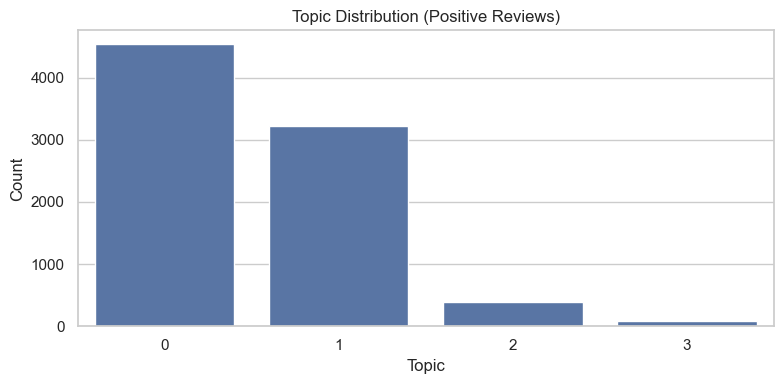

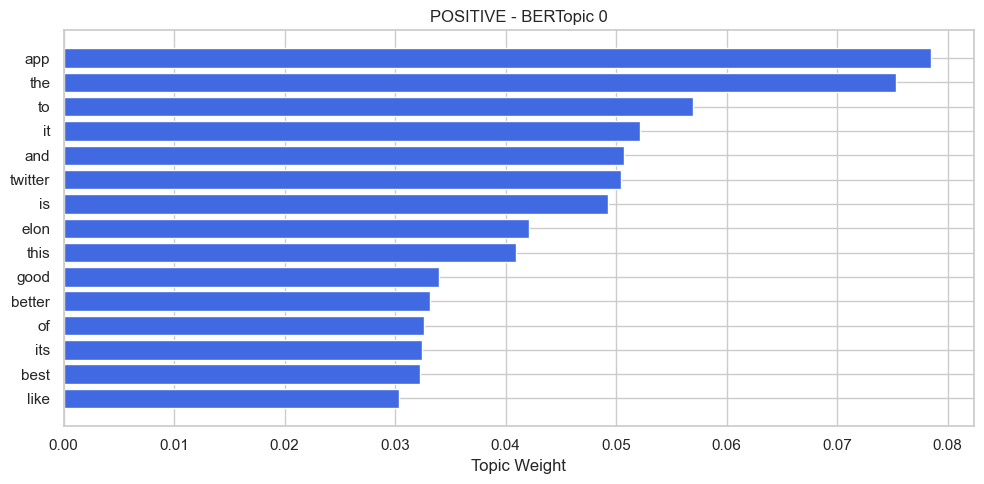

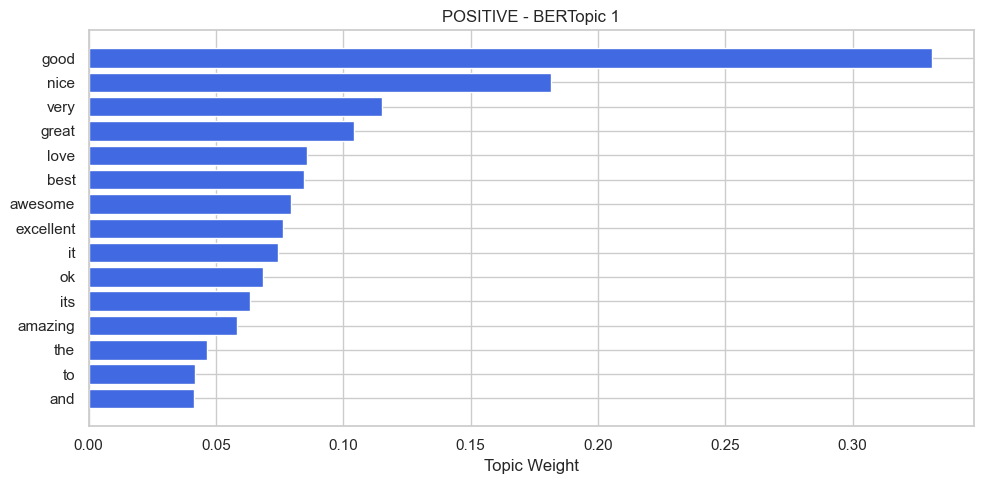

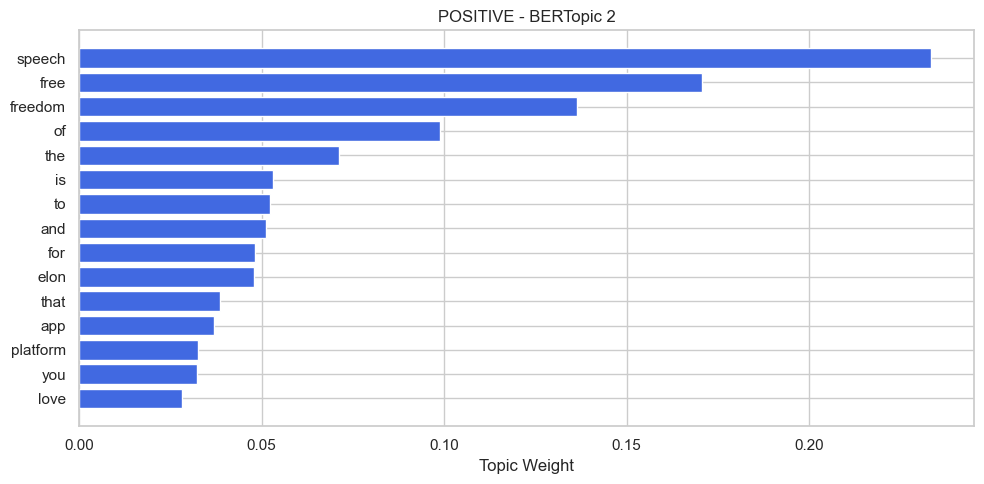

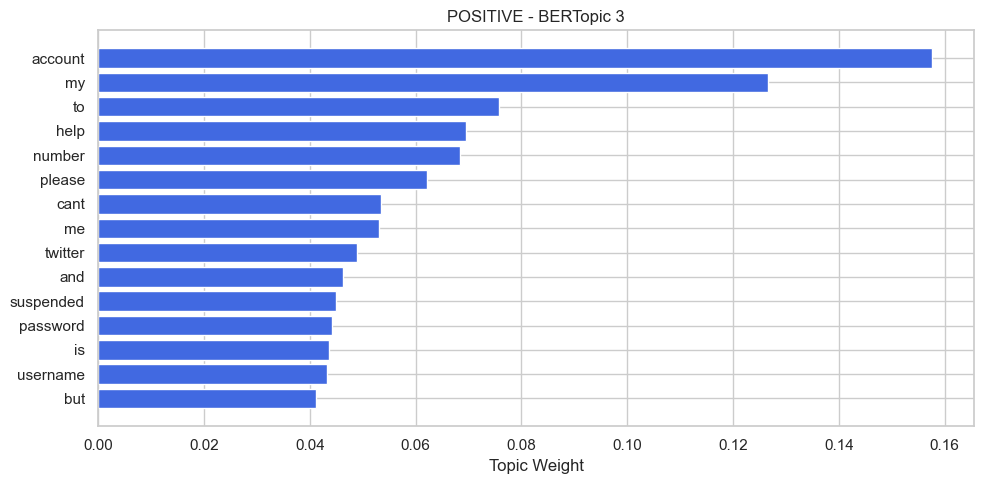


--- REPRESENTATIVE EXAMPLES (Positive) ---

Topic 0 Examples:
- The Twitter app is really nice and I love it ...
- The app is the best for the social media ...
- There was no need to change something that was going good in and of itself, just to better your image. I only found out about this app recently, and not only is the identity and status of the app chan ...

Topic 1 Examples:
- Good ...
- Good ...
- Good Nice ...

Topic 2 Examples:
- Free speech ...
- Free speech ...
- Free speech ...

Topic 3 Examples:
- Can anyone help me to get back my Twitter account. I did not have email or phone number under my profile. I always log in through the app but I logged out as I changed to a new device. Thinking Twitte ...
- My twitter account has been hacked and i am unable to login or change password and can't even report cause whoever hacked my account changed everything like username password and maybe phone number so ...
- I asked you for help to recover my account that is with my number, 

Batches:   0%|          | 0/321 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (NEUTRAL) — 5 TOPICS =====
   Topic  Count                          Name  \
0     -1   3244             -1_the_to_and_app   
1      0   4395          0_the_twitter_to_app   
2      1   1783         1_trash_to_threads_it   
3      2    691             2_elon_musk_is_it   
4      3    137  3_limit_rate_exceeded_limits   

                                      Representation  \
0  [the, to, and, app, it, is, this, twitter, of,...   
1  [the, twitter, to, app, it, is, and, this, not...   
2  [trash, to, threads, it, the, jelek, its, star...   
3  [elon, musk, is, it, to, for, the, you, since,...   
4  [limit, rate, exceeded, limits, posts, the, vi...   

                                 Representative_Docs  
0  [App is now on the hands of crypto currency pe...  
1  [Change the name back to Twitter, Why the lett...  
2  [Not what it used to be, What a trash app now,...  
3            [elon musk 🔫🔫🔫🔫, elon musk., Elon musk]  
4                          [Limit, LIMIT??

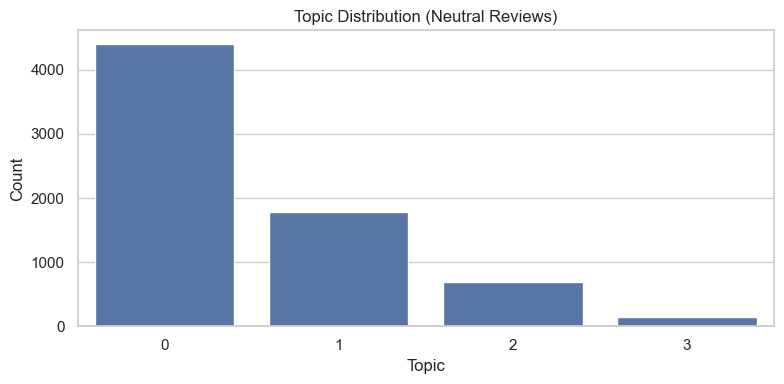

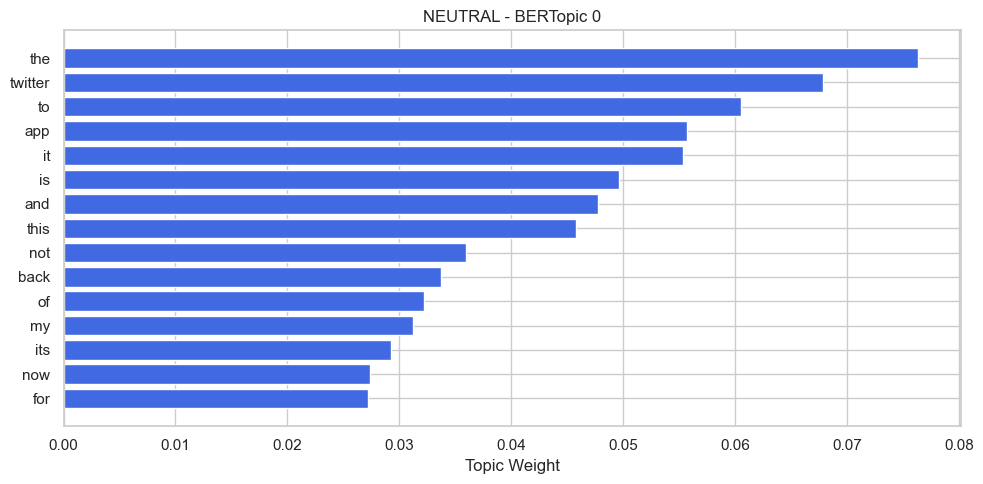

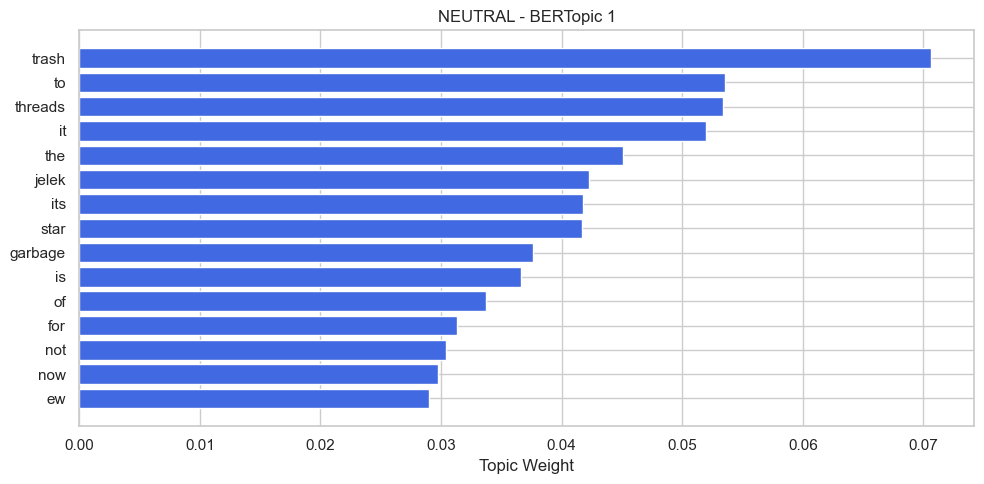

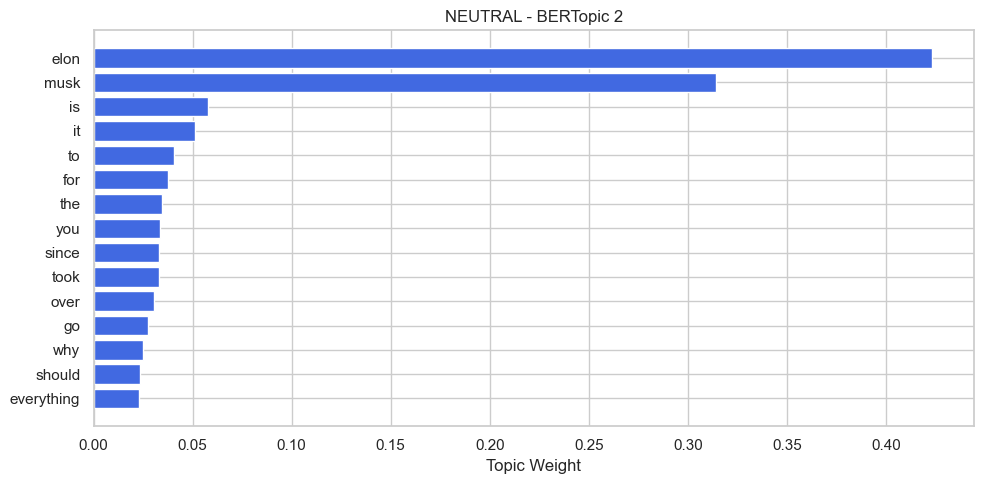

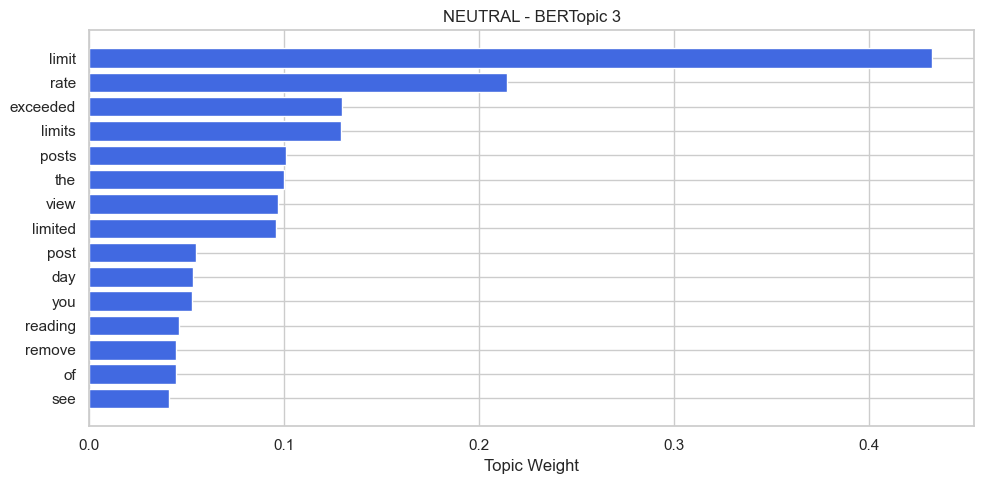


--- REPRESENTATIVE EXAMPLES (Neutral) ---

Topic 0 Examples:
- Change the name back to Twitter ...
- Why the letter X, change it back to Twitter and also the bird ...
- Not what it used to be. The app used to do a great job removing bad elements. And it seems like the only way to enjoy the app is if you buy the blue check. Mark . You used to be able to know if a veri ...

Topic 1 Examples:
- Not what it used to be ...
- What a trash app now ...
- It's not anymore what its used to be ...

Topic 2 Examples:
- elon musk 🔫🔫🔫🔫 ...
- elon musk. ...
- Elon musk ...

Topic 3 Examples:
- Limit ...
- LIMIT???? ...
- limit ...
Neutral BERTopic Coherence: 0.5753668724914095


Batches:   0%|          | 0/268 [00:00<?, ?it/s]


===== BERTOPIC SUMMARY (NEGATIVE) — 5 TOPICS =====
   Topic  Count                              Name  \
0     -1   2648                  -1_the_to_and_it   
1      0   4651                  0_the_and_to_app   
2      1   1112              1_bad_sucks_it_worse   
3      2    114           2_limit_rate_the_limits   
4      3     22  3_fire_dumpster_garbage_absolute   

                                      Representation  \
0  [the, to, and, it, is, app, of, this, twitter,...   
1  [the, and, to, app, is, it, twitter, this, elo...   
2  [bad, sucks, it, worse, no, and, not, worst, i...   
3  [limit, rate, the, limits, is, view, limiting,...   
4  [fire, dumpster, garbage, absolute, trash, rip...   

                                 Representative_Docs  
0  [The Twitter is gone now. It is sad but I am g...  
1  [Worst and its getting worst everyday with the...  
2                                    [bad, Bad, Bad]  
3  [rate limit sucks., THE RATE LIMIT SUCKS !!???...  
4      [Dumpster 

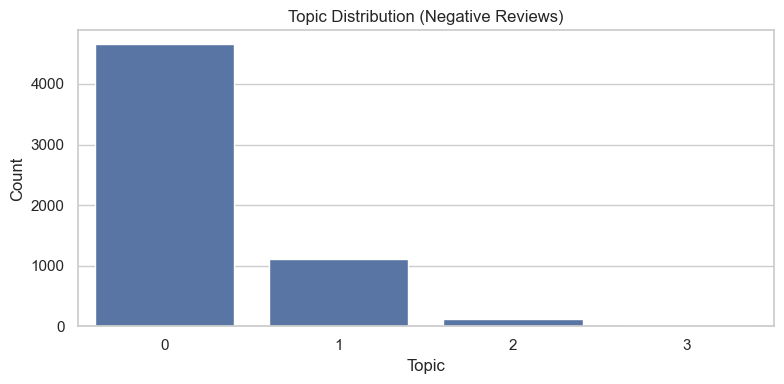

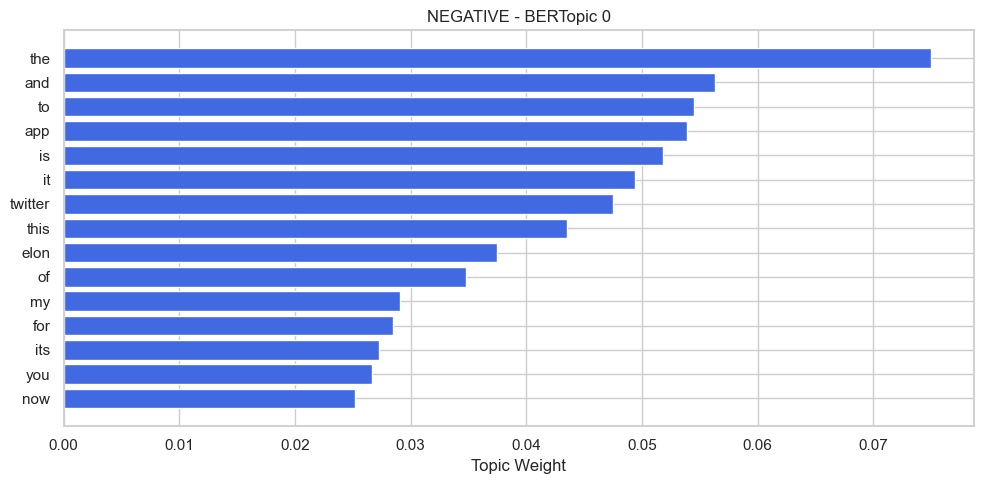

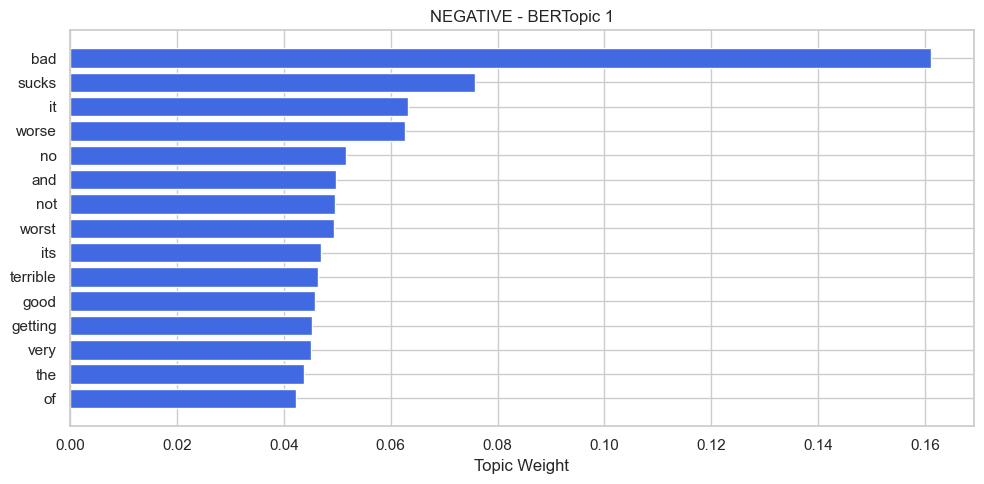

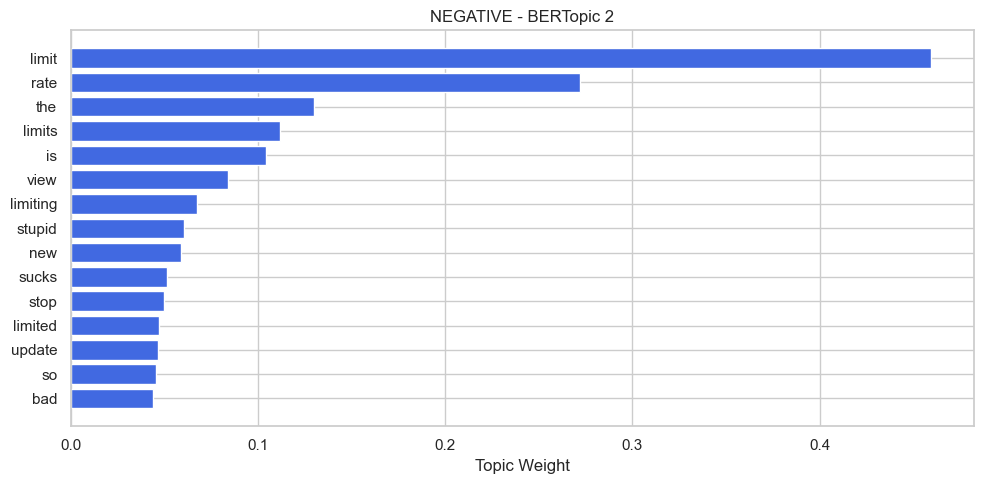

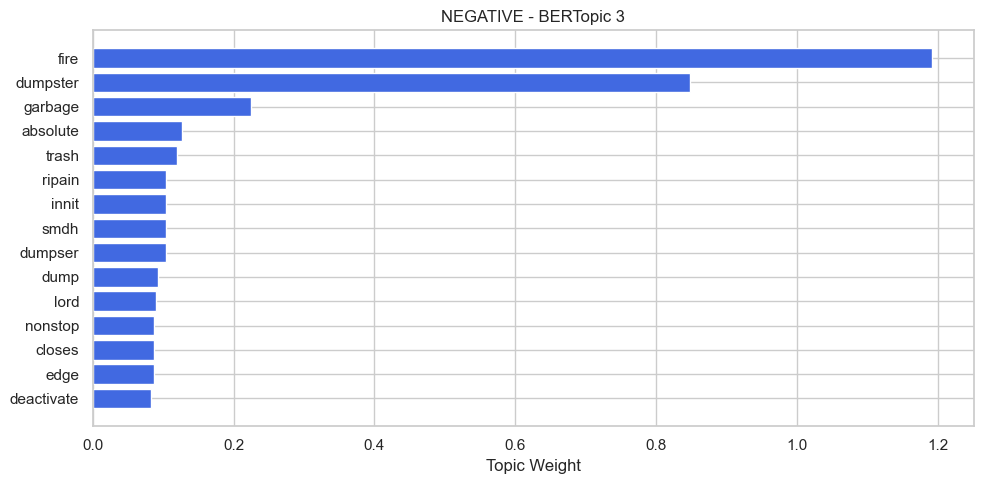


--- REPRESENTATIVE EXAMPLES (Negative) ---

Topic 0 Examples:
- Worst and its getting worst everyday with the all the new update by Elon. Doesnt seem like he wants to attract people to Twitter but its looks like he wants to get rid of all the users and totally mak ...
- This app has become trash. I never write reviews, but Elon is running this app into the ground. What was the point of rebranding to X? Why did he implement a tweet-read limit that doesn't even stop bo ...
- Elon Musk has done some very horrible decisions ever since he took over this app. Twitter was just fine the way it was before. He claims bots are less frequent than before, but in fact, they are even  ...

Topic 1 Examples:
- bad ...
- Bad ...
- Bad ...

Topic 2 Examples:
- rate limit sucks. ...
- THE RATE LIMIT SUCKS !!???!!! ...
- The rate limit sucks ...

Topic 3 Examples:
- Dumpster fire ...
- Dumpster Fire ...
- Dumpster fire ...
Negative BERTopic Coherence: 0.48020952599042704


In [217]:
twitter_pos_model, twitter_pos_topics, twitter_pos_probs, twitter_pos_emb, twitter_pos_coh = \
    run_bertopic_pipeline(df_twitter, sentiment_value="positive", review_col= "review_text")

twitter_neu_model, twitter_neu_topics, twitter_neu_probs, twitter_neu_emb, twitter_neu_coh = \
    run_bertopic_pipeline(df_twitter, sentiment_value="neutral", review_col = "review_text")

twitter_neg_model, twitter_neg_topics, twitter_neg_probs, twitter_neg_emb, twitter_neg_coh = \
    run_bertopic_pipeline(df_twitter, sentiment_value="negative",review_col="review_text")
